<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project2_transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Tracer transport

A critical aspect of understanding climate and environmental systems is describing the movement of substances. This could include pollution or water vapor in the atmosphere, salt in an estuary, or chemicals in a river. We often model the transport of these substances using an advection/diffusion equation for the concentration of the substance. In this context, we sometimes refer to the concentration field as a `tracer' since it helps us track the movement of individual molecules. We can also use this framework to describe the transport of heat, although in this case the tracer field (temperature or heat content) tracks the movement of thermal energy.

In this project we will use Dedalus to solve advection diffusion equations to describe the vertical distribution of heat in the ocean and the concentration of pollution in a river.

Student tasks are in [Section 1.4](#section1pt4), [Section 1.6](#section1pt6), and [Section 2.3](#section2pt3)

## Setup
If you are using Google colab, run the script below to install Dedalus

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://archiv

## 1. Thermal structure in the ocean

Most of the ocean has a stable thermal stratification with warm water at the surface and cold water in the abyss (exceptions occur in salt-stratified waters like the Arctic Ocean). Since the ocean is a massive thermal reservoir, understanding the distribution of this heat is important to quantifying the ocean's role in a changing climate. The structure of the temperature field can also inform us about the circulation in the ocean interior.


### 1.1 Measured temperature profile

The code below plots a sample temperature profile obtained off the coast of California. The data was obtained by digitizing Figure 3 in Munk, 1966.

Text(0, 0.5, 'Depth (m)')

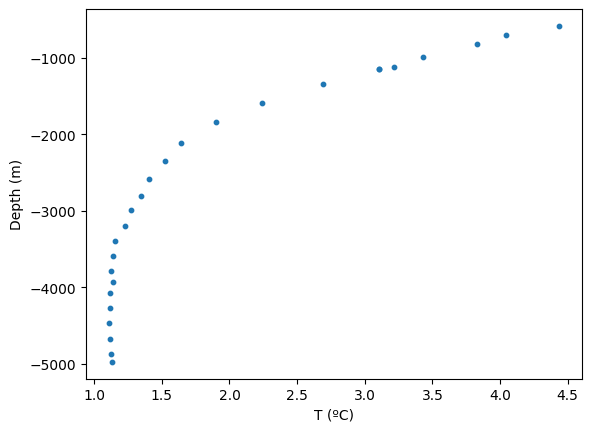

In [2]:
import matplotlib.pyplot as plt

# Temperature measurements extracted from Figure 3 in Munk, 1966
CTD_T = [1.1296296296296295, 1.122004357298475, 1.1143790849673203, 1.1067538126361656, 1.1143790849673203, 1.1143790849673203, 1.1372549019607843, 1.122004357298475, 1.1372549019607843, 1.1525054466230937, 1.2287581699346406, 1.2745098039215685, 1.343137254901961, 1.4041394335511983, 1.526143790849673, 1.6405228758169934, 1.8997821350762527, 2.242919389978214, 2.69281045751634, 3.104575163398693, 3.104575163398693, 3.218954248366013, 3.4324618736383443, 3.8289760348583877, 4.042483660130719, 4.438997821350762]
CTD_z = [-4976.958525345623, -4869.431643625192, -4677.419354838709, -4470.046082949309, -4270.353302611367, -4070.6605222734256, -3932.411674347158, -3786.4823348694317, -3586.78955453149, -3394.7772657450078, -3195.084485407066, -2995.3917050691243, -2803.379416282642, -2580.6451612903224, -2350.230414746544, -2112.1351766513058, -1843.3179723502303, -1597.5422427035332, -1344.0860215053763, -1144.3932411674346, -1144.3932411674346, -1121.351766513057, -990.7834101382491, -821.8125960061443, -698.9247311827958, -583.7173579109067]

plt.scatter(CTD_T,CTD_z,s=10)
plt.xlabel('T (ºC)')
plt.ylabel('Depth (m)')


### 1.2 Abyssal recipes

Munk (1966) proposed that the thermal structure of the ocean interior is set by a balance between upwelling and diffusion. In this view, cold waters sink near the poles and spread across the seafloor before slowly rising through the ocean interior. If we assume, as Munk did, that the water upwells uniformly across the globe, the upwelling speed is approximately $10^{-7}$ m/s. This is far too small to directly measure, but it is large enough to have a major impact on the distribution of tracers. Since light can only penetrate through the top ~100m of ocean, we can ignore solar heating, except in that it sets the temperature near the ocean surface.

### 1.3 Steady advection/diffusion equation

Dedalus can solve differential equations in various forms. In addition to time-dependent initial value problems (IVPs), Dedalus can solve linear and nonlinear boundary value problems. The code below uses Dedalus to solve a linear boundary value problem (IVBP) for the steady state advection/diffusion equation.

Here, the top and bottom temperature are set from the measured profile and these are used as boundary conditions. The vertical (upwelling) velocity is set to $10^{-7} m/s$, and the diffusivity is set to $10^{-7}$ $m^2/s$, to approximate the molecular diffusivity of heat in seawater.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


2024-12-25 00:41:05,612 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


Text(0, 0.5, 'Depth (m)')

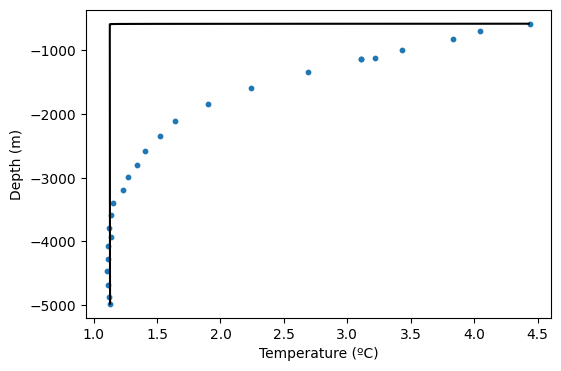

In [3]:
"""
Dedalus script to solve the steady advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the upwelling velocity
w = 1e-7 # m/s
# Set the diffusivity
kappa=1e-7 # m^2/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - kappa*Tzz = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.4 Student investigation
<a id='section1pt4'></a>
Note that the profile above is not a good fit to the data. This implies that molecular diffusion isn't sufficient to transport heat down from the surface and stop the ocean from filling up with cold, dense water.

Munk (1966) proposed that small-scale turbulence in the ocean interior results in a diffusivity that is orders of magnitude larger than the molecular value. Find a diffusivity that gives a good match with the data and test it in the Dedalus script above. Comment on the ability of this model (steady advection/diffusion) to fit the data.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


2024-12-25 00:43:05,768 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2024-12-25 00:43:06,196 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+00/s


2024-12-25 00:43:06,456 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.7e+00/s


2024-12-25 00:43:06,623 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.7e+00/s


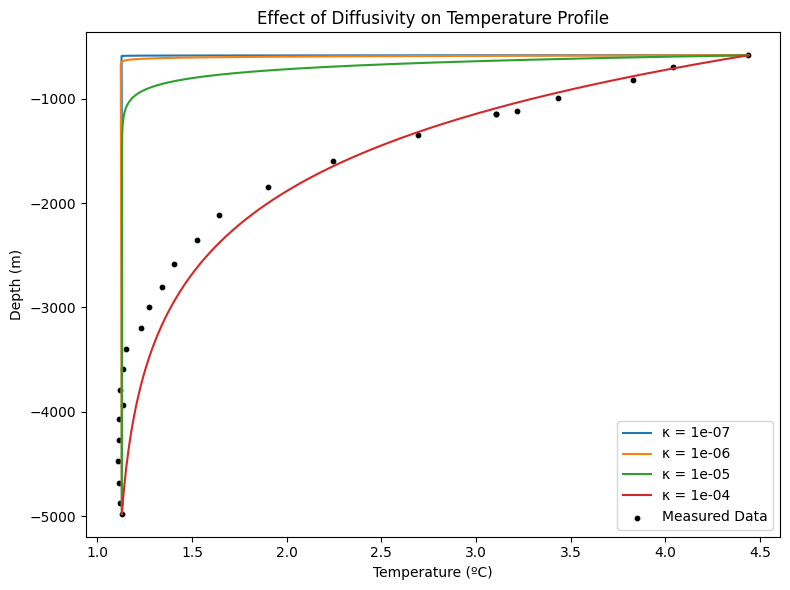

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Input CTD data
CTD_T = [1.1296, 1.1220, 1.1144, 1.1068, 1.1144, 1.1144, 1.1373, 1.1220, 1.1373, 1.1525,
         1.2288, 1.2745, 1.3431, 1.4041, 1.5261, 1.6405, 1.8998, 2.2429, 2.6928, 3.1046,
         3.1046, 3.2190, 3.4325, 3.8290, 4.0425, 4.4390]
CTD_z = [-4976.96, -4869.43, -4677.42, -4470.05, -4270.35, -4070.66, -3932.41, -3786.48,
         -3586.79, -3394.78, -3195.08, -2995.39, -2803.38, -2580.65, -2350.23, -2112.14,
         -1843.32, -1597.54, -1344.09, -1144.39, -1144.39, -1121.35, -990.78, -821.81,
         -698.92, -583.72]

# Parameters
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000  # Number of grid points

# Upwelling velocity and test diffusivities
w = 1e-7  # m/s
diffusivities = [1e-7, 1e-6, 1e-5, 1e-4]  # Test different values for kappa

# --- Dedalus Setup ---
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Loop over diffusivities
plt.figure(figsize=(8, 6))
for kappa in diffusivities:
    # Fields
    T = dist.Field(name='T', bases=zbasis)
    tau_1 = dist.Field(name='tau_1')
    tau_2 = dist.Field(name='tau_2')

    # Substitutions for derivatives
    dz = lambda A: d3.Differentiate(A, zcoord)
    Tz = dz(T) + d3.Lift(tau_1, zbasis.derivative_basis(1), -1)
    Tzz = dz(Tz) + d3.Lift(tau_2, zbasis.derivative_basis(1), -1)

    # Problem
    problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
    problem.add_equation("w*Tz - kappa*Tzz = 0")
    problem.add_equation("T(z=z_surface) = T_surface")
    problem.add_equation("T(z=z_bottom) = T_bottom")

    # Solver
    solver = problem.build_solver()
    solver.solve()

    # Extract solution
    Tg = T['g']

    # Plot result
    plt.plot(Tg, z, label=f"κ = {kappa:.0e}")

# Plot measured data
plt.scatter(CTD_T, CTD_z, s=10, c="black", label="Measured Data")
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')
plt.title('Effect of Diffusivity on Temperature Profile')
plt.legend()
plt.tight_layout()
plt.show()


from the plotting above we can tell, that the diffusivity of 1e-4 is best matched with the observed profile. it is mostly good to describe the profile which is evident that the model (steady advection/diffusion) is able to fit the data.the large difussivity suggests that turbulent mixing in the ocean interior, which results in effective diffusivities much larger than the molecular value, plays a dominant role in heat transport. though the model kind of matches the data, it is still simplified, as it considers constant diffusicity.

### 1.5 Turning ocean mixing upside down

Decades of research to measure the turbulent diffusivity in the ocean consistently found values much smaller than the one predicted by Munk (1966). Specifically, while larger values of the turbulent diffusivity were found near the bottom of the ocean over rough topographic features, the values in the upper ocean were about 10x smaller than the values predicted by Munk. 50 years after Munk's seminal paper, Ferrari et al. (2016) proposed that a depth-dependent turbulent diffusivity could be balanced by <em>downwelling</em>, with negative vertical velocities in the ocean interior. In this theory, the overturning circulation is upwelling in thin boundary layers along the sloping sides of the ocean basins.

When the diffusivity, $\kappa$, is a function of $z$, the steady advection/diffusion equation can be written

$$ w\frac{dT}{dz} = \frac{d}{dz}\left(\kappa(z) \frac{dT}{dz}\right)$$

The Dedalus script below solves the previous equation and again compares the results with the observed temperature profile. For the depth-dependent diffusivity, $\kappa(z)$, we take

$$ \kappa(z)=\kappa_{bg} + (\kappa_0-\kappa_{bg})e^{-(z+D)/l} $$

using the form from Rogers et al., 2023, where $\kappa_{bg}=1\times 10^{-5} m^2/s$ is the background diffusivity characteristic of the upper water column, $\kappa_0=8.6\times 10^{-4} m^2/s$ characterizes the enhanced mixing near the bottom of the ocean, $D$ is a reference depth where $\kappa=\kappa_0$, and $l=667m$ is an exponential decay scale. In the script below, we start with $w=0$.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-25 00:50:55,647 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


Text(0, 0.5, 'Depth (m)')

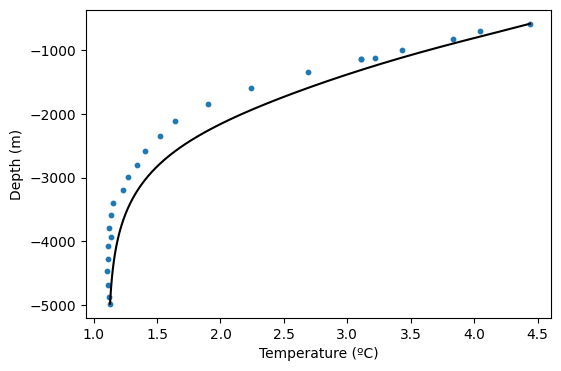

In [5]:
"""
Dedalus script to solve the steady advection/diffusion equation
with a spatially-variable diffusivity
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the vertical velocity
w = 0 # m/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)
kappa = dist.Field(name='kappa', bases=zbasis)
# Set the diffusivity
# Below is the diffusivity profile from Rogers et al., 2023
kappa['g']=1e-5 + (8.6e-4-1e-5)*np.exp((-5e3-z)/667) # m^2/s

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.6 Student investigation
<a id='section1pt6'></a>
Note from the results of the script above that the density profile is reasonable, even though $w=0$. In the box below, comment on the balance in this case and what this implies about the diffusive heat flux.

Next, find a vertical velocity that produces a better agreement with the observations and report it below. Then, try varying the details of the $\kappa(z)$ profile. How sensitive is the optimal $w$ to your choice of $\kappa(z)$? What does this imply about the circulation in the ocean interior if $\kappa(z)$ varies between regions of smooth and rough topography?

(As an aside, note that the requied vertical velocity is much smaller than the one used by Munk (1966). This implies that the dense, cold water that sinks at the poles must rise elsewhere. Ferrari et al. (2016) proposed that this occurs in boundary layers near the seafloor.)

Its insteresting that, when $w =0$, it matches with the general profile, but deviates at middle depth. the balance relies only on varying $\kappa$. The fit, while reasonable, indicates that diffusion alone cannot fully capture the observed profile.
by the plot of various $w$, i found $w = $7.5 e-9 m/s best matches the data, as successfully captures the structure of the mid-depth region, which has deviation if $w$ =0, though it is still not perfect.
i tested different values for $k_bg, k_0$, and $l$, and calculate the absolute error for each values, and my final choice is $k_bg = 1e-5, k_0 = 7.6e-4$, and $l = 512.5m$.$$$$
The sensitivity of $w_{opt}$ to the choice of k(z) is evident from the results.
When $k_bg$ was doubled, the $w_{opt}$ increased to 2.0e-08 m/s, showing that w is strongly influenced by background diffusivity.
Doubling $k_0$ decreased the $w_{opt}$ to 6.2e-09 m/s, while doubling l increased the $w_{opt}$ to 1.2e-08 m/s.
This analysis reveals that the sensitivity of w to diffusivity parameters ranks as: $k_bg$ > l > $k_0$.

$$$$The ranking of the sensitivity of $w$ to the diffusivity parameters ($k_{bg} > l > k_0$) highlights the primary drivers of heat transport variability in the ocean interior. $k_{bg}$, representing the baseline mixing in the upper ocean, has the strongest impact on $w$ because it governs the overall background diffusivity, which sets the scale for both diffusion and advection in smoother topographic regions. $l$, the exponential decay scale, affects the vertical structure of $\kappa(z)$, influencing how far turbulence penetrates into the water column and thereby altering the required $w$. Finally, $k_0$, the enhanced mixing near rough topography, has the least impact on $w$, as it primarily affects localized regions. This ranking indicates that circulation in the ocean interior is most sensitive to changes in broad-scale diffusivity (e.g., $k_{bg}$), while fine-scale features such as topographic mixing ($k_0$) play a secondary role. Thus, understanding and accurately parameterizing $k_{bg}$ and $l$ is critical for modeling large-scale ocean circulation dynamics.


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-12-25 01:36:48,062 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.7e+01/s


2024-12-25 01:36:48,155 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.7e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+01/s


2024-12-25 01:36:48,230 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+01/s


2024-12-25 01:36:48,303 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+01/s


2024-12-25 01:36:48,382 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+01/s


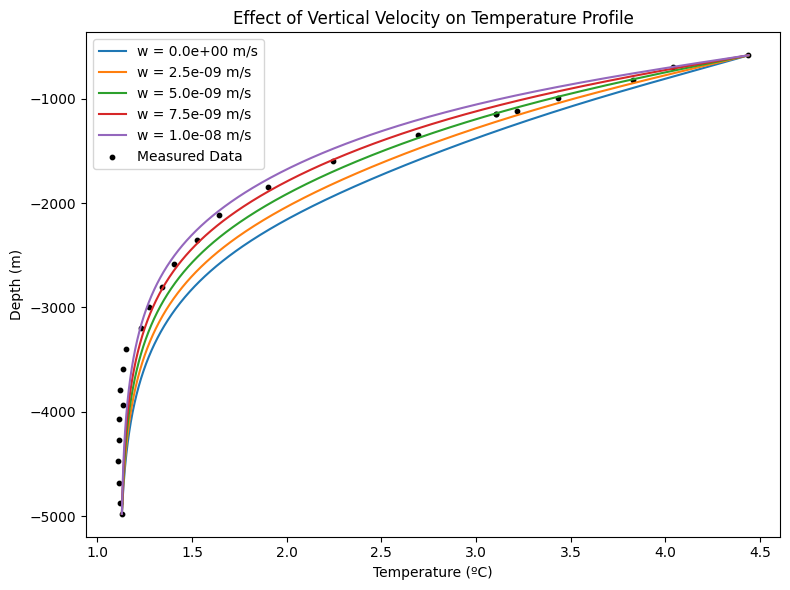

w = 0.0e+00 m/s, Error = 4.509
w = 2.5e-09 m/s, Error = 2.863
w = 5.0e-09 m/s, Error = 1.513
w = 7.5e-09 m/s, Error = 1.484
w = 1.0e-08 m/s, Error = 2.351


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# List of vertical velocities to test
w_values = np.linspace(0, 1e-8, 5)

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)
kappa = dist.Field(name='kappa', bases=zbasis)

# Set the diffusivity
# Below is the diffusivity profile from Rogers et al., 2023
k_bg = 1e-5
k_0 = 8.6e-4
l = 667

# Store errors for each vertical velocity
errors = []

plt.figure(figsize=(8, 6))

for w in w_values:
    kappa['g'] = k_bg + (k_0 - k_bg) * np.exp((-5e3 - z) / l)  # m^2/s

    # Add two tau variables to allow us to apply two boundary conditions
    tau_1 = dist.Field(name='tau_1')
    tau_2 = dist.Field(name='tau_2')
    lift_basis = zbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)

    # Substitutions
    dz = lambda A: d3.Differentiate(A, zcoord)
    Tz = dz(T) + lift(tau_1)
    Tzz = dz(Tz) + lift(tau_2)

    # Problem
    problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
    problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
    problem.add_equation("T(z=z_surface) = T_surface")
    problem.add_equation("T(z=z_bottom) = T_bottom")

    # Solver
    solver = problem.build_solver()
    solver.solve()

    # Extract the solution
    Tg = T['g']

    # Calculate error
    interpolated_T = np.interp(CTD_z, z, Tg)
    error = np.sum(np.abs(interpolated_T - CTD_T))
    errors.append(error)

    # Plot the solution
    plt.plot(Tg, z, label=f'w = {w:.1e} m/s')

# Plot the observed data
plt.scatter(CTD_T, CTD_z, s=10, c='black', label='Measured Data')

# Add labels and legend
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')
plt.title('Effect of Vertical Velocity on Temperature Profile')
plt.legend()
plt.tight_layout()
plt.show()

# Print errors for each vertical velocity
for w, error in zip(w_values, errors):
    print(f'w = {w:.1e} m/s, Error = {error:.3f}')


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.2e+00/s


2024-12-25 01:34:41,840 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


2024-12-25 01:34:41,975 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+01/s


2024-12-25 01:34:42,097 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.5e+00/s


2024-12-25 01:34:42,224 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.9e+00/s


2024-12-25 01:34:42,350 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.9e+00/s


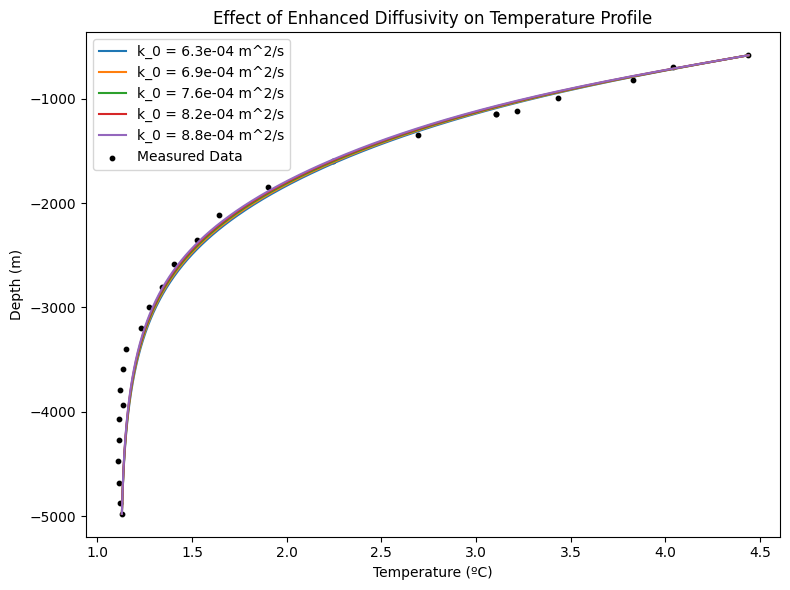

k_0 = 6.3e-04 m^2/s, Error = 1.489
k_0 = 6.9e-04 m^2/s, Error = 1.475
k_0 = 7.6e-04 m^2/s, Error = 1.465
k_0 = 8.2e-04 m^2/s, Error = 1.472
k_0 = 8.8e-04 m^2/s, Error = 1.490


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Fixed vertical velocity
w = 7.5e-9  # m/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)
kappa = dist.Field(name='kappa', bases=zbasis)

# Set the diffusivity
# Test varying k_0 values
k_bg = 1e-5
k_0_values = np.linspace(6.3e-4, 8.8e-4, 5)  # 5 values from 5e-4 to 1e-3
l = 667

# Store errors for each k_0
errors = []

plt.figure(figsize=(8, 6))

for k_0 in k_0_values:
    kappa['g'] = k_bg + (k_0 - k_bg) * np.exp((-5e3 - z) / l)  # m^2/s

    # Add two tau variables to allow us to apply two boundary conditions
    tau_1 = dist.Field(name='tau_1')
    tau_2 = dist.Field(name='tau_2')
    lift_basis = zbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)

    # Substitutions
    dz = lambda A: d3.Differentiate(A, zcoord)
    Tz = dz(T) + lift(tau_1)
    Tzz = dz(Tz) + lift(tau_2)

    # Problem
    problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
    problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
    problem.add_equation("T(z=z_surface) = T_surface")
    problem.add_equation("T(z=z_bottom) = T_bottom")

    # Solver
    solver = problem.build_solver()
    solver.solve()

    # Extract the solution
    Tg = T['g']

    # Calculate error
    interpolated_T = np.interp(CTD_z, z, Tg)
    error = np.sum(np.abs(interpolated_T - CTD_T))
    errors.append(error)

    # Plot the solution
    plt.plot(Tg, z, label=f'k_0 = {k_0:.1e} m^2/s')

# Plot the observed data
plt.scatter(CTD_T, CTD_z, s=10, c='black', label='Measured Data')

# Add labels and legend
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')
plt.title('Effect of Enhanced Diffusivity on Temperature Profile')
plt.legend()
plt.tight_layout()
plt.show()

# Print errors for each k_0
for k_0, error in zip(k_0_values, errors):
    print(f'k_0 = {k_0:.1e} m^2/s, Error = {error:.3f}')


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


2024-12-25 01:41:55,008 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.0e+00/s


2024-12-25 01:41:55,270 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.0e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.4e+00/s


2024-12-25 01:41:55,428 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.1e+00/s


2024-12-25 01:41:55,640 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


2024-12-25 01:41:55,778 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


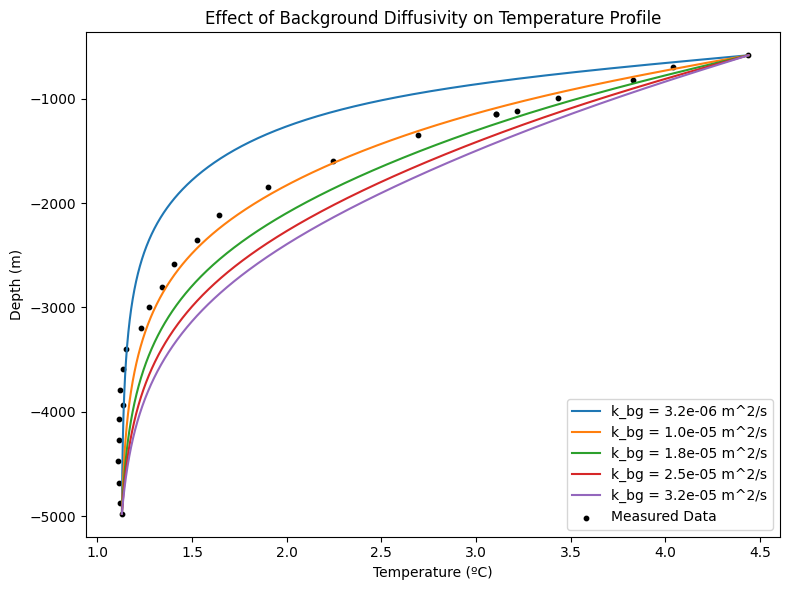

k_bg = 3.2e-06 m^2/s, Error = 7.579
k_bg = 1.0e-05 m^2/s, Error = 1.462
k_bg = 1.8e-05 m^2/s, Error = 3.481
k_bg = 2.5e-05 m^2/s, Error = 5.562
k_bg = 3.2e-05 m^2/s, Error = 7.060


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Fixed vertical velocity
w = 7.5e-9  # m/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)
kappa = dist.Field(name='kappa', bases=zbasis)

# Set the diffusivity
# Test varying k_bg values
k_0 = 7.6e-4
k_bg_values = np.linspace(3.2e-6, 3.2e-5, 5)  # 5 values from 3.2e-6 to 3.2e-5
l = 667

# Store errors for each k_bg
errors = []

plt.figure(figsize=(8, 6))

for k_bg in k_bg_values:
    kappa['g'] = k_bg + (k_0 - k_bg) * np.exp((-5e3 - z) / l)  # m^2/s

    # Add two tau variables to allow us to apply two boundary conditions
    tau_1 = dist.Field(name='tau_1')
    tau_2 = dist.Field(name='tau_2')
    lift_basis = zbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)

    # Substitutions
    dz = lambda A: d3.Differentiate(A, zcoord)
    Tz = dz(T) + lift(tau_1)
    Tzz = dz(Tz) + lift(tau_2)

    # Problem
    problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
    problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
    problem.add_equation("T(z=z_surface) = T_surface")
    problem.add_equation("T(z=z_bottom) = T_bottom")

    # Solver
    solver = problem.build_solver()
    solver.solve()

    # Extract the solution
    Tg = T['g']

    # Calculate error
    interpolated_T = np.interp(CTD_z, z, Tg)
    error = np.sum(np.abs(interpolated_T - CTD_T))
    errors.append(error)

    # Plot the solution
    plt.plot(Tg, z, label=f'k_bg = {k_bg:.1e} m^2/s')

# Plot the observed data
plt.scatter(CTD_T, CTD_z, s=10, c='black', label='Measured Data')

# Add labels and legend
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')
plt.title('Effect of Background Diffusivity on Temperature Profile')
plt.legend()
plt.tight_layout()
plt.show()

# Print errors for each k_bg
for k_bg, error in zip(k_bg_values, errors):
    print(f'k_bg = {k_bg:.1e} m^2/s, Error = {error:.3f}')


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s


2024-12-25 01:57:38,217 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+01/s


2024-12-25 01:57:38,313 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.7e+01/s


2024-12-25 01:57:38,389 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.7e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+01/s


2024-12-25 01:57:38,478 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+01/s


2024-12-25 01:57:38,553 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+01/s


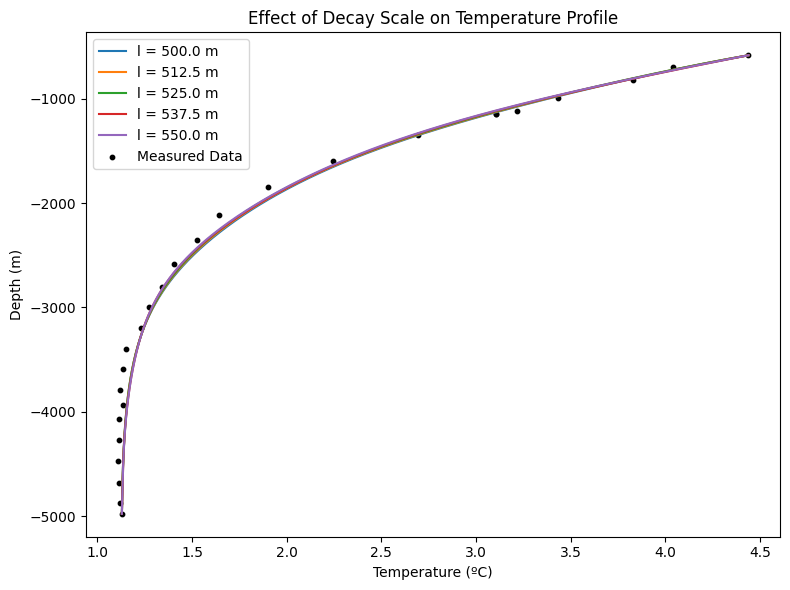

l = 500.0 m, Error = 1.105
l = 512.5 m, Error = 1.092
l = 525.0 m, Error = 1.093
l = 537.5 m, Error = 1.136
l = 550.0 m, Error = 1.146


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Fixed vertical velocity
w = 7.5e-9  # m/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)
kappa = dist.Field(name='kappa', bases=zbasis)

# Set the diffusivity
# Test varying l values
k_0 = 7.6e-4
k_bg = 1e-5
l_values = np.linspace(500, 550, 5)  # 5 values from 500m to 1000m

# Store errors for each l
errors = []

plt.figure(figsize=(8, 6))

for l in l_values:
    kappa['g'] = k_bg + (k_0 - k_bg) * np.exp((-5e3 - z) / l)  # m^2/s

    # Add two tau variables to allow us to apply two boundary conditions
    tau_1 = dist.Field(name='tau_1')
    tau_2 = dist.Field(name='tau_2')
    lift_basis = zbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)

    # Substitutions
    dz = lambda A: d3.Differentiate(A, zcoord)
    Tz = dz(T) + lift(tau_1)
    Tzz = dz(Tz) + lift(tau_2)

    # Problem
    problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
    problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
    problem.add_equation("T(z=z_surface) = T_surface")
    problem.add_equation("T(z=z_bottom) = T_bottom")

    # Solver
    solver = problem.build_solver()
    solver.solve()

    # Extract the solution
    Tg = T['g']

    # Calculate error
    interpolated_T = np.interp(CTD_z, z, Tg)
    error = np.sum(np.abs(interpolated_T - CTD_T))
    errors.append(error)

    # Plot the solution
    plt.plot(Tg, z, label=f'l = {l:.1f} m')

# Plot the observed data
plt.scatter(CTD_T, CTD_z, s=10, c='black', label='Measured Data')

# Add labels and legend
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')
plt.title('Effect of Decay Scale on Temperature Profile')
plt.legend()
plt.tight_layout()
plt.show()

# Print errors for each l
for l, error in zip(l_values, errors):
    print(f'l = {l:.1f} m, Error = {error:.3f}')


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


2024-12-25 01:58:16,296 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.7e+01/s


2024-12-25 01:58:16,384 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.7e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+01/s


2024-12-25 01:58:16,456 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.7e+01/s


2024-12-25 01:58:16,532 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.7e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


2024-12-25 01:58:16,785 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


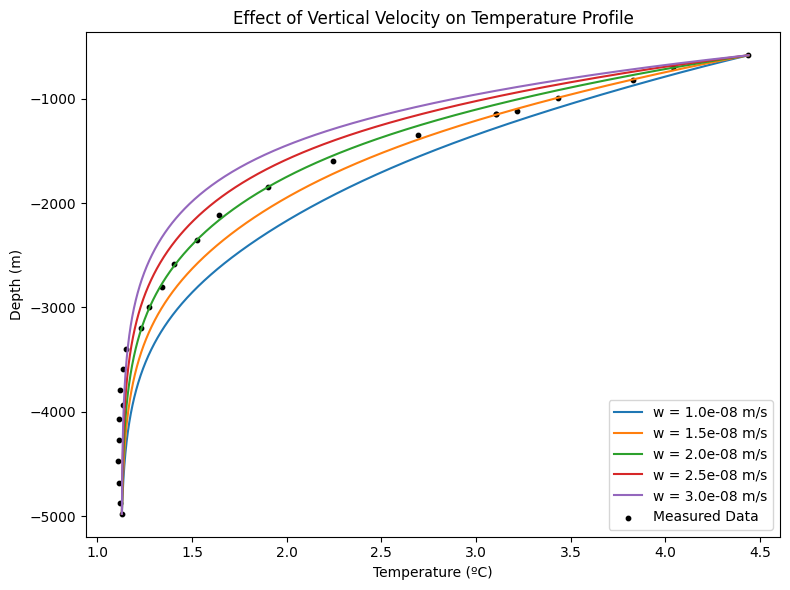

w = 1.0e-08 m/s, Error = 4.169
w = 1.5e-08 m/s, Error = 1.673
w = 2.0e-08 m/s, Error = 1.513
w = 2.5e-08 m/s, Error = 3.311
w = 3.0e-08 m/s, Error = 5.027


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# List of vertical velocities to test
w_values = np.linspace(1e-8, 3e-8, 5)  # 5 values centered around 7.5e-9 m/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)
kappa = dist.Field(name='kappa', bases=zbasis)

# Set the diffusivity
# Updated diffusivity profile
k_0 = 7.6e-4
k_bg = 2e-5
l = 512.5
kappa['g'] = k_bg + (k_0 - k_bg) * np.exp((-5e3 - z) / l)  # m^2/s

# Store errors for each w
errors = []

plt.figure(figsize=(8, 6))

for w in w_values:
    # Add two tau variables to allow us to apply two boundary conditions
    tau_1 = dist.Field(name='tau_1')
    tau_2 = dist.Field(name='tau_2')
    lift_basis = zbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)

    # Substitutions
    dz = lambda A: d3.Differentiate(A, zcoord)
    Tz = dz(T) + lift(tau_1)
    Tzz = dz(Tz) + lift(tau_2)

    # Problem
    problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
    problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
    problem.add_equation("T(z=z_surface) = T_surface")
    problem.add_equation("T(z=z_bottom) = T_bottom")

    # Solver
    solver = problem.build_solver()
    solver.solve()

    # Extract the solution
    Tg = T['g']

    # Calculate error
    interpolated_T = np.interp(CTD_z, z, Tg)
    error = np.sum(np.abs(interpolated_T - CTD_T))
    errors.append(error)

    # Plot the solution
    plt.plot(Tg, z, label=f'w = {w:.1e} m/s')

# Plot the observed data
plt.scatter(CTD_T, CTD_z, s=10, c='black', label='Measured Data')

# Add labels and legend
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')
plt.title('Effect of Vertical Velocity on Temperature Profile')
plt.legend()
plt.tight_layout()
plt.show()

# Print errors for each w
for w, error in zip(w_values, errors):
    print(f'w = {w:.1e} m/s, Error = {error:.3f}')


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 5.2e-01/s


2024-12-25 02:04:37,356 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 5.2e-01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.9e+00/s


2024-12-25 02:04:37,548 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.3e+00/s


2024-12-25 02:04:37,772 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.5e+00/s


2024-12-25 02:04:37,924 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.5e+00/s


2024-12-25 02:04:38,092 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.5e+00/s


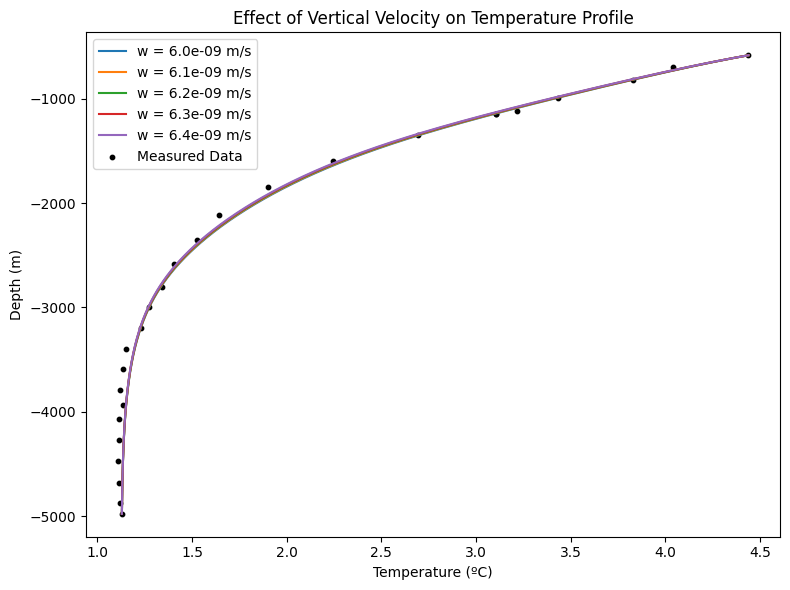

w = 6.0e-09 m/s, Error = 0.771
w = 6.1e-09 m/s, Error = 0.766
w = 6.2e-09 m/s, Error = 0.764
w = 6.3e-09 m/s, Error = 0.774
w = 6.4e-09 m/s, Error = 0.787


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# List of vertical velocities to test
w_values = np.linspace(6e-9, 6.4e-9, 5)  # 5 values centered around 7.5e-9 m/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)
kappa = dist.Field(name='kappa', bases=zbasis)

# Set the diffusivity
# Updated diffusivity profile
k_0 = 1.52e-3  # Double the original k_0
k_bg = 1e-5
l = 512.5
kappa['g'] = k_bg + (k_0 - k_bg) * np.exp((-5e3 - z) / l)  # m^2/s

# Store errors for each w
errors = []

plt.figure(figsize=(8, 6))

for w in w_values:
    # Add two tau variables to allow us to apply two boundary conditions
    tau_1 = dist.Field(name='tau_1')
    tau_2 = dist.Field(name='tau_2')
    lift_basis = zbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)

    # Substitutions
    dz = lambda A: d3.Differentiate(A, zcoord)
    Tz = dz(T) + lift(tau_1)
    Tzz = dz(Tz) + lift(tau_2)

    # Problem
    problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
    problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
    problem.add_equation("T(z=z_surface) = T_surface")
    problem.add_equation("T(z=z_bottom) = T_bottom")

    # Solver
    solver = problem.build_solver()
    solver.solve()

    # Extract the solution
    Tg = T['g']

    # Calculate error
    interpolated_T = np.interp(CTD_z, z, Tg)
    error = np.sum(np.abs(interpolated_T - CTD_T))
    errors.append(error)

    # Plot the solution
    plt.plot(Tg, z, label=f'w = {w:.1e} m/s')

# Plot the observed data
plt.scatter(CTD_T, CTD_z, s=10, c='black', label='Measured Data')

# Add labels and legend
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')
plt.title('Effect of Vertical Velocity on Temperature Profile')
plt.legend()
plt.tight_layout()
plt.show()

# Print errors for each w
for w, error in zip(w_values, errors):
    print(f'w = {w:.1e} m/s, Error = {error:.3f}')


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


2024-12-25 02:08:12,273 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.2e+00/s


2024-12-25 02:08:12,466 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.8e+00/s


2024-12-25 02:08:12,628 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.3e+00/s


2024-12-25 02:08:12,763 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.3e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.5e+00/s


2024-12-25 02:08:12,906 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.5e+00/s


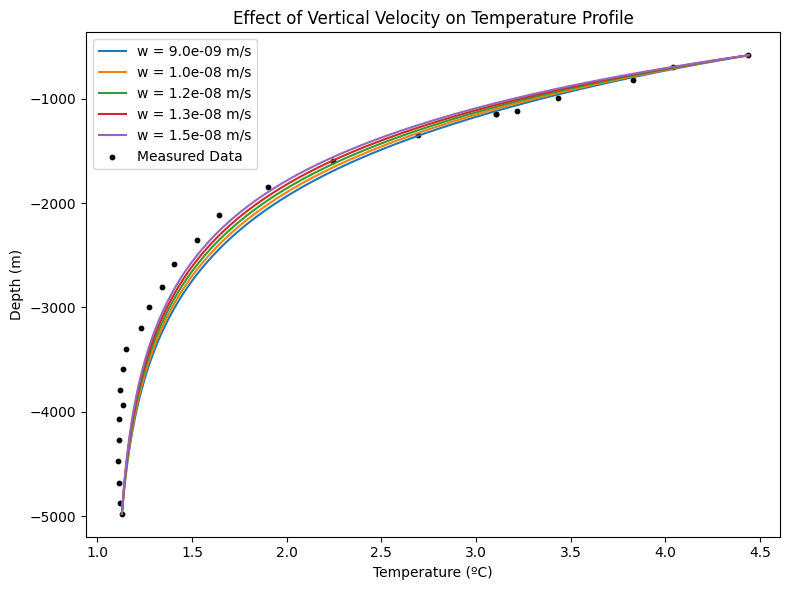

w = 9.0e-09 m/s, Error = 2.379
w = 1.0e-08 m/s, Error = 2.321
w = 1.2e-08 m/s, Error = 2.307
w = 1.3e-08 m/s, Error = 2.311
w = 1.5e-08 m/s, Error = 2.418


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# List of vertical velocities to test
w_values = np.linspace(9e-9, 1.5e-8, 5)  # 5 values centered around 7.5e-9 m/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)
kappa = dist.Field(name='kappa', bases=zbasis)

# Set the diffusivity
# Updated diffusivity profile
k_0 = 7.6e-4  # Reset k_0 to original
k_bg = 1e-5
l = 1025.0  # Double the original l
kappa['g'] = k_bg + (k_0 - k_bg) * np.exp((-5e3 - z) / l)  # m^2/s

# Store errors for each w
errors = []

plt.figure(figsize=(8, 6))

for w in w_values:
    # Add two tau variables to allow us to apply two boundary conditions
    tau_1 = dist.Field(name='tau_1')
    tau_2 = dist.Field(name='tau_2')
    lift_basis = zbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)

    # Substitutions
    dz = lambda A: d3.Differentiate(A, zcoord)
    Tz = dz(T) + lift(tau_1)
    Tzz = dz(Tz) + lift(tau_2)

    # Problem
    problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
    problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
    problem.add_equation("T(z=z_surface) = T_surface")
    problem.add_equation("T(z=z_bottom) = T_bottom")

    # Solver
    solver = problem.build_solver()
    solver.solve()

    # Extract the solution
    Tg = T['g']

    # Calculate error
    interpolated_T = np.interp(CTD_z, z, Tg)
    error = np.sum(np.abs(interpolated_T - CTD_T))
    errors.append(error)

    # Plot the solution
    plt.plot(Tg, z, label=f'w = {w:.1e} m/s')

# Plot the observed data
plt.scatter(CTD_T, CTD_z, s=10, c='black', label='Measured Data')

# Add labels and legend
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')
plt.title('Effect of Vertical Velocity on Temperature Profile')
plt.legend()
plt.tight_layout()
plt.show()

# Print errors for each w
for w, error in zip(w_values, errors):
    print(f'w = {w:.1e} m/s, Error = {error:.3f}')


## 2. Transport of pollution in a river

Advection/diffusion equations are a common way to model the material transport in many physical systems. In this section we will model the transport and dilution of a pollutants added to a river.

For simplicity, we will model the river as a rectangular channel, and we will neglect depth variations. Let $x$ be the coordinate along the length of the river, and $y$ be the cross-stream coordinate. We will model the river current as

$$ u(y) = U_0\left(1-\frac{(y-w/2)^2}{(w/2)^2}\right) $$

where $w$ is the width of the river and $U_0$ is the maximum current speed which occurs at the center of the river (the $y$-coordinate will run from 0 to $w$).

Since we want to know how the pollution levels vary in time, we will solve the time-dependent advection/diffusion equation. We will model the addition of pollution by adding a spatially-dependent source term to the right hand side of the equation governing pollutant concentration:

$$ \frac{\partial c}{\partial t} + u(y)\frac{\partial c}{\partial x} = \kappa \nabla^2 c + S(x,y) $$

where $\nabla^2=(\partial_x^2 + \partial_y^2)$ is the Laplacian operator for diffusion in 2D Cartesian coordinates, and $S$ is the source term.

### 2.1 Dedalus script

The script below solves the time-dependent advection/diffusion equation with a source term.

In [80]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='b', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-12-25 03:31:36,972 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:__main__:Starting main loop


2024-12-25 03:31:36,984 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2024-12-25 03:31:37,040 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2024-12-25 03:31:37,088 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2024-12-25 03:31:37,132 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2024-12-25 03:31:37,177 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2024-12-25 03:31:37,222 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2024-12-25 03:31:37,268 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2024-12-25 03:31:37,314 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2024-12-25 03:31:37,362 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2024-12-25 03:31:37,414 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2024-12-25 03:31:37,460 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2024-12-25 03:31:37,529 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2024-12-25 03:31:37,575 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2024-12-25 03:31:37,636 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2024-12-25 03:31:37,686 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2024-12-25 03:31:37,731 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2024-12-25 03:31:37,800 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2024-12-25 03:31:37,870 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2024-12-25 03:31:37,915 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2024-12-25 03:31:37,978 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2024-12-25 03:31:38,027 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2024-12-25 03:31:38,085 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2024-12-25 03:31:38,131 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2024-12-25 03:31:38,185 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2024-12-25 03:31:38,224 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2024-12-25 03:31:38,254 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2024-12-25 03:31:38,286 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2024-12-25 03:31:38,316 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2024-12-25 03:31:38,346 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2024-12-25 03:31:38,378 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2024-12-25 03:31:38,411 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2024-12-25 03:31:38,446 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2024-12-25 03:31:38,478 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2024-12-25 03:31:38,509 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2024-12-25 03:31:38,552 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2024-12-25 03:31:38,581 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2024-12-25 03:31:38,610 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2024-12-25 03:31:38,640 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2024-12-25 03:31:38,677 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2024-12-25 03:31:38,710 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2024-12-25 03:31:38,744 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2024-12-25 03:31:38,788 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2024-12-25 03:31:38,825 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2024-12-25 03:31:38,867 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2024-12-25 03:31:38,905 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2024-12-25 03:31:38,945 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2024-12-25 03:31:38,987 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2024-12-25 03:31:39,019 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2024-12-25 03:31:39,050 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2024-12-25 03:31:39,080 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2024-12-25 03:31:39,110 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2024-12-25 03:31:39,145 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2024-12-25 03:31:39,175 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2024-12-25 03:31:39,205 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2024-12-25 03:31:39,239 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2024-12-25 03:31:39,269 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2024-12-25 03:31:39,300 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2024-12-25 03:31:39,334 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2024-12-25 03:31:39,366 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2024-12-25 03:31:39,398 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2024-12-25 03:31:39,430 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2024-12-25 03:31:39,462 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2024-12-25 03:31:39,493 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2024-12-25 03:31:39,524 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2024-12-25 03:31:39,563 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2024-12-25 03:31:39,602 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2024-12-25 03:31:39,632 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2024-12-25 03:31:39,664 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2024-12-25 03:31:39,695 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2024-12-25 03:31:39,726 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2024-12-25 03:31:39,766 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2024-12-25 03:31:39,811 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2024-12-25 03:31:39,853 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2024-12-25 03:31:39,893 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2024-12-25 03:31:39,934 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2024-12-25 03:31:39,976 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2024-12-25 03:31:40,015 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2024-12-25 03:31:40,055 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2024-12-25 03:31:40,087 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-25 03:31:40,094 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-25 03:31:40,100 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.4933 sec


2024-12-25 03:31:40,102 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4933 sec


INFO:solvers:Warmup time (iter 0-10): 0.09 sec


2024-12-25 03:31:40,107 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.09 sec


INFO:solvers:Run time (iter 10-end): 3.009 sec


2024-12-25 03:31:40,109 solvers 0/1 INFO :: Run time (iter 10-end): 3.009 sec


INFO:solvers:CPU time (iter 10-end): 0.0008359 cpu-hr


2024-12-25 03:31:40,115 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0008359 cpu-hr


INFO:solvers:Speed: 4.368e+06 mode-stages/cpu-sec


2024-12-25 03:31:40,117 solvers 0/1 INFO :: Speed: 4.368e+06 mode-stages/cpu-sec


## 2.2 Visualization

The script below makes a movie of the results from the saved variables. To run this, you need to have ffmpeg installed.  If you don't already have it installed, you can install ffmpeg with the command:

`conda install -c conda-forge ffmpeg`

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-25 02:55:21,023 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp9d5ke_y4/temp.m4v


2024-12-25 02:55:21,030 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp9d5ke_y4/temp.m4v


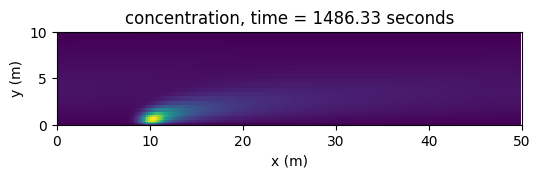

In [56]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)
    plt.ylim(0, w)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

## 2.3 Student investigation
<a id='section2pt3'></a>
In the boxes below, plot the pollution concentration at a few points as a function of time. Then vary the maximum flow speed and the diffusivity and explore how the pollution levels depend on these parameters. Using dimensional analysis, estimate the time needed for the pollution to reach the opposite side of the river. How far downstream of the source do you expect this to happen (assuming that the domain in the x-direction is infinite).

From the plot, we can observe that higher speed and smaller diffusivity result in faster pollutant transport, as higher concentrations of pollutants are observed in the profiles. Higher flow speeds lead to faster advection, quickly transporting pollutants downstream and concentrating them along the flow direction. Lower diffusivity reduces the spreading of pollutants, keeping concentrations more localized and higher. The interplay between advection and diffusion determines pollutant distribution, with advection dominating at high flow speeds and low diffusivity.

As advection, associated with flow speed, dominates in the $x$-direction, it can be neglected when considering the pollutant reaching the other side of the river in the $y$-direction. In the $y$-direction, diffusion dominates, and the diffusion time scale is $t_{diff} \sim w^2 / \kappa$. Given $w = 10\, \text{m}$ and $\kappa = 1 \times 10^{-2} \, \text{m}^2/\text{s}$, $t_{diff} = 10,000 \, \text{s}$ (2.78 hours).

At this time, in the advection-dominated $x$-direction (downstream), the advection is governed by $U_0$. The downstream distance $L$ is proportional to the product of flow velocity $u$ and advection time $t$, i.e., $L \sim u \cdot t$. With $t = 10,000 \, \text{s}$ and defining $U_0 = 0.1 \, \text{m/s}$, the pollutant is expected to travel $L = 1,000 \, \text{m}$ downstream.

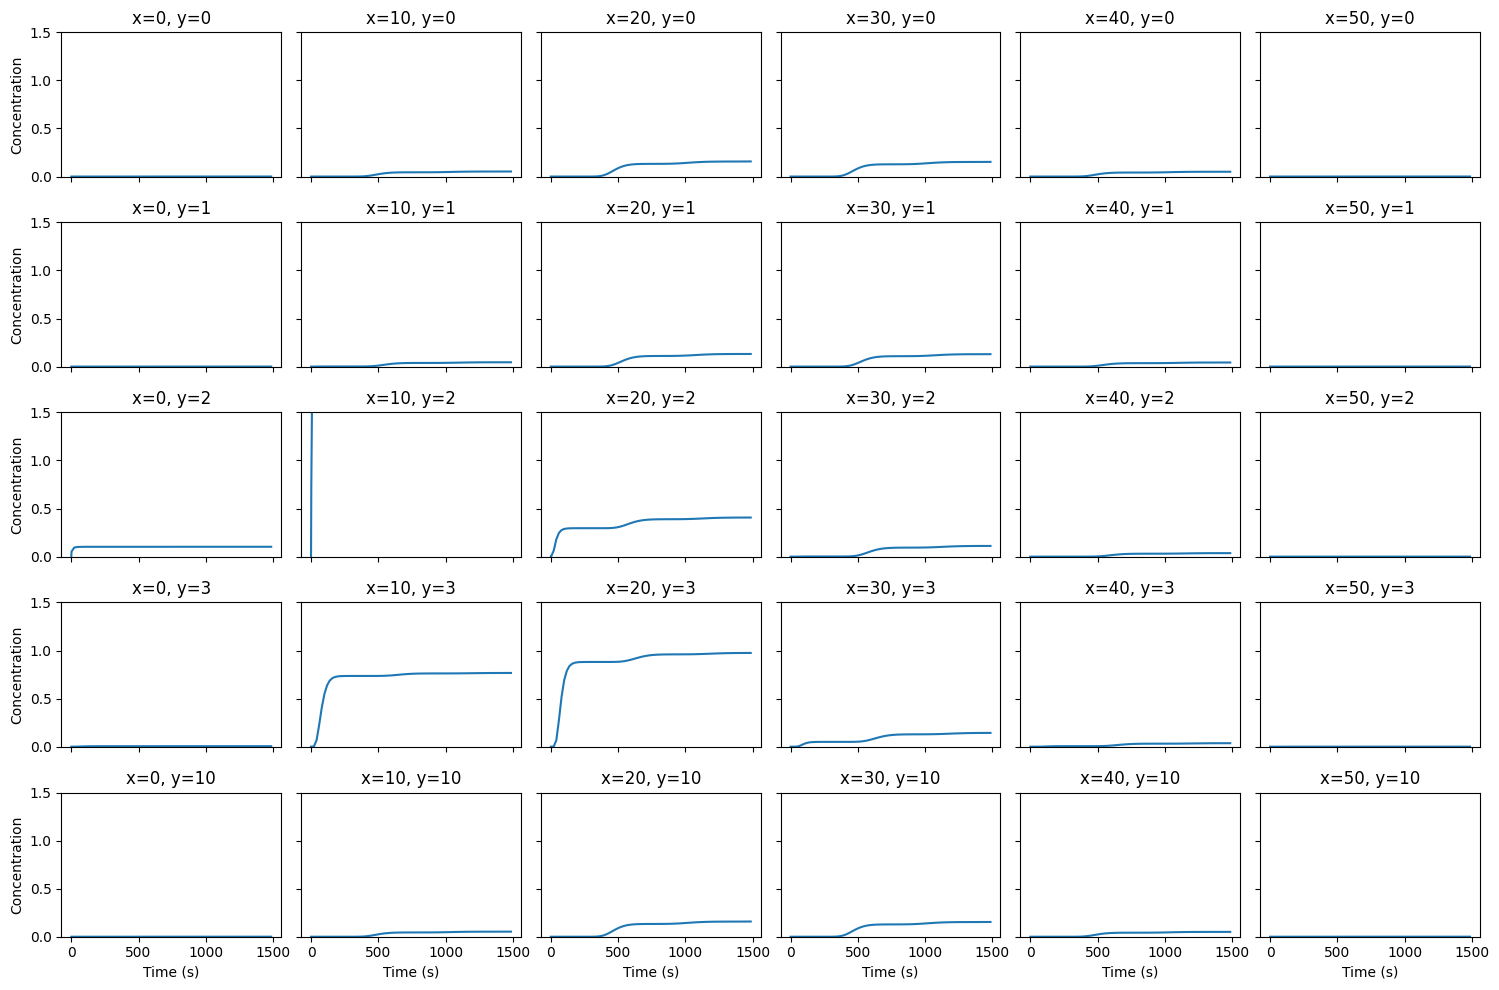

In [91]:
import numpy as np
import matplotlib.pyplot as plt

# Define the list of x and y coordinates to analyze
x_points = [0, 10, 20, 30, 40, 50]
y_points = [0, 1,2,3, 10]

# Ensure c_save and t_save are available as numpy arrays
c_save = np.array(c_save)  # 3D array with time, y, x dimensions
t_save = np.array(t_save)  # Time points array

# Extract the x and y grid arrays
x_coords = np.linspace(0, L, c_save.shape[2])
y_coords = np.linspace(0, w, c_save.shape[1])

# Initialize a dictionary to store concentration data
concentration_data = {}

# Loop through each pair of x and y points
for x_point in x_points:
    for y_point in y_points:
        # Find the nearest indices for the specified x and y points
        x_idx = np.argmin(np.abs(x_coords - x_point))
        y_idx = np.argmin(np.abs(y_coords - y_point))

        # Extract the concentration time series at the specified point
        concentration_series = c_save[:, y_idx, x_idx]

        # Save the data in the dictionary with keys as coordinates
        concentration_data[(x_point, y_point)] = concentration_series


# Plot the datasets as subplots
fig, axes = plt.subplots(len(y_points), len(x_points), figsize=(15, 10), sharex=True, sharey=True)

for i, y_point in enumerate(y_points):
    for j, x_point in enumerate(x_points):
        ax = axes[i, j]

        # Retrieve the concentration data for the current pair
        series = concentration_data[(x_point, y_point)]

        # Plot the data in the subplot
        ax.plot(t_save, series)
        ax.set_title(f"x={x_point}, y={y_point}")

        # Label the axes
        if i == len(y_points) - 1:
            ax.set_xlabel('Time (s)')
        if j == 0:
            ax.set_ylabel('Concentration')
        ax.set_ylim(0, 1.5)

# Adjust layout
plt.tight_layout()
plt.show()


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


2024-12-25 03:54:47,588 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


INFO:__main__:Starting main loop


2024-12-25 03:54:47,599 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2024-12-25 03:54:47,649 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2024-12-25 03:54:47,684 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2024-12-25 03:54:47,714 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2024-12-25 03:54:47,748 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2024-12-25 03:54:47,785 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2024-12-25 03:54:47,821 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2024-12-25 03:54:47,853 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2024-12-25 03:54:47,886 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2024-12-25 03:54:47,915 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2024-12-25 03:54:47,945 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2024-12-25 03:54:47,981 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2024-12-25 03:54:48,011 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2024-12-25 03:54:48,042 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2024-12-25 03:54:48,073 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2024-12-25 03:54:48,103 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2024-12-25 03:54:48,137 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2024-12-25 03:54:48,175 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2024-12-25 03:54:48,211 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2024-12-25 03:54:48,241 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2024-12-25 03:54:48,270 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2024-12-25 03:54:48,300 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2024-12-25 03:54:48,330 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2024-12-25 03:54:48,362 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2024-12-25 03:54:48,392 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2024-12-25 03:54:48,423 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2024-12-25 03:54:48,452 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2024-12-25 03:54:48,482 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2024-12-25 03:54:48,511 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2024-12-25 03:54:48,543 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2024-12-25 03:54:48,573 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2024-12-25 03:54:48,604 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2024-12-25 03:54:48,634 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2024-12-25 03:54:48,668 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2024-12-25 03:54:48,703 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2024-12-25 03:54:48,735 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2024-12-25 03:54:48,772 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2024-12-25 03:54:48,807 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2024-12-25 03:54:48,847 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2024-12-25 03:54:48,889 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2024-12-25 03:54:48,927 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2024-12-25 03:54:48,968 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2024-12-25 03:54:49,005 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2024-12-25 03:54:49,041 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2024-12-25 03:54:49,081 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2024-12-25 03:54:49,121 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2024-12-25 03:54:49,160 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2024-12-25 03:54:49,213 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2024-12-25 03:54:49,250 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2024-12-25 03:54:49,279 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2024-12-25 03:54:49,310 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2024-12-25 03:54:49,343 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2024-12-25 03:54:49,373 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2024-12-25 03:54:49,411 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2024-12-25 03:54:49,442 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2024-12-25 03:54:49,472 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2024-12-25 03:54:49,507 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2024-12-25 03:54:49,539 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2024-12-25 03:54:49,570 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2024-12-25 03:54:49,602 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2024-12-25 03:54:49,631 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2024-12-25 03:54:49,662 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2024-12-25 03:54:49,701 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2024-12-25 03:54:49,731 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2024-12-25 03:54:49,769 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2024-12-25 03:54:49,809 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2024-12-25 03:54:49,847 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2024-12-25 03:54:49,888 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2024-12-25 03:54:49,927 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2024-12-25 03:54:49,962 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2024-12-25 03:54:49,994 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2024-12-25 03:54:50,026 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2024-12-25 03:54:50,056 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2024-12-25 03:54:50,093 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2024-12-25 03:54:50,124 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2024-12-25 03:54:50,155 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2024-12-25 03:54:50,185 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2024-12-25 03:54:50,216 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2024-12-25 03:54:50,247 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-25 03:54:50,253 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-25 03:54:50,257 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.3701 sec


2024-12-25 03:54:50,260 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3701 sec


INFO:solvers:Warmup time (iter 0-10): 0.0677 sec


2024-12-25 03:54:50,263 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0677 sec


INFO:solvers:Run time (iter 10-end): 2.572 sec


2024-12-25 03:54:50,268 solvers 0/1 INFO :: Run time (iter 10-end): 2.572 sec


INFO:solvers:CPU time (iter 10-end): 0.0007144 cpu-hr


2024-12-25 03:54:50,274 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0007144 cpu-hr


INFO:solvers:Speed: 5.111e+06 mode-stages/cpu-sec


2024-12-25 03:54:50,277 solvers 0/1 INFO :: Speed: 5.111e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+00/s


2024-12-25 03:54:50,589 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+00/s


INFO:__main__:Starting main loop


2024-12-25 03:54:50,597 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=6.510417e-01, dt=6.510417e-01


2024-12-25 03:54:50,635 __main__ 0/1 INFO :: Iteration=1, Time=6.510417e-01, dt=6.510417e-01


INFO:__main__:Iteration=11, Time=7.161458e+00, dt=6.510417e-01


2024-12-25 03:54:50,666 __main__ 0/1 INFO :: Iteration=11, Time=7.161458e+00, dt=6.510417e-01


INFO:__main__:Iteration=21, Time=1.367187e+01, dt=6.510417e-01


2024-12-25 03:54:50,698 __main__ 0/1 INFO :: Iteration=21, Time=1.367187e+01, dt=6.510417e-01


INFO:__main__:Iteration=31, Time=2.018229e+01, dt=6.510417e-01


2024-12-25 03:54:50,729 __main__ 0/1 INFO :: Iteration=31, Time=2.018229e+01, dt=6.510417e-01


INFO:__main__:Iteration=41, Time=2.669271e+01, dt=6.510417e-01


2024-12-25 03:54:50,769 __main__ 0/1 INFO :: Iteration=41, Time=2.669271e+01, dt=6.510417e-01


INFO:__main__:Iteration=51, Time=3.320313e+01, dt=6.510417e-01


2024-12-25 03:54:50,812 __main__ 0/1 INFO :: Iteration=51, Time=3.320313e+01, dt=6.510417e-01


INFO:__main__:Iteration=61, Time=3.971354e+01, dt=6.510417e-01


2024-12-25 03:54:50,857 __main__ 0/1 INFO :: Iteration=61, Time=3.971354e+01, dt=6.510417e-01


INFO:__main__:Iteration=71, Time=4.622396e+01, dt=6.510417e-01


2024-12-25 03:54:50,895 __main__ 0/1 INFO :: Iteration=71, Time=4.622396e+01, dt=6.510417e-01


INFO:__main__:Iteration=81, Time=5.273437e+01, dt=6.510417e-01


2024-12-25 03:54:50,934 __main__ 0/1 INFO :: Iteration=81, Time=5.273437e+01, dt=6.510417e-01


INFO:__main__:Iteration=91, Time=5.924479e+01, dt=6.510417e-01


2024-12-25 03:54:50,974 __main__ 0/1 INFO :: Iteration=91, Time=5.924479e+01, dt=6.510417e-01


INFO:__main__:Iteration=101, Time=6.575521e+01, dt=6.510417e-01


2024-12-25 03:54:51,015 __main__ 0/1 INFO :: Iteration=101, Time=6.575521e+01, dt=6.510417e-01


INFO:__main__:Iteration=111, Time=7.226562e+01, dt=6.510417e-01


2024-12-25 03:54:51,058 __main__ 0/1 INFO :: Iteration=111, Time=7.226562e+01, dt=6.510417e-01


INFO:__main__:Iteration=121, Time=7.877604e+01, dt=6.510417e-01


2024-12-25 03:54:51,094 __main__ 0/1 INFO :: Iteration=121, Time=7.877604e+01, dt=6.510417e-01


INFO:__main__:Iteration=131, Time=8.528646e+01, dt=6.510417e-01


2024-12-25 03:54:51,124 __main__ 0/1 INFO :: Iteration=131, Time=8.528646e+01, dt=6.510417e-01


INFO:__main__:Iteration=141, Time=9.179688e+01, dt=6.510417e-01


2024-12-25 03:54:51,154 __main__ 0/1 INFO :: Iteration=141, Time=9.179688e+01, dt=6.510417e-01


INFO:__main__:Iteration=151, Time=9.830729e+01, dt=6.510417e-01


2024-12-25 03:54:51,184 __main__ 0/1 INFO :: Iteration=151, Time=9.830729e+01, dt=6.510417e-01


INFO:__main__:Iteration=161, Time=1.048177e+02, dt=6.510417e-01


2024-12-25 03:54:51,214 __main__ 0/1 INFO :: Iteration=161, Time=1.048177e+02, dt=6.510417e-01


INFO:__main__:Iteration=171, Time=1.113281e+02, dt=6.510417e-01


2024-12-25 03:54:51,248 __main__ 0/1 INFO :: Iteration=171, Time=1.113281e+02, dt=6.510417e-01


INFO:__main__:Iteration=181, Time=1.178385e+02, dt=6.510417e-01


2024-12-25 03:54:51,280 __main__ 0/1 INFO :: Iteration=181, Time=1.178385e+02, dt=6.510417e-01


INFO:__main__:Iteration=191, Time=1.243490e+02, dt=6.510417e-01


2024-12-25 03:54:51,322 __main__ 0/1 INFO :: Iteration=191, Time=1.243490e+02, dt=6.510417e-01


INFO:__main__:Iteration=201, Time=1.308594e+02, dt=6.510417e-01


2024-12-25 03:54:51,354 __main__ 0/1 INFO :: Iteration=201, Time=1.308594e+02, dt=6.510417e-01


INFO:__main__:Iteration=211, Time=1.373698e+02, dt=6.510417e-01


2024-12-25 03:54:51,384 __main__ 0/1 INFO :: Iteration=211, Time=1.373698e+02, dt=6.510417e-01


INFO:__main__:Iteration=221, Time=1.438802e+02, dt=6.510417e-01


2024-12-25 03:54:51,414 __main__ 0/1 INFO :: Iteration=221, Time=1.438802e+02, dt=6.510417e-01


INFO:__main__:Iteration=231, Time=1.503906e+02, dt=6.510417e-01


2024-12-25 03:54:51,449 __main__ 0/1 INFO :: Iteration=231, Time=1.503906e+02, dt=6.510417e-01


INFO:__main__:Iteration=241, Time=1.569010e+02, dt=6.510417e-01


2024-12-25 03:54:51,478 __main__ 0/1 INFO :: Iteration=241, Time=1.569010e+02, dt=6.510417e-01


INFO:__main__:Iteration=251, Time=1.634115e+02, dt=6.510417e-01


2024-12-25 03:54:51,509 __main__ 0/1 INFO :: Iteration=251, Time=1.634115e+02, dt=6.510417e-01


INFO:__main__:Iteration=261, Time=1.699219e+02, dt=6.510417e-01


2024-12-25 03:54:51,539 __main__ 0/1 INFO :: Iteration=261, Time=1.699219e+02, dt=6.510417e-01


INFO:__main__:Iteration=271, Time=1.764323e+02, dt=6.510417e-01


2024-12-25 03:54:51,569 __main__ 0/1 INFO :: Iteration=271, Time=1.764323e+02, dt=6.510417e-01


INFO:__main__:Iteration=281, Time=1.829427e+02, dt=6.510417e-01


2024-12-25 03:54:51,599 __main__ 0/1 INFO :: Iteration=281, Time=1.829427e+02, dt=6.510417e-01


INFO:__main__:Iteration=291, Time=1.894531e+02, dt=6.510417e-01


2024-12-25 03:54:51,631 __main__ 0/1 INFO :: Iteration=291, Time=1.894531e+02, dt=6.510417e-01


INFO:__main__:Iteration=301, Time=1.959635e+02, dt=6.510417e-01


2024-12-25 03:54:51,665 __main__ 0/1 INFO :: Iteration=301, Time=1.959635e+02, dt=6.510417e-01


INFO:__main__:Iteration=311, Time=2.024740e+02, dt=6.510417e-01


2024-12-25 03:54:51,696 __main__ 0/1 INFO :: Iteration=311, Time=2.024740e+02, dt=6.510417e-01


INFO:__main__:Iteration=321, Time=2.089844e+02, dt=6.510417e-01


2024-12-25 03:54:51,726 __main__ 0/1 INFO :: Iteration=321, Time=2.089844e+02, dt=6.510417e-01


INFO:__main__:Iteration=331, Time=2.154948e+02, dt=6.510417e-01


2024-12-25 03:54:51,764 __main__ 0/1 INFO :: Iteration=331, Time=2.154948e+02, dt=6.510417e-01


INFO:__main__:Iteration=341, Time=2.220052e+02, dt=6.510417e-01


2024-12-25 03:54:51,805 __main__ 0/1 INFO :: Iteration=341, Time=2.220052e+02, dt=6.510417e-01


INFO:__main__:Iteration=351, Time=2.285156e+02, dt=6.510417e-01


2024-12-25 03:54:51,846 __main__ 0/1 INFO :: Iteration=351, Time=2.285156e+02, dt=6.510417e-01


INFO:__main__:Iteration=361, Time=2.350260e+02, dt=6.510417e-01


2024-12-25 03:54:51,885 __main__ 0/1 INFO :: Iteration=361, Time=2.350260e+02, dt=6.510417e-01


INFO:__main__:Iteration=371, Time=2.415365e+02, dt=6.510417e-01


2024-12-25 03:54:51,929 __main__ 0/1 INFO :: Iteration=371, Time=2.415365e+02, dt=6.510417e-01


INFO:__main__:Iteration=381, Time=2.480469e+02, dt=6.510417e-01


2024-12-25 03:54:51,970 __main__ 0/1 INFO :: Iteration=381, Time=2.480469e+02, dt=6.510417e-01


INFO:__main__:Iteration=391, Time=2.545573e+02, dt=6.510417e-01


2024-12-25 03:54:52,011 __main__ 0/1 INFO :: Iteration=391, Time=2.545573e+02, dt=6.510417e-01


INFO:__main__:Iteration=401, Time=2.610677e+02, dt=6.510417e-01


2024-12-25 03:54:52,063 __main__ 0/1 INFO :: Iteration=401, Time=2.610677e+02, dt=6.510417e-01


INFO:__main__:Iteration=411, Time=2.675781e+02, dt=6.510417e-01


2024-12-25 03:54:52,113 __main__ 0/1 INFO :: Iteration=411, Time=2.675781e+02, dt=6.510417e-01


INFO:__main__:Iteration=421, Time=2.740885e+02, dt=6.510417e-01


2024-12-25 03:54:52,165 __main__ 0/1 INFO :: Iteration=421, Time=2.740885e+02, dt=6.510417e-01


INFO:__main__:Iteration=431, Time=2.805990e+02, dt=6.510417e-01


2024-12-25 03:54:52,222 __main__ 0/1 INFO :: Iteration=431, Time=2.805990e+02, dt=6.510417e-01


INFO:__main__:Iteration=441, Time=2.871094e+02, dt=6.510417e-01


2024-12-25 03:54:52,276 __main__ 0/1 INFO :: Iteration=441, Time=2.871094e+02, dt=6.510417e-01


INFO:__main__:Iteration=451, Time=2.936198e+02, dt=6.510417e-01


2024-12-25 03:54:52,355 __main__ 0/1 INFO :: Iteration=451, Time=2.936198e+02, dt=6.510417e-01


INFO:__main__:Iteration=461, Time=3.001302e+02, dt=6.510417e-01


2024-12-25 03:54:52,406 __main__ 0/1 INFO :: Iteration=461, Time=3.001302e+02, dt=6.510417e-01


INFO:__main__:Iteration=471, Time=3.066406e+02, dt=6.510417e-01


2024-12-25 03:54:52,477 __main__ 0/1 INFO :: Iteration=471, Time=3.066406e+02, dt=6.510417e-01


INFO:__main__:Iteration=481, Time=3.131510e+02, dt=6.510417e-01


2024-12-25 03:54:52,585 __main__ 0/1 INFO :: Iteration=481, Time=3.131510e+02, dt=6.510417e-01


INFO:__main__:Iteration=491, Time=3.196615e+02, dt=6.510417e-01


2024-12-25 03:54:52,719 __main__ 0/1 INFO :: Iteration=491, Time=3.196615e+02, dt=6.510417e-01


INFO:__main__:Iteration=501, Time=3.261719e+02, dt=6.510417e-01


2024-12-25 03:54:52,907 __main__ 0/1 INFO :: Iteration=501, Time=3.261719e+02, dt=6.510417e-01


INFO:__main__:Iteration=511, Time=3.326823e+02, dt=6.510417e-01


2024-12-25 03:54:53,027 __main__ 0/1 INFO :: Iteration=511, Time=3.326823e+02, dt=6.510417e-01


INFO:__main__:Iteration=521, Time=3.391927e+02, dt=6.510417e-01


2024-12-25 03:54:53,128 __main__ 0/1 INFO :: Iteration=521, Time=3.391927e+02, dt=6.510417e-01


INFO:__main__:Iteration=531, Time=3.457031e+02, dt=6.510417e-01


2024-12-25 03:54:53,301 __main__ 0/1 INFO :: Iteration=531, Time=3.457031e+02, dt=6.510417e-01


INFO:__main__:Iteration=541, Time=3.522135e+02, dt=6.510417e-01


2024-12-25 03:54:53,464 __main__ 0/1 INFO :: Iteration=541, Time=3.522135e+02, dt=6.510417e-01


INFO:__main__:Iteration=551, Time=3.587240e+02, dt=6.510417e-01


2024-12-25 03:54:53,599 __main__ 0/1 INFO :: Iteration=551, Time=3.587240e+02, dt=6.510417e-01


INFO:__main__:Iteration=561, Time=3.652344e+02, dt=6.510417e-01


2024-12-25 03:54:53,734 __main__ 0/1 INFO :: Iteration=561, Time=3.652344e+02, dt=6.510417e-01


INFO:__main__:Iteration=571, Time=3.717448e+02, dt=6.510417e-01


2024-12-25 03:54:53,878 __main__ 0/1 INFO :: Iteration=571, Time=3.717448e+02, dt=6.510417e-01


INFO:__main__:Iteration=581, Time=3.782552e+02, dt=6.510417e-01


2024-12-25 03:54:54,024 __main__ 0/1 INFO :: Iteration=581, Time=3.782552e+02, dt=6.510417e-01


INFO:__main__:Iteration=591, Time=3.847656e+02, dt=6.510417e-01


2024-12-25 03:54:54,112 __main__ 0/1 INFO :: Iteration=591, Time=3.847656e+02, dt=6.510417e-01


INFO:__main__:Iteration=601, Time=3.912760e+02, dt=6.510417e-01


2024-12-25 03:54:54,199 __main__ 0/1 INFO :: Iteration=601, Time=3.912760e+02, dt=6.510417e-01


INFO:__main__:Iteration=611, Time=3.977865e+02, dt=6.510417e-01


2024-12-25 03:54:54,312 __main__ 0/1 INFO :: Iteration=611, Time=3.977865e+02, dt=6.510417e-01


INFO:__main__:Iteration=621, Time=4.042969e+02, dt=6.510417e-01


2024-12-25 03:54:54,394 __main__ 0/1 INFO :: Iteration=621, Time=4.042969e+02, dt=6.510417e-01


INFO:__main__:Iteration=631, Time=4.108073e+02, dt=6.510417e-01


2024-12-25 03:54:54,485 __main__ 0/1 INFO :: Iteration=631, Time=4.108073e+02, dt=6.510417e-01


INFO:__main__:Iteration=641, Time=4.173177e+02, dt=6.510417e-01


2024-12-25 03:54:54,574 __main__ 0/1 INFO :: Iteration=641, Time=4.173177e+02, dt=6.510417e-01


INFO:__main__:Iteration=651, Time=4.238281e+02, dt=6.510417e-01


2024-12-25 03:54:54,709 __main__ 0/1 INFO :: Iteration=651, Time=4.238281e+02, dt=6.510417e-01


INFO:__main__:Iteration=661, Time=4.303385e+02, dt=6.510417e-01


2024-12-25 03:54:54,796 __main__ 0/1 INFO :: Iteration=661, Time=4.303385e+02, dt=6.510417e-01


INFO:__main__:Iteration=671, Time=4.368490e+02, dt=6.510417e-01


2024-12-25 03:54:54,842 __main__ 0/1 INFO :: Iteration=671, Time=4.368490e+02, dt=6.510417e-01


INFO:__main__:Iteration=681, Time=4.433594e+02, dt=6.510417e-01


2024-12-25 03:54:54,887 __main__ 0/1 INFO :: Iteration=681, Time=4.433594e+02, dt=6.510417e-01


INFO:__main__:Iteration=691, Time=4.498698e+02, dt=6.510417e-01


2024-12-25 03:54:54,929 __main__ 0/1 INFO :: Iteration=691, Time=4.498698e+02, dt=6.510417e-01


INFO:__main__:Iteration=701, Time=4.563802e+02, dt=6.510417e-01


2024-12-25 03:54:54,988 __main__ 0/1 INFO :: Iteration=701, Time=4.563802e+02, dt=6.510417e-01


INFO:__main__:Iteration=711, Time=4.628906e+02, dt=6.510417e-01


2024-12-25 03:54:55,053 __main__ 0/1 INFO :: Iteration=711, Time=4.628906e+02, dt=6.510417e-01


INFO:__main__:Iteration=721, Time=4.694010e+02, dt=6.510417e-01


2024-12-25 03:54:55,116 __main__ 0/1 INFO :: Iteration=721, Time=4.694010e+02, dt=6.510417e-01


INFO:__main__:Iteration=731, Time=4.759115e+02, dt=6.510417e-01


2024-12-25 03:54:55,192 __main__ 0/1 INFO :: Iteration=731, Time=4.759115e+02, dt=6.510417e-01


INFO:__main__:Iteration=741, Time=4.824219e+02, dt=6.510417e-01


2024-12-25 03:54:55,271 __main__ 0/1 INFO :: Iteration=741, Time=4.824219e+02, dt=6.510417e-01


INFO:__main__:Iteration=751, Time=4.889323e+02, dt=6.510417e-01


2024-12-25 03:54:55,320 __main__ 0/1 INFO :: Iteration=751, Time=4.889323e+02, dt=6.510417e-01


INFO:__main__:Iteration=761, Time=4.954427e+02, dt=6.510417e-01


2024-12-25 03:54:55,408 __main__ 0/1 INFO :: Iteration=761, Time=4.954427e+02, dt=6.510417e-01


INFO:__main__:Iteration=771, Time=5.019531e+02, dt=6.510417e-01


2024-12-25 03:54:55,514 __main__ 0/1 INFO :: Iteration=771, Time=5.019531e+02, dt=6.510417e-01


INFO:__main__:Iteration=781, Time=5.084635e+02, dt=6.510417e-01


2024-12-25 03:54:55,593 __main__ 0/1 INFO :: Iteration=781, Time=5.084635e+02, dt=6.510417e-01


INFO:__main__:Iteration=791, Time=5.149740e+02, dt=6.510417e-01


2024-12-25 03:54:55,645 __main__ 0/1 INFO :: Iteration=791, Time=5.149740e+02, dt=6.510417e-01


INFO:__main__:Iteration=801, Time=5.214844e+02, dt=6.510417e-01


2024-12-25 03:54:55,698 __main__ 0/1 INFO :: Iteration=801, Time=5.214844e+02, dt=6.510417e-01


INFO:__main__:Iteration=811, Time=5.279948e+02, dt=6.510417e-01


2024-12-25 03:54:55,756 __main__ 0/1 INFO :: Iteration=811, Time=5.279948e+02, dt=6.510417e-01


INFO:__main__:Iteration=821, Time=5.345052e+02, dt=6.510417e-01


2024-12-25 03:54:55,821 __main__ 0/1 INFO :: Iteration=821, Time=5.345052e+02, dt=6.510417e-01


INFO:__main__:Iteration=831, Time=5.410156e+02, dt=6.510417e-01


2024-12-25 03:54:55,928 __main__ 0/1 INFO :: Iteration=831, Time=5.410156e+02, dt=6.510417e-01


INFO:__main__:Iteration=841, Time=5.475260e+02, dt=6.510417e-01


2024-12-25 03:54:56,029 __main__ 0/1 INFO :: Iteration=841, Time=5.475260e+02, dt=6.510417e-01


INFO:__main__:Iteration=851, Time=5.540365e+02, dt=6.510417e-01


2024-12-25 03:54:56,117 __main__ 0/1 INFO :: Iteration=851, Time=5.540365e+02, dt=6.510417e-01


INFO:__main__:Iteration=861, Time=5.605469e+02, dt=6.510417e-01


2024-12-25 03:54:56,209 __main__ 0/1 INFO :: Iteration=861, Time=5.605469e+02, dt=6.510417e-01


INFO:__main__:Iteration=871, Time=5.670573e+02, dt=6.510417e-01


2024-12-25 03:54:56,308 __main__ 0/1 INFO :: Iteration=871, Time=5.670573e+02, dt=6.510417e-01


INFO:__main__:Iteration=881, Time=5.735677e+02, dt=6.510417e-01


2024-12-25 03:54:56,394 __main__ 0/1 INFO :: Iteration=881, Time=5.735677e+02, dt=6.510417e-01


INFO:__main__:Iteration=891, Time=5.800781e+02, dt=6.510417e-01


2024-12-25 03:54:56,470 __main__ 0/1 INFO :: Iteration=891, Time=5.800781e+02, dt=6.510417e-01


INFO:__main__:Iteration=901, Time=5.865885e+02, dt=6.510417e-01


2024-12-25 03:54:56,533 __main__ 0/1 INFO :: Iteration=901, Time=5.865885e+02, dt=6.510417e-01


INFO:__main__:Iteration=911, Time=5.930990e+02, dt=6.510417e-01


2024-12-25 03:54:56,625 __main__ 0/1 INFO :: Iteration=911, Time=5.930990e+02, dt=6.510417e-01


INFO:__main__:Iteration=921, Time=5.996094e+02, dt=6.510417e-01


2024-12-25 03:54:56,715 __main__ 0/1 INFO :: Iteration=921, Time=5.996094e+02, dt=6.510417e-01


INFO:__main__:Iteration=931, Time=6.061198e+02, dt=6.510417e-01


2024-12-25 03:54:56,827 __main__ 0/1 INFO :: Iteration=931, Time=6.061198e+02, dt=6.510417e-01


INFO:__main__:Iteration=941, Time=6.126302e+02, dt=6.510417e-01


2024-12-25 03:54:56,917 __main__ 0/1 INFO :: Iteration=941, Time=6.126302e+02, dt=6.510417e-01


INFO:__main__:Iteration=951, Time=6.191406e+02, dt=6.510417e-01


2024-12-25 03:54:57,016 __main__ 0/1 INFO :: Iteration=951, Time=6.191406e+02, dt=6.510417e-01


INFO:__main__:Iteration=961, Time=6.256510e+02, dt=6.510417e-01


2024-12-25 03:54:57,152 __main__ 0/1 INFO :: Iteration=961, Time=6.256510e+02, dt=6.510417e-01


INFO:__main__:Iteration=971, Time=6.321615e+02, dt=6.510417e-01


2024-12-25 03:54:57,263 __main__ 0/1 INFO :: Iteration=971, Time=6.321615e+02, dt=6.510417e-01


INFO:__main__:Iteration=981, Time=6.386719e+02, dt=6.510417e-01


2024-12-25 03:54:57,342 __main__ 0/1 INFO :: Iteration=981, Time=6.386719e+02, dt=6.510417e-01


INFO:__main__:Iteration=991, Time=6.451823e+02, dt=6.510417e-01


2024-12-25 03:54:57,437 __main__ 0/1 INFO :: Iteration=991, Time=6.451823e+02, dt=6.510417e-01


INFO:__main__:Iteration=1001, Time=6.516927e+02, dt=6.510417e-01


2024-12-25 03:54:57,530 __main__ 0/1 INFO :: Iteration=1001, Time=6.516927e+02, dt=6.510417e-01


INFO:__main__:Iteration=1011, Time=6.582031e+02, dt=6.510417e-01


2024-12-25 03:54:57,623 __main__ 0/1 INFO :: Iteration=1011, Time=6.582031e+02, dt=6.510417e-01


INFO:__main__:Iteration=1021, Time=6.647135e+02, dt=6.510417e-01


2024-12-25 03:54:57,767 __main__ 0/1 INFO :: Iteration=1021, Time=6.647135e+02, dt=6.510417e-01


INFO:__main__:Iteration=1031, Time=6.712240e+02, dt=6.510417e-01


2024-12-25 03:54:57,824 __main__ 0/1 INFO :: Iteration=1031, Time=6.712240e+02, dt=6.510417e-01


INFO:__main__:Iteration=1041, Time=6.777344e+02, dt=6.510417e-01


2024-12-25 03:54:57,885 __main__ 0/1 INFO :: Iteration=1041, Time=6.777344e+02, dt=6.510417e-01


INFO:__main__:Iteration=1051, Time=6.842448e+02, dt=6.510417e-01


2024-12-25 03:54:57,938 __main__ 0/1 INFO :: Iteration=1051, Time=6.842448e+02, dt=6.510417e-01


INFO:__main__:Iteration=1061, Time=6.907552e+02, dt=6.510417e-01


2024-12-25 03:54:58,067 __main__ 0/1 INFO :: Iteration=1061, Time=6.907552e+02, dt=6.510417e-01


INFO:__main__:Iteration=1071, Time=6.972656e+02, dt=6.510417e-01


2024-12-25 03:54:58,128 __main__ 0/1 INFO :: Iteration=1071, Time=6.972656e+02, dt=6.510417e-01


INFO:__main__:Iteration=1081, Time=7.037760e+02, dt=6.510417e-01


2024-12-25 03:54:58,175 __main__ 0/1 INFO :: Iteration=1081, Time=7.037760e+02, dt=6.510417e-01


INFO:__main__:Iteration=1091, Time=7.102865e+02, dt=6.510417e-01


2024-12-25 03:54:58,230 __main__ 0/1 INFO :: Iteration=1091, Time=7.102865e+02, dt=6.510417e-01


INFO:__main__:Iteration=1101, Time=7.167969e+02, dt=6.510417e-01


2024-12-25 03:54:58,283 __main__ 0/1 INFO :: Iteration=1101, Time=7.167969e+02, dt=6.510417e-01


INFO:__main__:Iteration=1111, Time=7.233073e+02, dt=6.510417e-01


2024-12-25 03:54:58,332 __main__ 0/1 INFO :: Iteration=1111, Time=7.233073e+02, dt=6.510417e-01


INFO:__main__:Iteration=1121, Time=7.298177e+02, dt=6.510417e-01


2024-12-25 03:54:58,382 __main__ 0/1 INFO :: Iteration=1121, Time=7.298177e+02, dt=6.510417e-01


INFO:__main__:Iteration=1131, Time=7.363281e+02, dt=6.510417e-01


2024-12-25 03:54:58,430 __main__ 0/1 INFO :: Iteration=1131, Time=7.363281e+02, dt=6.510417e-01


INFO:__main__:Iteration=1141, Time=7.428385e+02, dt=6.510417e-01


2024-12-25 03:54:58,478 __main__ 0/1 INFO :: Iteration=1141, Time=7.428385e+02, dt=6.510417e-01


INFO:__main__:Iteration=1151, Time=7.493490e+02, dt=6.510417e-01


2024-12-25 03:54:58,532 __main__ 0/1 INFO :: Iteration=1151, Time=7.493490e+02, dt=6.510417e-01


INFO:__main__:Iteration=1161, Time=7.558594e+02, dt=6.510417e-01


2024-12-25 03:54:58,582 __main__ 0/1 INFO :: Iteration=1161, Time=7.558594e+02, dt=6.510417e-01


INFO:__main__:Iteration=1171, Time=7.623698e+02, dt=6.510417e-01


2024-12-25 03:54:58,637 __main__ 0/1 INFO :: Iteration=1171, Time=7.623698e+02, dt=6.510417e-01


INFO:__main__:Iteration=1181, Time=7.688802e+02, dt=6.510417e-01


2024-12-25 03:54:58,686 __main__ 0/1 INFO :: Iteration=1181, Time=7.688802e+02, dt=6.510417e-01


INFO:__main__:Iteration=1191, Time=7.753906e+02, dt=6.510417e-01


2024-12-25 03:54:58,745 __main__ 0/1 INFO :: Iteration=1191, Time=7.753906e+02, dt=6.510417e-01


INFO:__main__:Iteration=1201, Time=7.819010e+02, dt=6.510417e-01


2024-12-25 03:54:58,811 __main__ 0/1 INFO :: Iteration=1201, Time=7.819010e+02, dt=6.510417e-01


INFO:__main__:Iteration=1211, Time=7.884115e+02, dt=6.510417e-01


2024-12-25 03:54:58,894 __main__ 0/1 INFO :: Iteration=1211, Time=7.884115e+02, dt=6.510417e-01


INFO:__main__:Iteration=1221, Time=7.949219e+02, dt=6.510417e-01


2024-12-25 03:54:58,938 __main__ 0/1 INFO :: Iteration=1221, Time=7.949219e+02, dt=6.510417e-01


INFO:__main__:Iteration=1231, Time=8.014323e+02, dt=6.510417e-01


2024-12-25 03:54:58,980 __main__ 0/1 INFO :: Iteration=1231, Time=8.014323e+02, dt=6.510417e-01


INFO:__main__:Iteration=1241, Time=8.079427e+02, dt=6.510417e-01


2024-12-25 03:54:59,013 __main__ 0/1 INFO :: Iteration=1241, Time=8.079427e+02, dt=6.510417e-01


INFO:__main__:Iteration=1251, Time=8.144531e+02, dt=6.510417e-01


2024-12-25 03:54:59,045 __main__ 0/1 INFO :: Iteration=1251, Time=8.144531e+02, dt=6.510417e-01


INFO:__main__:Iteration=1261, Time=8.209635e+02, dt=6.510417e-01


2024-12-25 03:54:59,079 __main__ 0/1 INFO :: Iteration=1261, Time=8.209635e+02, dt=6.510417e-01


INFO:__main__:Iteration=1271, Time=8.274740e+02, dt=6.510417e-01


2024-12-25 03:54:59,111 __main__ 0/1 INFO :: Iteration=1271, Time=8.274740e+02, dt=6.510417e-01


INFO:__main__:Iteration=1281, Time=8.339844e+02, dt=6.510417e-01


2024-12-25 03:54:59,143 __main__ 0/1 INFO :: Iteration=1281, Time=8.339844e+02, dt=6.510417e-01


INFO:__main__:Iteration=1291, Time=8.404948e+02, dt=6.510417e-01


2024-12-25 03:54:59,177 __main__ 0/1 INFO :: Iteration=1291, Time=8.404948e+02, dt=6.510417e-01


INFO:__main__:Iteration=1301, Time=8.470052e+02, dt=6.510417e-01


2024-12-25 03:54:59,213 __main__ 0/1 INFO :: Iteration=1301, Time=8.470052e+02, dt=6.510417e-01


INFO:__main__:Iteration=1311, Time=8.535156e+02, dt=6.510417e-01


2024-12-25 03:54:59,253 __main__ 0/1 INFO :: Iteration=1311, Time=8.535156e+02, dt=6.510417e-01


INFO:__main__:Iteration=1321, Time=8.600260e+02, dt=6.510417e-01


2024-12-25 03:54:59,286 __main__ 0/1 INFO :: Iteration=1321, Time=8.600260e+02, dt=6.510417e-01


INFO:__main__:Iteration=1331, Time=8.665365e+02, dt=6.510417e-01


2024-12-25 03:54:59,319 __main__ 0/1 INFO :: Iteration=1331, Time=8.665365e+02, dt=6.510417e-01


INFO:__main__:Iteration=1341, Time=8.730469e+02, dt=6.510417e-01


2024-12-25 03:54:59,354 __main__ 0/1 INFO :: Iteration=1341, Time=8.730469e+02, dt=6.510417e-01


INFO:__main__:Iteration=1351, Time=8.795573e+02, dt=6.510417e-01


2024-12-25 03:54:59,386 __main__ 0/1 INFO :: Iteration=1351, Time=8.795573e+02, dt=6.510417e-01


INFO:__main__:Iteration=1361, Time=8.860677e+02, dt=6.510417e-01


2024-12-25 03:54:59,421 __main__ 0/1 INFO :: Iteration=1361, Time=8.860677e+02, dt=6.510417e-01


INFO:__main__:Iteration=1371, Time=8.925781e+02, dt=6.510417e-01


2024-12-25 03:54:59,453 __main__ 0/1 INFO :: Iteration=1371, Time=8.925781e+02, dt=6.510417e-01


INFO:__main__:Iteration=1381, Time=8.990885e+02, dt=6.510417e-01


2024-12-25 03:54:59,485 __main__ 0/1 INFO :: Iteration=1381, Time=8.990885e+02, dt=6.510417e-01


INFO:__main__:Iteration=1391, Time=9.055990e+02, dt=6.510417e-01


2024-12-25 03:54:59,525 __main__ 0/1 INFO :: Iteration=1391, Time=9.055990e+02, dt=6.510417e-01


INFO:__main__:Iteration=1401, Time=9.121094e+02, dt=6.510417e-01


2024-12-25 03:54:59,557 __main__ 0/1 INFO :: Iteration=1401, Time=9.121094e+02, dt=6.510417e-01


INFO:__main__:Iteration=1411, Time=9.186198e+02, dt=6.510417e-01


2024-12-25 03:54:59,588 __main__ 0/1 INFO :: Iteration=1411, Time=9.186198e+02, dt=6.510417e-01


INFO:__main__:Iteration=1421, Time=9.251302e+02, dt=6.510417e-01


2024-12-25 03:54:59,624 __main__ 0/1 INFO :: Iteration=1421, Time=9.251302e+02, dt=6.510417e-01


INFO:__main__:Iteration=1431, Time=9.316406e+02, dt=6.510417e-01


2024-12-25 03:54:59,655 __main__ 0/1 INFO :: Iteration=1431, Time=9.316406e+02, dt=6.510417e-01


INFO:__main__:Iteration=1441, Time=9.381510e+02, dt=6.510417e-01


2024-12-25 03:54:59,686 __main__ 0/1 INFO :: Iteration=1441, Time=9.381510e+02, dt=6.510417e-01


INFO:__main__:Iteration=1451, Time=9.446615e+02, dt=6.510417e-01


2024-12-25 03:54:59,718 __main__ 0/1 INFO :: Iteration=1451, Time=9.446615e+02, dt=6.510417e-01


INFO:__main__:Iteration=1461, Time=9.511719e+02, dt=6.510417e-01


2024-12-25 03:54:59,756 __main__ 0/1 INFO :: Iteration=1461, Time=9.511719e+02, dt=6.510417e-01


INFO:__main__:Iteration=1471, Time=9.576823e+02, dt=6.510417e-01


2024-12-25 03:54:59,806 __main__ 0/1 INFO :: Iteration=1471, Time=9.576823e+02, dt=6.510417e-01


INFO:__main__:Iteration=1481, Time=9.641927e+02, dt=6.510417e-01


2024-12-25 03:54:59,868 __main__ 0/1 INFO :: Iteration=1481, Time=9.641927e+02, dt=6.510417e-01


INFO:__main__:Iteration=1491, Time=9.707031e+02, dt=6.510417e-01


2024-12-25 03:54:59,909 __main__ 0/1 INFO :: Iteration=1491, Time=9.707031e+02, dt=6.510417e-01


INFO:__main__:Iteration=1501, Time=9.772135e+02, dt=6.510417e-01


2024-12-25 03:54:59,952 __main__ 0/1 INFO :: Iteration=1501, Time=9.772135e+02, dt=6.510417e-01


INFO:__main__:Iteration=1511, Time=9.837240e+02, dt=6.510417e-01


2024-12-25 03:54:59,992 __main__ 0/1 INFO :: Iteration=1511, Time=9.837240e+02, dt=6.510417e-01


INFO:__main__:Iteration=1521, Time=9.902344e+02, dt=6.510417e-01


2024-12-25 03:55:00,035 __main__ 0/1 INFO :: Iteration=1521, Time=9.902344e+02, dt=6.510417e-01


INFO:__main__:Iteration=1531, Time=9.967448e+02, dt=6.510417e-01


2024-12-25 03:55:00,066 __main__ 0/1 INFO :: Iteration=1531, Time=9.967448e+02, dt=6.510417e-01


INFO:__main__:Iteration=1541, Time=1.003255e+03, dt=6.510417e-01


2024-12-25 03:55:00,100 __main__ 0/1 INFO :: Iteration=1541, Time=1.003255e+03, dt=6.510417e-01


INFO:__main__:Iteration=1551, Time=1.009766e+03, dt=6.510417e-01


2024-12-25 03:55:00,132 __main__ 0/1 INFO :: Iteration=1551, Time=1.009766e+03, dt=6.510417e-01


INFO:__main__:Iteration=1561, Time=1.016276e+03, dt=6.510417e-01


2024-12-25 03:55:00,168 __main__ 0/1 INFO :: Iteration=1561, Time=1.016276e+03, dt=6.510417e-01


INFO:__main__:Iteration=1571, Time=1.022786e+03, dt=6.510417e-01


2024-12-25 03:55:00,202 __main__ 0/1 INFO :: Iteration=1571, Time=1.022786e+03, dt=6.510417e-01


INFO:__main__:Iteration=1581, Time=1.029297e+03, dt=6.510417e-01


2024-12-25 03:55:00,240 __main__ 0/1 INFO :: Iteration=1581, Time=1.029297e+03, dt=6.510417e-01


INFO:__main__:Iteration=1591, Time=1.035807e+03, dt=6.510417e-01


2024-12-25 03:55:00,273 __main__ 0/1 INFO :: Iteration=1591, Time=1.035807e+03, dt=6.510417e-01


INFO:__main__:Iteration=1601, Time=1.042318e+03, dt=6.510417e-01


2024-12-25 03:55:00,309 __main__ 0/1 INFO :: Iteration=1601, Time=1.042318e+03, dt=6.510417e-01


INFO:__main__:Iteration=1611, Time=1.048828e+03, dt=6.510417e-01


2024-12-25 03:55:00,341 __main__ 0/1 INFO :: Iteration=1611, Time=1.048828e+03, dt=6.510417e-01


INFO:__main__:Iteration=1621, Time=1.055339e+03, dt=6.510417e-01


2024-12-25 03:55:00,373 __main__ 0/1 INFO :: Iteration=1621, Time=1.055339e+03, dt=6.510417e-01


INFO:__main__:Iteration=1631, Time=1.061849e+03, dt=6.510417e-01


2024-12-25 03:55:00,404 __main__ 0/1 INFO :: Iteration=1631, Time=1.061849e+03, dt=6.510417e-01


INFO:__main__:Iteration=1641, Time=1.068359e+03, dt=6.510417e-01


2024-12-25 03:55:00,435 __main__ 0/1 INFO :: Iteration=1641, Time=1.068359e+03, dt=6.510417e-01


INFO:__main__:Iteration=1651, Time=1.074870e+03, dt=6.510417e-01


2024-12-25 03:55:00,469 __main__ 0/1 INFO :: Iteration=1651, Time=1.074870e+03, dt=6.510417e-01


INFO:__main__:Iteration=1661, Time=1.081380e+03, dt=6.510417e-01


2024-12-25 03:55:00,501 __main__ 0/1 INFO :: Iteration=1661, Time=1.081380e+03, dt=6.510417e-01


INFO:__main__:Iteration=1671, Time=1.087891e+03, dt=6.510417e-01


2024-12-25 03:55:00,538 __main__ 0/1 INFO :: Iteration=1671, Time=1.087891e+03, dt=6.510417e-01


INFO:__main__:Iteration=1681, Time=1.094401e+03, dt=6.510417e-01


2024-12-25 03:55:00,574 __main__ 0/1 INFO :: Iteration=1681, Time=1.094401e+03, dt=6.510417e-01


INFO:__main__:Iteration=1691, Time=1.100911e+03, dt=6.510417e-01


2024-12-25 03:55:00,606 __main__ 0/1 INFO :: Iteration=1691, Time=1.100911e+03, dt=6.510417e-01


INFO:__main__:Iteration=1701, Time=1.107422e+03, dt=6.510417e-01


2024-12-25 03:55:00,642 __main__ 0/1 INFO :: Iteration=1701, Time=1.107422e+03, dt=6.510417e-01


INFO:__main__:Iteration=1711, Time=1.113932e+03, dt=6.510417e-01


2024-12-25 03:55:00,675 __main__ 0/1 INFO :: Iteration=1711, Time=1.113932e+03, dt=6.510417e-01


INFO:__main__:Iteration=1721, Time=1.120443e+03, dt=6.510417e-01


2024-12-25 03:55:00,706 __main__ 0/1 INFO :: Iteration=1721, Time=1.120443e+03, dt=6.510417e-01


INFO:__main__:Iteration=1731, Time=1.126953e+03, dt=6.510417e-01


2024-12-25 03:55:00,745 __main__ 0/1 INFO :: Iteration=1731, Time=1.126953e+03, dt=6.510417e-01


INFO:__main__:Iteration=1741, Time=1.133464e+03, dt=6.510417e-01


2024-12-25 03:55:00,788 __main__ 0/1 INFO :: Iteration=1741, Time=1.133464e+03, dt=6.510417e-01


INFO:__main__:Iteration=1751, Time=1.139974e+03, dt=6.510417e-01


2024-12-25 03:55:00,833 __main__ 0/1 INFO :: Iteration=1751, Time=1.139974e+03, dt=6.510417e-01


INFO:__main__:Iteration=1761, Time=1.146484e+03, dt=6.510417e-01


2024-12-25 03:55:00,880 __main__ 0/1 INFO :: Iteration=1761, Time=1.146484e+03, dt=6.510417e-01


INFO:__main__:Iteration=1771, Time=1.152995e+03, dt=6.510417e-01


2024-12-25 03:55:00,926 __main__ 0/1 INFO :: Iteration=1771, Time=1.152995e+03, dt=6.510417e-01


INFO:__main__:Iteration=1781, Time=1.159505e+03, dt=6.510417e-01


2024-12-25 03:55:00,968 __main__ 0/1 INFO :: Iteration=1781, Time=1.159505e+03, dt=6.510417e-01


INFO:__main__:Iteration=1791, Time=1.166016e+03, dt=6.510417e-01


2024-12-25 03:55:01,015 __main__ 0/1 INFO :: Iteration=1791, Time=1.166016e+03, dt=6.510417e-01


INFO:__main__:Iteration=1801, Time=1.172526e+03, dt=6.510417e-01


2024-12-25 03:55:01,057 __main__ 0/1 INFO :: Iteration=1801, Time=1.172526e+03, dt=6.510417e-01


INFO:__main__:Iteration=1811, Time=1.179036e+03, dt=6.510417e-01


2024-12-25 03:55:01,098 __main__ 0/1 INFO :: Iteration=1811, Time=1.179036e+03, dt=6.510417e-01


INFO:__main__:Iteration=1821, Time=1.185547e+03, dt=6.510417e-01


2024-12-25 03:55:01,139 __main__ 0/1 INFO :: Iteration=1821, Time=1.185547e+03, dt=6.510417e-01


INFO:__main__:Iteration=1831, Time=1.192057e+03, dt=6.510417e-01


2024-12-25 03:55:01,172 __main__ 0/1 INFO :: Iteration=1831, Time=1.192057e+03, dt=6.510417e-01


INFO:__main__:Iteration=1841, Time=1.198568e+03, dt=6.510417e-01


2024-12-25 03:55:01,204 __main__ 0/1 INFO :: Iteration=1841, Time=1.198568e+03, dt=6.510417e-01


INFO:__main__:Iteration=1851, Time=1.205078e+03, dt=6.510417e-01


2024-12-25 03:55:01,242 __main__ 0/1 INFO :: Iteration=1851, Time=1.205078e+03, dt=6.510417e-01


INFO:__main__:Iteration=1861, Time=1.211589e+03, dt=6.510417e-01


2024-12-25 03:55:01,275 __main__ 0/1 INFO :: Iteration=1861, Time=1.211589e+03, dt=6.510417e-01


INFO:__main__:Iteration=1871, Time=1.218099e+03, dt=6.510417e-01


2024-12-25 03:55:01,306 __main__ 0/1 INFO :: Iteration=1871, Time=1.218099e+03, dt=6.510417e-01


INFO:__main__:Iteration=1881, Time=1.224609e+03, dt=6.510417e-01


2024-12-25 03:55:01,340 __main__ 0/1 INFO :: Iteration=1881, Time=1.224609e+03, dt=6.510417e-01


INFO:__main__:Iteration=1891, Time=1.231120e+03, dt=6.510417e-01


2024-12-25 03:55:01,371 __main__ 0/1 INFO :: Iteration=1891, Time=1.231120e+03, dt=6.510417e-01


INFO:__main__:Iteration=1901, Time=1.237630e+03, dt=6.510417e-01


2024-12-25 03:55:01,405 __main__ 0/1 INFO :: Iteration=1901, Time=1.237630e+03, dt=6.510417e-01


INFO:__main__:Iteration=1911, Time=1.244141e+03, dt=6.510417e-01


2024-12-25 03:55:01,437 __main__ 0/1 INFO :: Iteration=1911, Time=1.244141e+03, dt=6.510417e-01


INFO:__main__:Iteration=1921, Time=1.250651e+03, dt=6.510417e-01


2024-12-25 03:55:01,469 __main__ 0/1 INFO :: Iteration=1921, Time=1.250651e+03, dt=6.510417e-01


INFO:__main__:Iteration=1931, Time=1.257161e+03, dt=6.510417e-01


2024-12-25 03:55:01,504 __main__ 0/1 INFO :: Iteration=1931, Time=1.257161e+03, dt=6.510417e-01


INFO:__main__:Iteration=1941, Time=1.263672e+03, dt=6.510417e-01


2024-12-25 03:55:01,538 __main__ 0/1 INFO :: Iteration=1941, Time=1.263672e+03, dt=6.510417e-01


INFO:__main__:Iteration=1951, Time=1.270182e+03, dt=6.510417e-01


2024-12-25 03:55:01,574 __main__ 0/1 INFO :: Iteration=1951, Time=1.270182e+03, dt=6.510417e-01


INFO:__main__:Iteration=1961, Time=1.276693e+03, dt=6.510417e-01


2024-12-25 03:55:01,606 __main__ 0/1 INFO :: Iteration=1961, Time=1.276693e+03, dt=6.510417e-01


INFO:__main__:Iteration=1971, Time=1.283203e+03, dt=6.510417e-01


2024-12-25 03:55:01,639 __main__ 0/1 INFO :: Iteration=1971, Time=1.283203e+03, dt=6.510417e-01


INFO:__main__:Iteration=1981, Time=1.289714e+03, dt=6.510417e-01


2024-12-25 03:55:01,671 __main__ 0/1 INFO :: Iteration=1981, Time=1.289714e+03, dt=6.510417e-01


INFO:__main__:Iteration=1991, Time=1.296224e+03, dt=6.510417e-01


2024-12-25 03:55:01,704 __main__ 0/1 INFO :: Iteration=1991, Time=1.296224e+03, dt=6.510417e-01


INFO:__main__:Iteration=2001, Time=1.302734e+03, dt=6.510417e-01


2024-12-25 03:55:01,743 __main__ 0/1 INFO :: Iteration=2001, Time=1.302734e+03, dt=6.510417e-01


INFO:__main__:Iteration=2011, Time=1.309245e+03, dt=6.510417e-01


2024-12-25 03:55:01,788 __main__ 0/1 INFO :: Iteration=2011, Time=1.309245e+03, dt=6.510417e-01


INFO:__main__:Iteration=2021, Time=1.315755e+03, dt=6.510417e-01


2024-12-25 03:55:01,827 __main__ 0/1 INFO :: Iteration=2021, Time=1.315755e+03, dt=6.510417e-01


INFO:__main__:Iteration=2031, Time=1.322266e+03, dt=6.510417e-01


2024-12-25 03:55:01,873 __main__ 0/1 INFO :: Iteration=2031, Time=1.322266e+03, dt=6.510417e-01


INFO:__main__:Iteration=2041, Time=1.328776e+03, dt=6.510417e-01


2024-12-25 03:55:01,916 __main__ 0/1 INFO :: Iteration=2041, Time=1.328776e+03, dt=6.510417e-01


INFO:__main__:Iteration=2051, Time=1.335286e+03, dt=6.510417e-01


2024-12-25 03:55:01,967 __main__ 0/1 INFO :: Iteration=2051, Time=1.335286e+03, dt=6.510417e-01


INFO:__main__:Iteration=2061, Time=1.341797e+03, dt=6.510417e-01


2024-12-25 03:55:02,007 __main__ 0/1 INFO :: Iteration=2061, Time=1.341797e+03, dt=6.510417e-01


INFO:__main__:Iteration=2071, Time=1.348307e+03, dt=6.510417e-01


2024-12-25 03:55:02,048 __main__ 0/1 INFO :: Iteration=2071, Time=1.348307e+03, dt=6.510417e-01


INFO:__main__:Iteration=2081, Time=1.354818e+03, dt=6.510417e-01


2024-12-25 03:55:02,088 __main__ 0/1 INFO :: Iteration=2081, Time=1.354818e+03, dt=6.510417e-01


INFO:__main__:Iteration=2091, Time=1.361328e+03, dt=6.510417e-01


2024-12-25 03:55:02,122 __main__ 0/1 INFO :: Iteration=2091, Time=1.361328e+03, dt=6.510417e-01


INFO:__main__:Iteration=2101, Time=1.367839e+03, dt=6.510417e-01


2024-12-25 03:55:02,158 __main__ 0/1 INFO :: Iteration=2101, Time=1.367839e+03, dt=6.510417e-01


INFO:__main__:Iteration=2111, Time=1.374349e+03, dt=6.510417e-01


2024-12-25 03:55:02,191 __main__ 0/1 INFO :: Iteration=2111, Time=1.374349e+03, dt=6.510417e-01


INFO:__main__:Iteration=2121, Time=1.380859e+03, dt=6.510417e-01


2024-12-25 03:55:02,225 __main__ 0/1 INFO :: Iteration=2121, Time=1.380859e+03, dt=6.510417e-01


INFO:__main__:Iteration=2131, Time=1.387370e+03, dt=6.510417e-01


2024-12-25 03:55:02,262 __main__ 0/1 INFO :: Iteration=2131, Time=1.387370e+03, dt=6.510417e-01


INFO:__main__:Iteration=2141, Time=1.393880e+03, dt=6.510417e-01


2024-12-25 03:55:02,295 __main__ 0/1 INFO :: Iteration=2141, Time=1.393880e+03, dt=6.510417e-01


INFO:__main__:Iteration=2151, Time=1.400391e+03, dt=6.510417e-01


2024-12-25 03:55:02,329 __main__ 0/1 INFO :: Iteration=2151, Time=1.400391e+03, dt=6.510417e-01


INFO:__main__:Iteration=2161, Time=1.406901e+03, dt=6.510417e-01


2024-12-25 03:55:02,364 __main__ 0/1 INFO :: Iteration=2161, Time=1.406901e+03, dt=6.510417e-01


INFO:__main__:Iteration=2171, Time=1.413411e+03, dt=6.510417e-01


2024-12-25 03:55:02,402 __main__ 0/1 INFO :: Iteration=2171, Time=1.413411e+03, dt=6.510417e-01


INFO:__main__:Iteration=2181, Time=1.419922e+03, dt=6.510417e-01


2024-12-25 03:55:02,434 __main__ 0/1 INFO :: Iteration=2181, Time=1.419922e+03, dt=6.510417e-01


INFO:__main__:Iteration=2191, Time=1.426432e+03, dt=6.510417e-01


2024-12-25 03:55:02,469 __main__ 0/1 INFO :: Iteration=2191, Time=1.426432e+03, dt=6.510417e-01


INFO:__main__:Iteration=2201, Time=1.432943e+03, dt=6.510417e-01


2024-12-25 03:55:02,503 __main__ 0/1 INFO :: Iteration=2201, Time=1.432943e+03, dt=6.510417e-01


INFO:__main__:Iteration=2211, Time=1.439453e+03, dt=6.510417e-01


2024-12-25 03:55:02,539 __main__ 0/1 INFO :: Iteration=2211, Time=1.439453e+03, dt=6.510417e-01


INFO:__main__:Iteration=2221, Time=1.445964e+03, dt=6.510417e-01


2024-12-25 03:55:02,571 __main__ 0/1 INFO :: Iteration=2221, Time=1.445964e+03, dt=6.510417e-01


INFO:__main__:Iteration=2231, Time=1.452474e+03, dt=6.510417e-01


2024-12-25 03:55:02,606 __main__ 0/1 INFO :: Iteration=2231, Time=1.452474e+03, dt=6.510417e-01


INFO:__main__:Iteration=2241, Time=1.458984e+03, dt=6.510417e-01


2024-12-25 03:55:02,638 __main__ 0/1 INFO :: Iteration=2241, Time=1.458984e+03, dt=6.510417e-01


INFO:__main__:Iteration=2251, Time=1.465495e+03, dt=6.510417e-01


2024-12-25 03:55:02,675 __main__ 0/1 INFO :: Iteration=2251, Time=1.465495e+03, dt=6.510417e-01


INFO:__main__:Iteration=2261, Time=1.472005e+03, dt=6.510417e-01


2024-12-25 03:55:02,708 __main__ 0/1 INFO :: Iteration=2261, Time=1.472005e+03, dt=6.510417e-01


INFO:__main__:Iteration=2271, Time=1.478516e+03, dt=6.510417e-01


2024-12-25 03:55:02,745 __main__ 0/1 INFO :: Iteration=2271, Time=1.478516e+03, dt=6.510417e-01


INFO:__main__:Iteration=2281, Time=1.485026e+03, dt=6.510417e-01


2024-12-25 03:55:02,785 __main__ 0/1 INFO :: Iteration=2281, Time=1.485026e+03, dt=6.510417e-01


INFO:__main__:Iteration=2291, Time=1.491536e+03, dt=6.510417e-01


2024-12-25 03:55:02,830 __main__ 0/1 INFO :: Iteration=2291, Time=1.491536e+03, dt=6.510417e-01


INFO:__main__:Iteration=2301, Time=1.498047e+03, dt=6.510417e-01


2024-12-25 03:55:02,874 __main__ 0/1 INFO :: Iteration=2301, Time=1.498047e+03, dt=6.510417e-01


INFO:solvers:Simulation stop time reached.


2024-12-25 03:55:02,898 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2304


2024-12-25 03:55:02,903 solvers 0/1 INFO :: Final iteration: 2304


INFO:solvers:Final sim time: 1500.0000000000316


2024-12-25 03:55:02,906 solvers 0/1 INFO :: Final sim time: 1500.0000000000316


INFO:solvers:Setup time (init - iter 0): 0.2851 sec


2024-12-25 03:55:02,908 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2851 sec


INFO:solvers:Warmup time (iter 0-10): 0.05764 sec


2024-12-25 03:55:02,910 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.05764 sec


INFO:solvers:Run time (iter 10-end): 12.24 sec


2024-12-25 03:55:02,921 solvers 0/1 INFO :: Run time (iter 10-end): 12.24 sec


INFO:solvers:CPU time (iter 10-end): 0.0034 cpu-hr


2024-12-25 03:55:02,927 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0034 cpu-hr


INFO:solvers:Speed: 3.25e+06 mode-stages/cpu-sec


2024-12-25 03:55:02,939 solvers 0/1 INFO :: Speed: 3.25e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+00/s


2024-12-25 03:55:03,333 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+00/s


INFO:__main__:Starting main loop


2024-12-25 03:55:03,340 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=3.255208e-01, dt=3.255208e-01


2024-12-25 03:55:03,386 __main__ 0/1 INFO :: Iteration=1, Time=3.255208e-01, dt=3.255208e-01


INFO:__main__:Iteration=11, Time=3.580729e+00, dt=3.255208e-01


2024-12-25 03:55:03,420 __main__ 0/1 INFO :: Iteration=11, Time=3.580729e+00, dt=3.255208e-01


INFO:__main__:Iteration=21, Time=6.835937e+00, dt=3.255208e-01


2024-12-25 03:55:03,455 __main__ 0/1 INFO :: Iteration=21, Time=6.835937e+00, dt=3.255208e-01


INFO:__main__:Iteration=31, Time=1.009115e+01, dt=3.255208e-01


2024-12-25 03:55:03,488 __main__ 0/1 INFO :: Iteration=31, Time=1.009115e+01, dt=3.255208e-01


INFO:__main__:Iteration=41, Time=1.334635e+01, dt=3.255208e-01


2024-12-25 03:55:03,521 __main__ 0/1 INFO :: Iteration=41, Time=1.334635e+01, dt=3.255208e-01


INFO:__main__:Iteration=51, Time=1.660156e+01, dt=3.255208e-01


2024-12-25 03:55:03,556 __main__ 0/1 INFO :: Iteration=51, Time=1.660156e+01, dt=3.255208e-01


INFO:__main__:Iteration=61, Time=1.985677e+01, dt=3.255208e-01


2024-12-25 03:55:03,591 __main__ 0/1 INFO :: Iteration=61, Time=1.985677e+01, dt=3.255208e-01


INFO:__main__:Iteration=71, Time=2.311198e+01, dt=3.255208e-01


2024-12-25 03:55:03,623 __main__ 0/1 INFO :: Iteration=71, Time=2.311198e+01, dt=3.255208e-01


INFO:__main__:Iteration=81, Time=2.636719e+01, dt=3.255208e-01


2024-12-25 03:55:03,656 __main__ 0/1 INFO :: Iteration=81, Time=2.636719e+01, dt=3.255208e-01


INFO:__main__:Iteration=91, Time=2.962240e+01, dt=3.255208e-01


2024-12-25 03:55:03,693 __main__ 0/1 INFO :: Iteration=91, Time=2.962240e+01, dt=3.255208e-01


INFO:__main__:Iteration=101, Time=3.287760e+01, dt=3.255208e-01


2024-12-25 03:55:03,728 __main__ 0/1 INFO :: Iteration=101, Time=3.287760e+01, dt=3.255208e-01


INFO:__main__:Iteration=111, Time=3.613281e+01, dt=3.255208e-01


2024-12-25 03:55:03,770 __main__ 0/1 INFO :: Iteration=111, Time=3.613281e+01, dt=3.255208e-01


INFO:__main__:Iteration=121, Time=3.938802e+01, dt=3.255208e-01


2024-12-25 03:55:03,810 __main__ 0/1 INFO :: Iteration=121, Time=3.938802e+01, dt=3.255208e-01


INFO:__main__:Iteration=131, Time=4.264323e+01, dt=3.255208e-01


2024-12-25 03:55:03,856 __main__ 0/1 INFO :: Iteration=131, Time=4.264323e+01, dt=3.255208e-01


INFO:__main__:Iteration=141, Time=4.589844e+01, dt=3.255208e-01


2024-12-25 03:55:03,901 __main__ 0/1 INFO :: Iteration=141, Time=4.589844e+01, dt=3.255208e-01


INFO:__main__:Iteration=151, Time=4.915365e+01, dt=3.255208e-01


2024-12-25 03:55:03,939 __main__ 0/1 INFO :: Iteration=151, Time=4.915365e+01, dt=3.255208e-01


INFO:__main__:Iteration=161, Time=5.240885e+01, dt=3.255208e-01


2024-12-25 03:55:03,971 __main__ 0/1 INFO :: Iteration=161, Time=5.240885e+01, dt=3.255208e-01


INFO:__main__:Iteration=171, Time=5.566406e+01, dt=3.255208e-01


2024-12-25 03:55:04,009 __main__ 0/1 INFO :: Iteration=171, Time=5.566406e+01, dt=3.255208e-01


INFO:__main__:Iteration=181, Time=5.891927e+01, dt=3.255208e-01


2024-12-25 03:55:04,058 __main__ 0/1 INFO :: Iteration=181, Time=5.891927e+01, dt=3.255208e-01


INFO:__main__:Iteration=191, Time=6.217448e+01, dt=3.255208e-01


2024-12-25 03:55:04,095 __main__ 0/1 INFO :: Iteration=191, Time=6.217448e+01, dt=3.255208e-01


INFO:__main__:Iteration=201, Time=6.542969e+01, dt=3.255208e-01


2024-12-25 03:55:04,133 __main__ 0/1 INFO :: Iteration=201, Time=6.542969e+01, dt=3.255208e-01


INFO:__main__:Iteration=211, Time=6.868490e+01, dt=3.255208e-01


2024-12-25 03:55:04,167 __main__ 0/1 INFO :: Iteration=211, Time=6.868490e+01, dt=3.255208e-01


INFO:__main__:Iteration=221, Time=7.194010e+01, dt=3.255208e-01


2024-12-25 03:55:04,207 __main__ 0/1 INFO :: Iteration=221, Time=7.194010e+01, dt=3.255208e-01


INFO:__main__:Iteration=231, Time=7.519531e+01, dt=3.255208e-01


2024-12-25 03:55:04,242 __main__ 0/1 INFO :: Iteration=231, Time=7.519531e+01, dt=3.255208e-01


INFO:__main__:Iteration=241, Time=7.845052e+01, dt=3.255208e-01


2024-12-25 03:55:04,276 __main__ 0/1 INFO :: Iteration=241, Time=7.845052e+01, dt=3.255208e-01


INFO:__main__:Iteration=251, Time=8.170573e+01, dt=3.255208e-01


2024-12-25 03:55:04,309 __main__ 0/1 INFO :: Iteration=251, Time=8.170573e+01, dt=3.255208e-01


INFO:__main__:Iteration=261, Time=8.496094e+01, dt=3.255208e-01


2024-12-25 03:55:04,345 __main__ 0/1 INFO :: Iteration=261, Time=8.496094e+01, dt=3.255208e-01


INFO:__main__:Iteration=271, Time=8.821615e+01, dt=3.255208e-01


2024-12-25 03:55:04,381 __main__ 0/1 INFO :: Iteration=271, Time=8.821615e+01, dt=3.255208e-01


INFO:__main__:Iteration=281, Time=9.147135e+01, dt=3.255208e-01


2024-12-25 03:55:04,417 __main__ 0/1 INFO :: Iteration=281, Time=9.147135e+01, dt=3.255208e-01


INFO:__main__:Iteration=291, Time=9.472656e+01, dt=3.255208e-01


2024-12-25 03:55:04,452 __main__ 0/1 INFO :: Iteration=291, Time=9.472656e+01, dt=3.255208e-01


INFO:__main__:Iteration=301, Time=9.798177e+01, dt=3.255208e-01


2024-12-25 03:55:04,487 __main__ 0/1 INFO :: Iteration=301, Time=9.798177e+01, dt=3.255208e-01


INFO:__main__:Iteration=311, Time=1.012370e+02, dt=3.255208e-01


2024-12-25 03:55:04,522 __main__ 0/1 INFO :: Iteration=311, Time=1.012370e+02, dt=3.255208e-01


INFO:__main__:Iteration=321, Time=1.044922e+02, dt=3.255208e-01


2024-12-25 03:55:04,557 __main__ 0/1 INFO :: Iteration=321, Time=1.044922e+02, dt=3.255208e-01


INFO:__main__:Iteration=331, Time=1.077474e+02, dt=3.255208e-01


2024-12-25 03:55:04,592 __main__ 0/1 INFO :: Iteration=331, Time=1.077474e+02, dt=3.255208e-01


INFO:__main__:Iteration=341, Time=1.110026e+02, dt=3.255208e-01


2024-12-25 03:55:04,631 __main__ 0/1 INFO :: Iteration=341, Time=1.110026e+02, dt=3.255208e-01


INFO:__main__:Iteration=351, Time=1.142578e+02, dt=3.255208e-01


2024-12-25 03:55:04,665 __main__ 0/1 INFO :: Iteration=351, Time=1.142578e+02, dt=3.255208e-01


INFO:__main__:Iteration=361, Time=1.175130e+02, dt=3.255208e-01


2024-12-25 03:55:04,699 __main__ 0/1 INFO :: Iteration=361, Time=1.175130e+02, dt=3.255208e-01


INFO:__main__:Iteration=371, Time=1.207682e+02, dt=3.255208e-01


2024-12-25 03:55:04,734 __main__ 0/1 INFO :: Iteration=371, Time=1.207682e+02, dt=3.255208e-01


INFO:__main__:Iteration=381, Time=1.240234e+02, dt=3.255208e-01


2024-12-25 03:55:04,778 __main__ 0/1 INFO :: Iteration=381, Time=1.240234e+02, dt=3.255208e-01


INFO:__main__:Iteration=391, Time=1.272786e+02, dt=3.255208e-01


2024-12-25 03:55:04,829 __main__ 0/1 INFO :: Iteration=391, Time=1.272786e+02, dt=3.255208e-01


INFO:__main__:Iteration=401, Time=1.305339e+02, dt=3.255208e-01


2024-12-25 03:55:04,874 __main__ 0/1 INFO :: Iteration=401, Time=1.305339e+02, dt=3.255208e-01


INFO:__main__:Iteration=411, Time=1.337891e+02, dt=3.255208e-01


2024-12-25 03:55:04,915 __main__ 0/1 INFO :: Iteration=411, Time=1.337891e+02, dt=3.255208e-01


INFO:__main__:Iteration=421, Time=1.370443e+02, dt=3.255208e-01


2024-12-25 03:55:04,961 __main__ 0/1 INFO :: Iteration=421, Time=1.370443e+02, dt=3.255208e-01


INFO:__main__:Iteration=431, Time=1.402995e+02, dt=3.255208e-01


2024-12-25 03:55:05,002 __main__ 0/1 INFO :: Iteration=431, Time=1.402995e+02, dt=3.255208e-01


INFO:__main__:Iteration=441, Time=1.435547e+02, dt=3.255208e-01


2024-12-25 03:55:05,048 __main__ 0/1 INFO :: Iteration=441, Time=1.435547e+02, dt=3.255208e-01


INFO:__main__:Iteration=451, Time=1.468099e+02, dt=3.255208e-01


2024-12-25 03:55:05,099 __main__ 0/1 INFO :: Iteration=451, Time=1.468099e+02, dt=3.255208e-01


INFO:__main__:Iteration=461, Time=1.500651e+02, dt=3.255208e-01


2024-12-25 03:55:05,136 __main__ 0/1 INFO :: Iteration=461, Time=1.500651e+02, dt=3.255208e-01


INFO:__main__:Iteration=471, Time=1.533203e+02, dt=3.255208e-01


2024-12-25 03:55:05,170 __main__ 0/1 INFO :: Iteration=471, Time=1.533203e+02, dt=3.255208e-01


INFO:__main__:Iteration=481, Time=1.565755e+02, dt=3.255208e-01


2024-12-25 03:55:05,205 __main__ 0/1 INFO :: Iteration=481, Time=1.565755e+02, dt=3.255208e-01


INFO:__main__:Iteration=491, Time=1.598307e+02, dt=3.255208e-01


2024-12-25 03:55:05,240 __main__ 0/1 INFO :: Iteration=491, Time=1.598307e+02, dt=3.255208e-01


INFO:__main__:Iteration=501, Time=1.630859e+02, dt=3.255208e-01


2024-12-25 03:55:05,275 __main__ 0/1 INFO :: Iteration=501, Time=1.630859e+02, dt=3.255208e-01


INFO:__main__:Iteration=511, Time=1.663411e+02, dt=3.255208e-01


2024-12-25 03:55:05,311 __main__ 0/1 INFO :: Iteration=511, Time=1.663411e+02, dt=3.255208e-01


INFO:__main__:Iteration=521, Time=1.695964e+02, dt=3.255208e-01


2024-12-25 03:55:05,344 __main__ 0/1 INFO :: Iteration=521, Time=1.695964e+02, dt=3.255208e-01


INFO:__main__:Iteration=531, Time=1.728516e+02, dt=3.255208e-01


2024-12-25 03:55:05,378 __main__ 0/1 INFO :: Iteration=531, Time=1.728516e+02, dt=3.255208e-01


INFO:__main__:Iteration=541, Time=1.761068e+02, dt=3.255208e-01


2024-12-25 03:55:05,416 __main__ 0/1 INFO :: Iteration=541, Time=1.761068e+02, dt=3.255208e-01


INFO:__main__:Iteration=551, Time=1.793620e+02, dt=3.255208e-01


2024-12-25 03:55:05,454 __main__ 0/1 INFO :: Iteration=551, Time=1.793620e+02, dt=3.255208e-01


INFO:__main__:Iteration=561, Time=1.826172e+02, dt=3.255208e-01


2024-12-25 03:55:05,495 __main__ 0/1 INFO :: Iteration=561, Time=1.826172e+02, dt=3.255208e-01


INFO:__main__:Iteration=571, Time=1.858724e+02, dt=3.255208e-01


2024-12-25 03:55:05,533 __main__ 0/1 INFO :: Iteration=571, Time=1.858724e+02, dt=3.255208e-01


INFO:__main__:Iteration=581, Time=1.891276e+02, dt=3.255208e-01


2024-12-25 03:55:05,569 __main__ 0/1 INFO :: Iteration=581, Time=1.891276e+02, dt=3.255208e-01


INFO:__main__:Iteration=591, Time=1.923828e+02, dt=3.255208e-01


2024-12-25 03:55:05,607 __main__ 0/1 INFO :: Iteration=591, Time=1.923828e+02, dt=3.255208e-01


INFO:__main__:Iteration=601, Time=1.956380e+02, dt=3.255208e-01


2024-12-25 03:55:05,645 __main__ 0/1 INFO :: Iteration=601, Time=1.956380e+02, dt=3.255208e-01


INFO:__main__:Iteration=611, Time=1.988932e+02, dt=3.255208e-01


2024-12-25 03:55:05,682 __main__ 0/1 INFO :: Iteration=611, Time=1.988932e+02, dt=3.255208e-01


INFO:__main__:Iteration=621, Time=2.021484e+02, dt=3.255208e-01


2024-12-25 03:55:05,715 __main__ 0/1 INFO :: Iteration=621, Time=2.021484e+02, dt=3.255208e-01


INFO:__main__:Iteration=631, Time=2.054036e+02, dt=3.255208e-01


2024-12-25 03:55:05,760 __main__ 0/1 INFO :: Iteration=631, Time=2.054036e+02, dt=3.255208e-01


INFO:__main__:Iteration=641, Time=2.086589e+02, dt=3.255208e-01


2024-12-25 03:55:05,802 __main__ 0/1 INFO :: Iteration=641, Time=2.086589e+02, dt=3.255208e-01


INFO:__main__:Iteration=651, Time=2.119141e+02, dt=3.255208e-01


2024-12-25 03:55:05,846 __main__ 0/1 INFO :: Iteration=651, Time=2.119141e+02, dt=3.255208e-01


INFO:__main__:Iteration=661, Time=2.151693e+02, dt=3.255208e-01


2024-12-25 03:55:05,891 __main__ 0/1 INFO :: Iteration=661, Time=2.151693e+02, dt=3.255208e-01


INFO:__main__:Iteration=671, Time=2.184245e+02, dt=3.255208e-01


2024-12-25 03:55:05,945 __main__ 0/1 INFO :: Iteration=671, Time=2.184245e+02, dt=3.255208e-01


INFO:__main__:Iteration=681, Time=2.216797e+02, dt=3.255208e-01


2024-12-25 03:55:05,984 __main__ 0/1 INFO :: Iteration=681, Time=2.216797e+02, dt=3.255208e-01


INFO:__main__:Iteration=691, Time=2.249349e+02, dt=3.255208e-01


2024-12-25 03:55:06,020 __main__ 0/1 INFO :: Iteration=691, Time=2.249349e+02, dt=3.255208e-01


INFO:__main__:Iteration=701, Time=2.281901e+02, dt=3.255208e-01


2024-12-25 03:55:06,058 __main__ 0/1 INFO :: Iteration=701, Time=2.281901e+02, dt=3.255208e-01


INFO:__main__:Iteration=711, Time=2.314453e+02, dt=3.255208e-01


2024-12-25 03:55:06,096 __main__ 0/1 INFO :: Iteration=711, Time=2.314453e+02, dt=3.255208e-01


INFO:__main__:Iteration=721, Time=2.347005e+02, dt=3.255208e-01


2024-12-25 03:55:06,134 __main__ 0/1 INFO :: Iteration=721, Time=2.347005e+02, dt=3.255208e-01


INFO:__main__:Iteration=731, Time=2.379557e+02, dt=3.255208e-01


2024-12-25 03:55:06,183 __main__ 0/1 INFO :: Iteration=731, Time=2.379557e+02, dt=3.255208e-01


INFO:__main__:Iteration=741, Time=2.412109e+02, dt=3.255208e-01


2024-12-25 03:55:06,219 __main__ 0/1 INFO :: Iteration=741, Time=2.412109e+02, dt=3.255208e-01


INFO:__main__:Iteration=751, Time=2.444661e+02, dt=3.255208e-01


2024-12-25 03:55:06,254 __main__ 0/1 INFO :: Iteration=751, Time=2.444661e+02, dt=3.255208e-01


INFO:__main__:Iteration=761, Time=2.477214e+02, dt=3.255208e-01


2024-12-25 03:55:06,288 __main__ 0/1 INFO :: Iteration=761, Time=2.477214e+02, dt=3.255208e-01


INFO:__main__:Iteration=771, Time=2.509766e+02, dt=3.255208e-01


2024-12-25 03:55:06,323 __main__ 0/1 INFO :: Iteration=771, Time=2.509766e+02, dt=3.255208e-01


INFO:__main__:Iteration=781, Time=2.542318e+02, dt=3.255208e-01


2024-12-25 03:55:06,362 __main__ 0/1 INFO :: Iteration=781, Time=2.542318e+02, dt=3.255208e-01


INFO:__main__:Iteration=791, Time=2.574870e+02, dt=3.255208e-01


2024-12-25 03:55:06,401 __main__ 0/1 INFO :: Iteration=791, Time=2.574870e+02, dt=3.255208e-01


INFO:__main__:Iteration=801, Time=2.607422e+02, dt=3.255208e-01


2024-12-25 03:55:06,437 __main__ 0/1 INFO :: Iteration=801, Time=2.607422e+02, dt=3.255208e-01


INFO:__main__:Iteration=811, Time=2.639974e+02, dt=3.255208e-01


2024-12-25 03:55:06,477 __main__ 0/1 INFO :: Iteration=811, Time=2.639974e+02, dt=3.255208e-01


INFO:__main__:Iteration=821, Time=2.672526e+02, dt=3.255208e-01


2024-12-25 03:55:06,509 __main__ 0/1 INFO :: Iteration=821, Time=2.672526e+02, dt=3.255208e-01


INFO:__main__:Iteration=831, Time=2.705078e+02, dt=3.255208e-01


2024-12-25 03:55:06,543 __main__ 0/1 INFO :: Iteration=831, Time=2.705078e+02, dt=3.255208e-01


INFO:__main__:Iteration=841, Time=2.737630e+02, dt=3.255208e-01


2024-12-25 03:55:06,582 __main__ 0/1 INFO :: Iteration=841, Time=2.737630e+02, dt=3.255208e-01


INFO:__main__:Iteration=851, Time=2.770182e+02, dt=3.255208e-01


2024-12-25 03:55:06,614 __main__ 0/1 INFO :: Iteration=851, Time=2.770182e+02, dt=3.255208e-01


INFO:__main__:Iteration=861, Time=2.802734e+02, dt=3.255208e-01


2024-12-25 03:55:06,648 __main__ 0/1 INFO :: Iteration=861, Time=2.802734e+02, dt=3.255208e-01


INFO:__main__:Iteration=871, Time=2.835286e+02, dt=3.255208e-01


2024-12-25 03:55:06,681 __main__ 0/1 INFO :: Iteration=871, Time=2.835286e+02, dt=3.255208e-01


INFO:__main__:Iteration=881, Time=2.867839e+02, dt=3.255208e-01


2024-12-25 03:55:06,715 __main__ 0/1 INFO :: Iteration=881, Time=2.867839e+02, dt=3.255208e-01


INFO:__main__:Iteration=891, Time=2.900391e+02, dt=3.255208e-01


2024-12-25 03:55:06,759 __main__ 0/1 INFO :: Iteration=891, Time=2.900391e+02, dt=3.255208e-01


INFO:__main__:Iteration=901, Time=2.932943e+02, dt=3.255208e-01


2024-12-25 03:55:06,807 __main__ 0/1 INFO :: Iteration=901, Time=2.932943e+02, dt=3.255208e-01


INFO:__main__:Iteration=911, Time=2.965495e+02, dt=3.255208e-01


2024-12-25 03:55:06,847 __main__ 0/1 INFO :: Iteration=911, Time=2.965495e+02, dt=3.255208e-01


INFO:__main__:Iteration=921, Time=2.998047e+02, dt=3.255208e-01


2024-12-25 03:55:06,889 __main__ 0/1 INFO :: Iteration=921, Time=2.998047e+02, dt=3.255208e-01


INFO:__main__:Iteration=931, Time=3.030599e+02, dt=3.255208e-01


2024-12-25 03:55:06,931 __main__ 0/1 INFO :: Iteration=931, Time=3.030599e+02, dt=3.255208e-01


INFO:__main__:Iteration=941, Time=3.063151e+02, dt=3.255208e-01


2024-12-25 03:55:06,974 __main__ 0/1 INFO :: Iteration=941, Time=3.063151e+02, dt=3.255208e-01


INFO:__main__:Iteration=951, Time=3.095703e+02, dt=3.255208e-01


2024-12-25 03:55:07,022 __main__ 0/1 INFO :: Iteration=951, Time=3.095703e+02, dt=3.255208e-01


INFO:__main__:Iteration=961, Time=3.128255e+02, dt=3.255208e-01


2024-12-25 03:55:07,065 __main__ 0/1 INFO :: Iteration=961, Time=3.128255e+02, dt=3.255208e-01


INFO:__main__:Iteration=971, Time=3.160807e+02, dt=3.255208e-01


2024-12-25 03:55:07,104 __main__ 0/1 INFO :: Iteration=971, Time=3.160807e+02, dt=3.255208e-01


INFO:__main__:Iteration=981, Time=3.193359e+02, dt=3.255208e-01


2024-12-25 03:55:07,144 __main__ 0/1 INFO :: Iteration=981, Time=3.193359e+02, dt=3.255208e-01


INFO:__main__:Iteration=991, Time=3.225911e+02, dt=3.255208e-01


2024-12-25 03:55:07,188 __main__ 0/1 INFO :: Iteration=991, Time=3.225911e+02, dt=3.255208e-01


INFO:__main__:Iteration=1001, Time=3.258464e+02, dt=3.255208e-01


2024-12-25 03:55:07,225 __main__ 0/1 INFO :: Iteration=1001, Time=3.258464e+02, dt=3.255208e-01


INFO:__main__:Iteration=1011, Time=3.291016e+02, dt=3.255208e-01


2024-12-25 03:55:07,264 __main__ 0/1 INFO :: Iteration=1011, Time=3.291016e+02, dt=3.255208e-01


INFO:__main__:Iteration=1021, Time=3.323568e+02, dt=3.255208e-01


2024-12-25 03:55:07,297 __main__ 0/1 INFO :: Iteration=1021, Time=3.323568e+02, dt=3.255208e-01


INFO:__main__:Iteration=1031, Time=3.356120e+02, dt=3.255208e-01


2024-12-25 03:55:07,333 __main__ 0/1 INFO :: Iteration=1031, Time=3.356120e+02, dt=3.255208e-01


INFO:__main__:Iteration=1041, Time=3.388672e+02, dt=3.255208e-01


2024-12-25 03:55:07,366 __main__ 0/1 INFO :: Iteration=1041, Time=3.388672e+02, dt=3.255208e-01


INFO:__main__:Iteration=1051, Time=3.421224e+02, dt=3.255208e-01


2024-12-25 03:55:07,400 __main__ 0/1 INFO :: Iteration=1051, Time=3.421224e+02, dt=3.255208e-01


INFO:__main__:Iteration=1061, Time=3.453776e+02, dt=3.255208e-01


2024-12-25 03:55:07,435 __main__ 0/1 INFO :: Iteration=1061, Time=3.453776e+02, dt=3.255208e-01


INFO:__main__:Iteration=1071, Time=3.486328e+02, dt=3.255208e-01


2024-12-25 03:55:07,468 __main__ 0/1 INFO :: Iteration=1071, Time=3.486328e+02, dt=3.255208e-01


INFO:__main__:Iteration=1081, Time=3.518880e+02, dt=3.255208e-01


2024-12-25 03:55:07,503 __main__ 0/1 INFO :: Iteration=1081, Time=3.518880e+02, dt=3.255208e-01


INFO:__main__:Iteration=1091, Time=3.551432e+02, dt=3.255208e-01


2024-12-25 03:55:07,548 __main__ 0/1 INFO :: Iteration=1091, Time=3.551432e+02, dt=3.255208e-01


INFO:__main__:Iteration=1101, Time=3.583984e+02, dt=3.255208e-01


2024-12-25 03:55:07,589 __main__ 0/1 INFO :: Iteration=1101, Time=3.583984e+02, dt=3.255208e-01


INFO:__main__:Iteration=1111, Time=3.616536e+02, dt=3.255208e-01


2024-12-25 03:55:07,625 __main__ 0/1 INFO :: Iteration=1111, Time=3.616536e+02, dt=3.255208e-01


INFO:__main__:Iteration=1121, Time=3.649089e+02, dt=3.255208e-01


2024-12-25 03:55:07,661 __main__ 0/1 INFO :: Iteration=1121, Time=3.649089e+02, dt=3.255208e-01


INFO:__main__:Iteration=1131, Time=3.681641e+02, dt=3.255208e-01


2024-12-25 03:55:07,693 __main__ 0/1 INFO :: Iteration=1131, Time=3.681641e+02, dt=3.255208e-01


INFO:__main__:Iteration=1141, Time=3.714193e+02, dt=3.255208e-01


2024-12-25 03:55:07,732 __main__ 0/1 INFO :: Iteration=1141, Time=3.714193e+02, dt=3.255208e-01


INFO:__main__:Iteration=1151, Time=3.746745e+02, dt=3.255208e-01


2024-12-25 03:55:07,776 __main__ 0/1 INFO :: Iteration=1151, Time=3.746745e+02, dt=3.255208e-01


INFO:__main__:Iteration=1161, Time=3.779297e+02, dt=3.255208e-01


2024-12-25 03:55:07,834 __main__ 0/1 INFO :: Iteration=1161, Time=3.779297e+02, dt=3.255208e-01


INFO:__main__:Iteration=1171, Time=3.811849e+02, dt=3.255208e-01


2024-12-25 03:55:07,879 __main__ 0/1 INFO :: Iteration=1171, Time=3.811849e+02, dt=3.255208e-01


INFO:__main__:Iteration=1181, Time=3.844401e+02, dt=3.255208e-01


2024-12-25 03:55:07,922 __main__ 0/1 INFO :: Iteration=1181, Time=3.844401e+02, dt=3.255208e-01


INFO:__main__:Iteration=1191, Time=3.876953e+02, dt=3.255208e-01


2024-12-25 03:55:07,963 __main__ 0/1 INFO :: Iteration=1191, Time=3.876953e+02, dt=3.255208e-01


INFO:__main__:Iteration=1201, Time=3.909505e+02, dt=3.255208e-01


2024-12-25 03:55:08,009 __main__ 0/1 INFO :: Iteration=1201, Time=3.909505e+02, dt=3.255208e-01


INFO:__main__:Iteration=1211, Time=3.942057e+02, dt=3.255208e-01


2024-12-25 03:55:08,055 __main__ 0/1 INFO :: Iteration=1211, Time=3.942057e+02, dt=3.255208e-01


INFO:__main__:Iteration=1221, Time=3.974609e+02, dt=3.255208e-01


2024-12-25 03:55:08,098 __main__ 0/1 INFO :: Iteration=1221, Time=3.974609e+02, dt=3.255208e-01


INFO:__main__:Iteration=1231, Time=4.007161e+02, dt=3.255208e-01


2024-12-25 03:55:08,144 __main__ 0/1 INFO :: Iteration=1231, Time=4.007161e+02, dt=3.255208e-01


INFO:__main__:Iteration=1241, Time=4.039714e+02, dt=3.255208e-01


2024-12-25 03:55:08,185 __main__ 0/1 INFO :: Iteration=1241, Time=4.039714e+02, dt=3.255208e-01


INFO:__main__:Iteration=1251, Time=4.072266e+02, dt=3.255208e-01


2024-12-25 03:55:08,237 __main__ 0/1 INFO :: Iteration=1251, Time=4.072266e+02, dt=3.255208e-01


INFO:__main__:Iteration=1261, Time=4.104818e+02, dt=3.255208e-01


2024-12-25 03:55:08,282 __main__ 0/1 INFO :: Iteration=1261, Time=4.104818e+02, dt=3.255208e-01


INFO:__main__:Iteration=1271, Time=4.137370e+02, dt=3.255208e-01


2024-12-25 03:55:08,326 __main__ 0/1 INFO :: Iteration=1271, Time=4.137370e+02, dt=3.255208e-01


INFO:__main__:Iteration=1281, Time=4.169922e+02, dt=3.255208e-01


2024-12-25 03:55:08,371 __main__ 0/1 INFO :: Iteration=1281, Time=4.169922e+02, dt=3.255208e-01


INFO:__main__:Iteration=1291, Time=4.202474e+02, dt=3.255208e-01


2024-12-25 03:55:08,422 __main__ 0/1 INFO :: Iteration=1291, Time=4.202474e+02, dt=3.255208e-01


INFO:__main__:Iteration=1301, Time=4.235026e+02, dt=3.255208e-01


2024-12-25 03:55:08,464 __main__ 0/1 INFO :: Iteration=1301, Time=4.235026e+02, dt=3.255208e-01


INFO:__main__:Iteration=1311, Time=4.267578e+02, dt=3.255208e-01


2024-12-25 03:55:08,511 __main__ 0/1 INFO :: Iteration=1311, Time=4.267578e+02, dt=3.255208e-01


INFO:__main__:Iteration=1321, Time=4.300130e+02, dt=3.255208e-01


2024-12-25 03:55:08,558 __main__ 0/1 INFO :: Iteration=1321, Time=4.300130e+02, dt=3.255208e-01


INFO:__main__:Iteration=1331, Time=4.332682e+02, dt=3.255208e-01


2024-12-25 03:55:08,610 __main__ 0/1 INFO :: Iteration=1331, Time=4.332682e+02, dt=3.255208e-01


INFO:__main__:Iteration=1341, Time=4.365234e+02, dt=3.255208e-01


2024-12-25 03:55:08,660 __main__ 0/1 INFO :: Iteration=1341, Time=4.365234e+02, dt=3.255208e-01


INFO:__main__:Iteration=1351, Time=4.397786e+02, dt=3.255208e-01


2024-12-25 03:55:08,705 __main__ 0/1 INFO :: Iteration=1351, Time=4.397786e+02, dt=3.255208e-01


INFO:__main__:Iteration=1361, Time=4.430339e+02, dt=3.255208e-01


2024-12-25 03:55:08,752 __main__ 0/1 INFO :: Iteration=1361, Time=4.430339e+02, dt=3.255208e-01


INFO:__main__:Iteration=1371, Time=4.462891e+02, dt=3.255208e-01


2024-12-25 03:55:08,804 __main__ 0/1 INFO :: Iteration=1371, Time=4.462891e+02, dt=3.255208e-01


INFO:__main__:Iteration=1381, Time=4.495443e+02, dt=3.255208e-01


2024-12-25 03:55:08,875 __main__ 0/1 INFO :: Iteration=1381, Time=4.495443e+02, dt=3.255208e-01


INFO:__main__:Iteration=1391, Time=4.527995e+02, dt=3.255208e-01


2024-12-25 03:55:08,929 __main__ 0/1 INFO :: Iteration=1391, Time=4.527995e+02, dt=3.255208e-01


INFO:__main__:Iteration=1401, Time=4.560547e+02, dt=3.255208e-01


2024-12-25 03:55:08,985 __main__ 0/1 INFO :: Iteration=1401, Time=4.560547e+02, dt=3.255208e-01


INFO:__main__:Iteration=1411, Time=4.593099e+02, dt=3.255208e-01


2024-12-25 03:55:09,046 __main__ 0/1 INFO :: Iteration=1411, Time=4.593099e+02, dt=3.255208e-01


INFO:__main__:Iteration=1421, Time=4.625651e+02, dt=3.255208e-01


2024-12-25 03:55:09,098 __main__ 0/1 INFO :: Iteration=1421, Time=4.625651e+02, dt=3.255208e-01


INFO:__main__:Iteration=1431, Time=4.658203e+02, dt=3.255208e-01


2024-12-25 03:55:09,146 __main__ 0/1 INFO :: Iteration=1431, Time=4.658203e+02, dt=3.255208e-01


INFO:__main__:Iteration=1441, Time=4.690755e+02, dt=3.255208e-01


2024-12-25 03:55:09,195 __main__ 0/1 INFO :: Iteration=1441, Time=4.690755e+02, dt=3.255208e-01


INFO:__main__:Iteration=1451, Time=4.723307e+02, dt=3.255208e-01


2024-12-25 03:55:09,240 __main__ 0/1 INFO :: Iteration=1451, Time=4.723307e+02, dt=3.255208e-01


INFO:__main__:Iteration=1461, Time=4.755859e+02, dt=3.255208e-01


2024-12-25 03:55:09,284 __main__ 0/1 INFO :: Iteration=1461, Time=4.755859e+02, dt=3.255208e-01


INFO:__main__:Iteration=1471, Time=4.788411e+02, dt=3.255208e-01


2024-12-25 03:55:09,331 __main__ 0/1 INFO :: Iteration=1471, Time=4.788411e+02, dt=3.255208e-01


INFO:__main__:Iteration=1481, Time=4.820964e+02, dt=3.255208e-01


2024-12-25 03:55:09,378 __main__ 0/1 INFO :: Iteration=1481, Time=4.820964e+02, dt=3.255208e-01


INFO:__main__:Iteration=1491, Time=4.853516e+02, dt=3.255208e-01


2024-12-25 03:55:09,425 __main__ 0/1 INFO :: Iteration=1491, Time=4.853516e+02, dt=3.255208e-01


INFO:__main__:Iteration=1501, Time=4.886068e+02, dt=3.255208e-01


2024-12-25 03:55:09,482 __main__ 0/1 INFO :: Iteration=1501, Time=4.886068e+02, dt=3.255208e-01


INFO:__main__:Iteration=1511, Time=4.918620e+02, dt=3.255208e-01


2024-12-25 03:55:09,525 __main__ 0/1 INFO :: Iteration=1511, Time=4.918620e+02, dt=3.255208e-01


INFO:__main__:Iteration=1521, Time=4.951172e+02, dt=3.255208e-01


2024-12-25 03:55:09,566 __main__ 0/1 INFO :: Iteration=1521, Time=4.951172e+02, dt=3.255208e-01


INFO:__main__:Iteration=1531, Time=4.983724e+02, dt=3.255208e-01


2024-12-25 03:55:09,606 __main__ 0/1 INFO :: Iteration=1531, Time=4.983724e+02, dt=3.255208e-01


INFO:__main__:Iteration=1541, Time=5.016276e+02, dt=3.255208e-01


2024-12-25 03:55:09,650 __main__ 0/1 INFO :: Iteration=1541, Time=5.016276e+02, dt=3.255208e-01


INFO:__main__:Iteration=1551, Time=5.048828e+02, dt=3.255208e-01


2024-12-25 03:55:09,693 __main__ 0/1 INFO :: Iteration=1551, Time=5.048828e+02, dt=3.255208e-01


INFO:__main__:Iteration=1561, Time=5.081380e+02, dt=3.255208e-01


2024-12-25 03:55:09,738 __main__ 0/1 INFO :: Iteration=1561, Time=5.081380e+02, dt=3.255208e-01


INFO:__main__:Iteration=1571, Time=5.113932e+02, dt=3.255208e-01


2024-12-25 03:55:09,789 __main__ 0/1 INFO :: Iteration=1571, Time=5.113932e+02, dt=3.255208e-01


INFO:__main__:Iteration=1581, Time=5.146484e+02, dt=3.255208e-01


2024-12-25 03:55:09,861 __main__ 0/1 INFO :: Iteration=1581, Time=5.146484e+02, dt=3.255208e-01


INFO:__main__:Iteration=1591, Time=5.179036e+02, dt=3.255208e-01


2024-12-25 03:55:09,924 __main__ 0/1 INFO :: Iteration=1591, Time=5.179036e+02, dt=3.255208e-01


INFO:__main__:Iteration=1601, Time=5.211589e+02, dt=3.255208e-01


2024-12-25 03:55:09,993 __main__ 0/1 INFO :: Iteration=1601, Time=5.211589e+02, dt=3.255208e-01


INFO:__main__:Iteration=1611, Time=5.244141e+02, dt=3.255208e-01


2024-12-25 03:55:10,044 __main__ 0/1 INFO :: Iteration=1611, Time=5.244141e+02, dt=3.255208e-01


INFO:__main__:Iteration=1621, Time=5.276693e+02, dt=3.255208e-01


2024-12-25 03:55:10,100 __main__ 0/1 INFO :: Iteration=1621, Time=5.276693e+02, dt=3.255208e-01


INFO:__main__:Iteration=1631, Time=5.309245e+02, dt=3.255208e-01


2024-12-25 03:55:10,143 __main__ 0/1 INFO :: Iteration=1631, Time=5.309245e+02, dt=3.255208e-01


INFO:__main__:Iteration=1641, Time=5.341797e+02, dt=3.255208e-01


2024-12-25 03:55:10,187 __main__ 0/1 INFO :: Iteration=1641, Time=5.341797e+02, dt=3.255208e-01


INFO:__main__:Iteration=1651, Time=5.374349e+02, dt=3.255208e-01


2024-12-25 03:55:10,227 __main__ 0/1 INFO :: Iteration=1651, Time=5.374349e+02, dt=3.255208e-01


INFO:__main__:Iteration=1661, Time=5.406901e+02, dt=3.255208e-01


2024-12-25 03:55:10,274 __main__ 0/1 INFO :: Iteration=1661, Time=5.406901e+02, dt=3.255208e-01


INFO:__main__:Iteration=1671, Time=5.439453e+02, dt=3.255208e-01


2024-12-25 03:55:10,313 __main__ 0/1 INFO :: Iteration=1671, Time=5.439453e+02, dt=3.255208e-01


INFO:__main__:Iteration=1681, Time=5.472005e+02, dt=3.255208e-01


2024-12-25 03:55:10,354 __main__ 0/1 INFO :: Iteration=1681, Time=5.472005e+02, dt=3.255208e-01


INFO:__main__:Iteration=1691, Time=5.504557e+02, dt=3.255208e-01


2024-12-25 03:55:10,404 __main__ 0/1 INFO :: Iteration=1691, Time=5.504557e+02, dt=3.255208e-01


INFO:__main__:Iteration=1701, Time=5.537109e+02, dt=3.255208e-01


2024-12-25 03:55:10,457 __main__ 0/1 INFO :: Iteration=1701, Time=5.537109e+02, dt=3.255208e-01


INFO:__main__:Iteration=1711, Time=5.569661e+02, dt=3.255208e-01


2024-12-25 03:55:10,500 __main__ 0/1 INFO :: Iteration=1711, Time=5.569661e+02, dt=3.255208e-01


INFO:__main__:Iteration=1721, Time=5.602214e+02, dt=3.255208e-01


2024-12-25 03:55:10,540 __main__ 0/1 INFO :: Iteration=1721, Time=5.602214e+02, dt=3.255208e-01


INFO:__main__:Iteration=1731, Time=5.634766e+02, dt=3.255208e-01


2024-12-25 03:55:10,581 __main__ 0/1 INFO :: Iteration=1731, Time=5.634766e+02, dt=3.255208e-01


INFO:__main__:Iteration=1741, Time=5.667318e+02, dt=3.255208e-01


2024-12-25 03:55:10,621 __main__ 0/1 INFO :: Iteration=1741, Time=5.667318e+02, dt=3.255208e-01


INFO:__main__:Iteration=1751, Time=5.699870e+02, dt=3.255208e-01


2024-12-25 03:55:10,670 __main__ 0/1 INFO :: Iteration=1751, Time=5.699870e+02, dt=3.255208e-01


INFO:__main__:Iteration=1761, Time=5.732422e+02, dt=3.255208e-01


2024-12-25 03:55:10,712 __main__ 0/1 INFO :: Iteration=1761, Time=5.732422e+02, dt=3.255208e-01


INFO:__main__:Iteration=1771, Time=5.764974e+02, dt=3.255208e-01


2024-12-25 03:55:10,754 __main__ 0/1 INFO :: Iteration=1771, Time=5.764974e+02, dt=3.255208e-01


INFO:__main__:Iteration=1781, Time=5.797526e+02, dt=3.255208e-01


2024-12-25 03:55:10,807 __main__ 0/1 INFO :: Iteration=1781, Time=5.797526e+02, dt=3.255208e-01


INFO:__main__:Iteration=1791, Time=5.830078e+02, dt=3.255208e-01


2024-12-25 03:55:10,871 __main__ 0/1 INFO :: Iteration=1791, Time=5.830078e+02, dt=3.255208e-01


INFO:__main__:Iteration=1801, Time=5.862630e+02, dt=3.255208e-01


2024-12-25 03:55:10,936 __main__ 0/1 INFO :: Iteration=1801, Time=5.862630e+02, dt=3.255208e-01


INFO:__main__:Iteration=1811, Time=5.895182e+02, dt=3.255208e-01


2024-12-25 03:55:10,999 __main__ 0/1 INFO :: Iteration=1811, Time=5.895182e+02, dt=3.255208e-01


INFO:__main__:Iteration=1821, Time=5.927734e+02, dt=3.255208e-01


2024-12-25 03:55:11,051 __main__ 0/1 INFO :: Iteration=1821, Time=5.927734e+02, dt=3.255208e-01


INFO:__main__:Iteration=1831, Time=5.960286e+02, dt=3.255208e-01


2024-12-25 03:55:11,094 __main__ 0/1 INFO :: Iteration=1831, Time=5.960286e+02, dt=3.255208e-01


INFO:__main__:Iteration=1841, Time=5.992839e+02, dt=3.255208e-01


2024-12-25 03:55:11,137 __main__ 0/1 INFO :: Iteration=1841, Time=5.992839e+02, dt=3.255208e-01


INFO:__main__:Iteration=1851, Time=6.025391e+02, dt=3.255208e-01


2024-12-25 03:55:11,185 __main__ 0/1 INFO :: Iteration=1851, Time=6.025391e+02, dt=3.255208e-01


INFO:__main__:Iteration=1861, Time=6.057943e+02, dt=3.255208e-01


2024-12-25 03:55:11,233 __main__ 0/1 INFO :: Iteration=1861, Time=6.057943e+02, dt=3.255208e-01


INFO:__main__:Iteration=1871, Time=6.090495e+02, dt=3.255208e-01


2024-12-25 03:55:11,285 __main__ 0/1 INFO :: Iteration=1871, Time=6.090495e+02, dt=3.255208e-01


INFO:__main__:Iteration=1881, Time=6.123047e+02, dt=3.255208e-01


2024-12-25 03:55:11,338 __main__ 0/1 INFO :: Iteration=1881, Time=6.123047e+02, dt=3.255208e-01


INFO:__main__:Iteration=1891, Time=6.155599e+02, dt=3.255208e-01


2024-12-25 03:55:11,382 __main__ 0/1 INFO :: Iteration=1891, Time=6.155599e+02, dt=3.255208e-01


INFO:__main__:Iteration=1901, Time=6.188151e+02, dt=3.255208e-01


2024-12-25 03:55:11,431 __main__ 0/1 INFO :: Iteration=1901, Time=6.188151e+02, dt=3.255208e-01


INFO:__main__:Iteration=1911, Time=6.220703e+02, dt=3.255208e-01


2024-12-25 03:55:11,487 __main__ 0/1 INFO :: Iteration=1911, Time=6.220703e+02, dt=3.255208e-01


INFO:__main__:Iteration=1921, Time=6.253255e+02, dt=3.255208e-01


2024-12-25 03:55:11,543 __main__ 0/1 INFO :: Iteration=1921, Time=6.253255e+02, dt=3.255208e-01


INFO:__main__:Iteration=1931, Time=6.285807e+02, dt=3.255208e-01


2024-12-25 03:55:11,593 __main__ 0/1 INFO :: Iteration=1931, Time=6.285807e+02, dt=3.255208e-01


INFO:__main__:Iteration=1941, Time=6.318359e+02, dt=3.255208e-01


2024-12-25 03:55:11,634 __main__ 0/1 INFO :: Iteration=1941, Time=6.318359e+02, dt=3.255208e-01


INFO:__main__:Iteration=1951, Time=6.350911e+02, dt=3.255208e-01


2024-12-25 03:55:11,684 __main__ 0/1 INFO :: Iteration=1951, Time=6.350911e+02, dt=3.255208e-01


INFO:__main__:Iteration=1961, Time=6.383464e+02, dt=3.255208e-01


2024-12-25 03:55:11,730 __main__ 0/1 INFO :: Iteration=1961, Time=6.383464e+02, dt=3.255208e-01


INFO:__main__:Iteration=1971, Time=6.416016e+02, dt=3.255208e-01


2024-12-25 03:55:11,804 __main__ 0/1 INFO :: Iteration=1971, Time=6.416016e+02, dt=3.255208e-01


INFO:__main__:Iteration=1981, Time=6.448568e+02, dt=3.255208e-01


2024-12-25 03:55:11,873 __main__ 0/1 INFO :: Iteration=1981, Time=6.448568e+02, dt=3.255208e-01


INFO:__main__:Iteration=1991, Time=6.481120e+02, dt=3.255208e-01


2024-12-25 03:55:11,926 __main__ 0/1 INFO :: Iteration=1991, Time=6.481120e+02, dt=3.255208e-01


INFO:__main__:Iteration=2001, Time=6.513672e+02, dt=3.255208e-01


2024-12-25 03:55:11,988 __main__ 0/1 INFO :: Iteration=2001, Time=6.513672e+02, dt=3.255208e-01


INFO:__main__:Iteration=2011, Time=6.546224e+02, dt=3.255208e-01


2024-12-25 03:55:12,043 __main__ 0/1 INFO :: Iteration=2011, Time=6.546224e+02, dt=3.255208e-01


INFO:__main__:Iteration=2021, Time=6.578776e+02, dt=3.255208e-01


2024-12-25 03:55:12,095 __main__ 0/1 INFO :: Iteration=2021, Time=6.578776e+02, dt=3.255208e-01


INFO:__main__:Iteration=2031, Time=6.611328e+02, dt=3.255208e-01


2024-12-25 03:55:12,144 __main__ 0/1 INFO :: Iteration=2031, Time=6.611328e+02, dt=3.255208e-01


INFO:__main__:Iteration=2041, Time=6.643880e+02, dt=3.255208e-01


2024-12-25 03:55:12,196 __main__ 0/1 INFO :: Iteration=2041, Time=6.643880e+02, dt=3.255208e-01


INFO:__main__:Iteration=2051, Time=6.676432e+02, dt=3.255208e-01


2024-12-25 03:55:12,257 __main__ 0/1 INFO :: Iteration=2051, Time=6.676432e+02, dt=3.255208e-01


INFO:__main__:Iteration=2061, Time=6.708984e+02, dt=3.255208e-01


2024-12-25 03:55:12,300 __main__ 0/1 INFO :: Iteration=2061, Time=6.708984e+02, dt=3.255208e-01


INFO:__main__:Iteration=2071, Time=6.741536e+02, dt=3.255208e-01


2024-12-25 03:55:12,346 __main__ 0/1 INFO :: Iteration=2071, Time=6.741536e+02, dt=3.255208e-01


INFO:__main__:Iteration=2081, Time=6.774089e+02, dt=3.255208e-01


2024-12-25 03:55:12,400 __main__ 0/1 INFO :: Iteration=2081, Time=6.774089e+02, dt=3.255208e-01


INFO:__main__:Iteration=2091, Time=6.806641e+02, dt=3.255208e-01


2024-12-25 03:55:12,442 __main__ 0/1 INFO :: Iteration=2091, Time=6.806641e+02, dt=3.255208e-01


INFO:__main__:Iteration=2101, Time=6.839193e+02, dt=3.255208e-01


2024-12-25 03:55:12,498 __main__ 0/1 INFO :: Iteration=2101, Time=6.839193e+02, dt=3.255208e-01


INFO:__main__:Iteration=2111, Time=6.871745e+02, dt=3.255208e-01


2024-12-25 03:55:12,551 __main__ 0/1 INFO :: Iteration=2111, Time=6.871745e+02, dt=3.255208e-01


INFO:__main__:Iteration=2121, Time=6.904297e+02, dt=3.255208e-01


2024-12-25 03:55:12,606 __main__ 0/1 INFO :: Iteration=2121, Time=6.904297e+02, dt=3.255208e-01


INFO:__main__:Iteration=2131, Time=6.936849e+02, dt=3.255208e-01


2024-12-25 03:55:12,653 __main__ 0/1 INFO :: Iteration=2131, Time=6.936849e+02, dt=3.255208e-01


INFO:__main__:Iteration=2141, Time=6.969401e+02, dt=3.255208e-01


2024-12-25 03:55:12,699 __main__ 0/1 INFO :: Iteration=2141, Time=6.969401e+02, dt=3.255208e-01


INFO:__main__:Iteration=2151, Time=7.001953e+02, dt=3.255208e-01


2024-12-25 03:55:12,750 __main__ 0/1 INFO :: Iteration=2151, Time=7.001953e+02, dt=3.255208e-01


INFO:__main__:Iteration=2161, Time=7.034505e+02, dt=3.255208e-01


2024-12-25 03:55:12,805 __main__ 0/1 INFO :: Iteration=2161, Time=7.034505e+02, dt=3.255208e-01


INFO:__main__:Iteration=2171, Time=7.067057e+02, dt=3.255208e-01


2024-12-25 03:55:12,893 __main__ 0/1 INFO :: Iteration=2171, Time=7.067057e+02, dt=3.255208e-01


INFO:__main__:Iteration=2181, Time=7.099609e+02, dt=3.255208e-01


2024-12-25 03:55:12,993 __main__ 0/1 INFO :: Iteration=2181, Time=7.099609e+02, dt=3.255208e-01


INFO:__main__:Iteration=2191, Time=7.132161e+02, dt=3.255208e-01


2024-12-25 03:55:13,086 __main__ 0/1 INFO :: Iteration=2191, Time=7.132161e+02, dt=3.255208e-01


INFO:__main__:Iteration=2201, Time=7.164714e+02, dt=3.255208e-01


2024-12-25 03:55:13,192 __main__ 0/1 INFO :: Iteration=2201, Time=7.164714e+02, dt=3.255208e-01


INFO:__main__:Iteration=2211, Time=7.197266e+02, dt=3.255208e-01


2024-12-25 03:55:13,293 __main__ 0/1 INFO :: Iteration=2211, Time=7.197266e+02, dt=3.255208e-01


INFO:__main__:Iteration=2221, Time=7.229818e+02, dt=3.255208e-01


2024-12-25 03:55:13,375 __main__ 0/1 INFO :: Iteration=2221, Time=7.229818e+02, dt=3.255208e-01


INFO:__main__:Iteration=2231, Time=7.262370e+02, dt=3.255208e-01


2024-12-25 03:55:13,434 __main__ 0/1 INFO :: Iteration=2231, Time=7.262370e+02, dt=3.255208e-01


INFO:__main__:Iteration=2241, Time=7.294922e+02, dt=3.255208e-01


2024-12-25 03:55:13,509 __main__ 0/1 INFO :: Iteration=2241, Time=7.294922e+02, dt=3.255208e-01


INFO:__main__:Iteration=2251, Time=7.327474e+02, dt=3.255208e-01


2024-12-25 03:55:13,624 __main__ 0/1 INFO :: Iteration=2251, Time=7.327474e+02, dt=3.255208e-01


INFO:__main__:Iteration=2261, Time=7.360026e+02, dt=3.255208e-01


2024-12-25 03:55:13,701 __main__ 0/1 INFO :: Iteration=2261, Time=7.360026e+02, dt=3.255208e-01


INFO:__main__:Iteration=2271, Time=7.392578e+02, dt=3.255208e-01


2024-12-25 03:55:14,039 __main__ 0/1 INFO :: Iteration=2271, Time=7.392578e+02, dt=3.255208e-01


INFO:__main__:Iteration=2281, Time=7.425130e+02, dt=3.255208e-01


2024-12-25 03:55:14,315 __main__ 0/1 INFO :: Iteration=2281, Time=7.425130e+02, dt=3.255208e-01


INFO:__main__:Iteration=2291, Time=7.457682e+02, dt=3.255208e-01


2024-12-25 03:55:14,427 __main__ 0/1 INFO :: Iteration=2291, Time=7.457682e+02, dt=3.255208e-01


INFO:__main__:Iteration=2301, Time=7.490234e+02, dt=3.255208e-01


2024-12-25 03:55:14,511 __main__ 0/1 INFO :: Iteration=2301, Time=7.490234e+02, dt=3.255208e-01


INFO:__main__:Iteration=2311, Time=7.522786e+02, dt=3.255208e-01


2024-12-25 03:55:14,576 __main__ 0/1 INFO :: Iteration=2311, Time=7.522786e+02, dt=3.255208e-01


INFO:__main__:Iteration=2321, Time=7.555339e+02, dt=3.255208e-01


2024-12-25 03:55:14,618 __main__ 0/1 INFO :: Iteration=2321, Time=7.555339e+02, dt=3.255208e-01


INFO:__main__:Iteration=2331, Time=7.587891e+02, dt=3.255208e-01


2024-12-25 03:55:14,656 __main__ 0/1 INFO :: Iteration=2331, Time=7.587891e+02, dt=3.255208e-01


INFO:__main__:Iteration=2341, Time=7.620443e+02, dt=3.255208e-01


2024-12-25 03:55:14,740 __main__ 0/1 INFO :: Iteration=2341, Time=7.620443e+02, dt=3.255208e-01


INFO:__main__:Iteration=2351, Time=7.652995e+02, dt=3.255208e-01


2024-12-25 03:55:14,828 __main__ 0/1 INFO :: Iteration=2351, Time=7.652995e+02, dt=3.255208e-01


INFO:__main__:Iteration=2361, Time=7.685547e+02, dt=3.255208e-01


2024-12-25 03:55:14,899 __main__ 0/1 INFO :: Iteration=2361, Time=7.685547e+02, dt=3.255208e-01


INFO:__main__:Iteration=2371, Time=7.718099e+02, dt=3.255208e-01


2024-12-25 03:55:14,960 __main__ 0/1 INFO :: Iteration=2371, Time=7.718099e+02, dt=3.255208e-01


INFO:__main__:Iteration=2381, Time=7.750651e+02, dt=3.255208e-01


2024-12-25 03:55:15,022 __main__ 0/1 INFO :: Iteration=2381, Time=7.750651e+02, dt=3.255208e-01


INFO:__main__:Iteration=2391, Time=7.783203e+02, dt=3.255208e-01


2024-12-25 03:55:15,095 __main__ 0/1 INFO :: Iteration=2391, Time=7.783203e+02, dt=3.255208e-01


INFO:__main__:Iteration=2401, Time=7.815755e+02, dt=3.255208e-01


2024-12-25 03:55:15,181 __main__ 0/1 INFO :: Iteration=2401, Time=7.815755e+02, dt=3.255208e-01


INFO:__main__:Iteration=2411, Time=7.848307e+02, dt=3.255208e-01


2024-12-25 03:55:15,254 __main__ 0/1 INFO :: Iteration=2411, Time=7.848307e+02, dt=3.255208e-01


INFO:__main__:Iteration=2421, Time=7.880859e+02, dt=3.255208e-01


2024-12-25 03:55:15,317 __main__ 0/1 INFO :: Iteration=2421, Time=7.880859e+02, dt=3.255208e-01


INFO:__main__:Iteration=2431, Time=7.913411e+02, dt=3.255208e-01


2024-12-25 03:55:15,370 __main__ 0/1 INFO :: Iteration=2431, Time=7.913411e+02, dt=3.255208e-01


INFO:__main__:Iteration=2441, Time=7.945964e+02, dt=3.255208e-01


2024-12-25 03:55:15,423 __main__ 0/1 INFO :: Iteration=2441, Time=7.945964e+02, dt=3.255208e-01


INFO:__main__:Iteration=2451, Time=7.978516e+02, dt=3.255208e-01


2024-12-25 03:55:15,478 __main__ 0/1 INFO :: Iteration=2451, Time=7.978516e+02, dt=3.255208e-01


INFO:__main__:Iteration=2461, Time=8.011068e+02, dt=3.255208e-01


2024-12-25 03:55:15,538 __main__ 0/1 INFO :: Iteration=2461, Time=8.011068e+02, dt=3.255208e-01


INFO:__main__:Iteration=2471, Time=8.043620e+02, dt=3.255208e-01


2024-12-25 03:55:15,595 __main__ 0/1 INFO :: Iteration=2471, Time=8.043620e+02, dt=3.255208e-01


INFO:__main__:Iteration=2481, Time=8.076172e+02, dt=3.255208e-01


2024-12-25 03:55:15,664 __main__ 0/1 INFO :: Iteration=2481, Time=8.076172e+02, dt=3.255208e-01


INFO:__main__:Iteration=2491, Time=8.108724e+02, dt=3.255208e-01


2024-12-25 03:55:15,714 __main__ 0/1 INFO :: Iteration=2491, Time=8.108724e+02, dt=3.255208e-01


INFO:__main__:Iteration=2501, Time=8.141276e+02, dt=3.255208e-01


2024-12-25 03:55:15,843 __main__ 0/1 INFO :: Iteration=2501, Time=8.141276e+02, dt=3.255208e-01


INFO:__main__:Iteration=2511, Time=8.173828e+02, dt=3.255208e-01


2024-12-25 03:55:15,896 __main__ 0/1 INFO :: Iteration=2511, Time=8.173828e+02, dt=3.255208e-01


INFO:__main__:Iteration=2521, Time=8.206380e+02, dt=3.255208e-01


2024-12-25 03:55:15,942 __main__ 0/1 INFO :: Iteration=2521, Time=8.206380e+02, dt=3.255208e-01


INFO:__main__:Iteration=2531, Time=8.238932e+02, dt=3.255208e-01


2024-12-25 03:55:15,990 __main__ 0/1 INFO :: Iteration=2531, Time=8.238932e+02, dt=3.255208e-01


INFO:__main__:Iteration=2541, Time=8.271484e+02, dt=3.255208e-01


2024-12-25 03:55:16,055 __main__ 0/1 INFO :: Iteration=2541, Time=8.271484e+02, dt=3.255208e-01


INFO:__main__:Iteration=2551, Time=8.304036e+02, dt=3.255208e-01


2024-12-25 03:55:16,103 __main__ 0/1 INFO :: Iteration=2551, Time=8.304036e+02, dt=3.255208e-01


INFO:__main__:Iteration=2561, Time=8.336589e+02, dt=3.255208e-01


2024-12-25 03:55:16,196 __main__ 0/1 INFO :: Iteration=2561, Time=8.336589e+02, dt=3.255208e-01


INFO:__main__:Iteration=2571, Time=8.369141e+02, dt=3.255208e-01


2024-12-25 03:55:16,307 __main__ 0/1 INFO :: Iteration=2571, Time=8.369141e+02, dt=3.255208e-01


INFO:__main__:Iteration=2581, Time=8.401693e+02, dt=3.255208e-01


2024-12-25 03:55:16,353 __main__ 0/1 INFO :: Iteration=2581, Time=8.401693e+02, dt=3.255208e-01


INFO:__main__:Iteration=2591, Time=8.434245e+02, dt=3.255208e-01


2024-12-25 03:55:16,403 __main__ 0/1 INFO :: Iteration=2591, Time=8.434245e+02, dt=3.255208e-01


INFO:__main__:Iteration=2601, Time=8.466797e+02, dt=3.255208e-01


2024-12-25 03:55:16,463 __main__ 0/1 INFO :: Iteration=2601, Time=8.466797e+02, dt=3.255208e-01


INFO:__main__:Iteration=2611, Time=8.499349e+02, dt=3.255208e-01


2024-12-25 03:55:16,578 __main__ 0/1 INFO :: Iteration=2611, Time=8.499349e+02, dt=3.255208e-01


INFO:__main__:Iteration=2621, Time=8.531901e+02, dt=3.255208e-01


2024-12-25 03:55:16,703 __main__ 0/1 INFO :: Iteration=2621, Time=8.531901e+02, dt=3.255208e-01


INFO:__main__:Iteration=2631, Time=8.564453e+02, dt=3.255208e-01


2024-12-25 03:55:16,932 __main__ 0/1 INFO :: Iteration=2631, Time=8.564453e+02, dt=3.255208e-01


INFO:__main__:Iteration=2641, Time=8.597005e+02, dt=3.255208e-01


2024-12-25 03:55:17,025 __main__ 0/1 INFO :: Iteration=2641, Time=8.597005e+02, dt=3.255208e-01


INFO:__main__:Iteration=2651, Time=8.629557e+02, dt=3.255208e-01


2024-12-25 03:55:17,100 __main__ 0/1 INFO :: Iteration=2651, Time=8.629557e+02, dt=3.255208e-01


INFO:__main__:Iteration=2661, Time=8.662109e+02, dt=3.255208e-01


2024-12-25 03:55:17,210 __main__ 0/1 INFO :: Iteration=2661, Time=8.662109e+02, dt=3.255208e-01


INFO:__main__:Iteration=2671, Time=8.694661e+02, dt=3.255208e-01


2024-12-25 03:55:17,333 __main__ 0/1 INFO :: Iteration=2671, Time=8.694661e+02, dt=3.255208e-01


INFO:__main__:Iteration=2681, Time=8.727214e+02, dt=3.255208e-01


2024-12-25 03:55:17,446 __main__ 0/1 INFO :: Iteration=2681, Time=8.727214e+02, dt=3.255208e-01


INFO:__main__:Iteration=2691, Time=8.759766e+02, dt=3.255208e-01


2024-12-25 03:55:17,540 __main__ 0/1 INFO :: Iteration=2691, Time=8.759766e+02, dt=3.255208e-01


INFO:__main__:Iteration=2701, Time=8.792318e+02, dt=3.255208e-01


2024-12-25 03:55:17,616 __main__ 0/1 INFO :: Iteration=2701, Time=8.792318e+02, dt=3.255208e-01


INFO:__main__:Iteration=2711, Time=8.824870e+02, dt=3.255208e-01


2024-12-25 03:55:17,762 __main__ 0/1 INFO :: Iteration=2711, Time=8.824870e+02, dt=3.255208e-01


INFO:__main__:Iteration=2721, Time=8.857422e+02, dt=3.255208e-01


2024-12-25 03:55:17,894 __main__ 0/1 INFO :: Iteration=2721, Time=8.857422e+02, dt=3.255208e-01


INFO:__main__:Iteration=2731, Time=8.889974e+02, dt=3.255208e-01


2024-12-25 03:55:17,985 __main__ 0/1 INFO :: Iteration=2731, Time=8.889974e+02, dt=3.255208e-01


INFO:__main__:Iteration=2741, Time=8.922526e+02, dt=3.255208e-01


2024-12-25 03:55:18,089 __main__ 0/1 INFO :: Iteration=2741, Time=8.922526e+02, dt=3.255208e-01


INFO:__main__:Iteration=2751, Time=8.955078e+02, dt=3.255208e-01


2024-12-25 03:55:18,190 __main__ 0/1 INFO :: Iteration=2751, Time=8.955078e+02, dt=3.255208e-01


INFO:__main__:Iteration=2761, Time=8.987630e+02, dt=3.255208e-01


2024-12-25 03:55:18,296 __main__ 0/1 INFO :: Iteration=2761, Time=8.987630e+02, dt=3.255208e-01


INFO:__main__:Iteration=2771, Time=9.020182e+02, dt=3.255208e-01


2024-12-25 03:55:18,383 __main__ 0/1 INFO :: Iteration=2771, Time=9.020182e+02, dt=3.255208e-01


INFO:__main__:Iteration=2781, Time=9.052734e+02, dt=3.255208e-01


2024-12-25 03:55:18,479 __main__ 0/1 INFO :: Iteration=2781, Time=9.052734e+02, dt=3.255208e-01


INFO:__main__:Iteration=2791, Time=9.085286e+02, dt=3.255208e-01


2024-12-25 03:55:18,559 __main__ 0/1 INFO :: Iteration=2791, Time=9.085286e+02, dt=3.255208e-01


INFO:__main__:Iteration=2801, Time=9.117839e+02, dt=3.255208e-01


2024-12-25 03:55:18,624 __main__ 0/1 INFO :: Iteration=2801, Time=9.117839e+02, dt=3.255208e-01


INFO:__main__:Iteration=2811, Time=9.150391e+02, dt=3.255208e-01


2024-12-25 03:55:18,723 __main__ 0/1 INFO :: Iteration=2811, Time=9.150391e+02, dt=3.255208e-01


INFO:__main__:Iteration=2821, Time=9.182943e+02, dt=3.255208e-01


2024-12-25 03:55:18,868 __main__ 0/1 INFO :: Iteration=2821, Time=9.182943e+02, dt=3.255208e-01


INFO:__main__:Iteration=2831, Time=9.215495e+02, dt=3.255208e-01


2024-12-25 03:55:18,989 __main__ 0/1 INFO :: Iteration=2831, Time=9.215495e+02, dt=3.255208e-01


INFO:__main__:Iteration=2841, Time=9.248047e+02, dt=3.255208e-01


2024-12-25 03:55:19,145 __main__ 0/1 INFO :: Iteration=2841, Time=9.248047e+02, dt=3.255208e-01


INFO:__main__:Iteration=2851, Time=9.280599e+02, dt=3.255208e-01


2024-12-25 03:55:19,243 __main__ 0/1 INFO :: Iteration=2851, Time=9.280599e+02, dt=3.255208e-01


INFO:__main__:Iteration=2861, Time=9.313151e+02, dt=3.255208e-01


2024-12-25 03:55:19,369 __main__ 0/1 INFO :: Iteration=2861, Time=9.313151e+02, dt=3.255208e-01


INFO:__main__:Iteration=2871, Time=9.345703e+02, dt=3.255208e-01


2024-12-25 03:55:19,431 __main__ 0/1 INFO :: Iteration=2871, Time=9.345703e+02, dt=3.255208e-01


INFO:__main__:Iteration=2881, Time=9.378255e+02, dt=3.255208e-01


2024-12-25 03:55:19,579 __main__ 0/1 INFO :: Iteration=2881, Time=9.378255e+02, dt=3.255208e-01


INFO:__main__:Iteration=2891, Time=9.410807e+02, dt=3.255208e-01


2024-12-25 03:55:19,648 __main__ 0/1 INFO :: Iteration=2891, Time=9.410807e+02, dt=3.255208e-01


INFO:__main__:Iteration=2901, Time=9.443359e+02, dt=3.255208e-01


2024-12-25 03:55:19,795 __main__ 0/1 INFO :: Iteration=2901, Time=9.443359e+02, dt=3.255208e-01


INFO:__main__:Iteration=2911, Time=9.475911e+02, dt=3.255208e-01


2024-12-25 03:55:19,883 __main__ 0/1 INFO :: Iteration=2911, Time=9.475911e+02, dt=3.255208e-01


INFO:__main__:Iteration=2921, Time=9.508464e+02, dt=3.255208e-01


2024-12-25 03:55:20,000 __main__ 0/1 INFO :: Iteration=2921, Time=9.508464e+02, dt=3.255208e-01


INFO:__main__:Iteration=2931, Time=9.541016e+02, dt=3.255208e-01


2024-12-25 03:55:20,108 __main__ 0/1 INFO :: Iteration=2931, Time=9.541016e+02, dt=3.255208e-01


INFO:__main__:Iteration=2941, Time=9.573568e+02, dt=3.255208e-01


2024-12-25 03:55:20,298 __main__ 0/1 INFO :: Iteration=2941, Time=9.573568e+02, dt=3.255208e-01


INFO:__main__:Iteration=2951, Time=9.606120e+02, dt=3.255208e-01


2024-12-25 03:55:20,480 __main__ 0/1 INFO :: Iteration=2951, Time=9.606120e+02, dt=3.255208e-01


INFO:__main__:Iteration=2961, Time=9.638672e+02, dt=3.255208e-01


2024-12-25 03:55:20,669 __main__ 0/1 INFO :: Iteration=2961, Time=9.638672e+02, dt=3.255208e-01


INFO:__main__:Iteration=2971, Time=9.671224e+02, dt=3.255208e-01


2024-12-25 03:55:20,731 __main__ 0/1 INFO :: Iteration=2971, Time=9.671224e+02, dt=3.255208e-01


INFO:__main__:Iteration=2981, Time=9.703776e+02, dt=3.255208e-01


2024-12-25 03:55:20,779 __main__ 0/1 INFO :: Iteration=2981, Time=9.703776e+02, dt=3.255208e-01


INFO:__main__:Iteration=2991, Time=9.736328e+02, dt=3.255208e-01


2024-12-25 03:55:20,821 __main__ 0/1 INFO :: Iteration=2991, Time=9.736328e+02, dt=3.255208e-01


INFO:__main__:Iteration=3001, Time=9.768880e+02, dt=3.255208e-01


2024-12-25 03:55:20,863 __main__ 0/1 INFO :: Iteration=3001, Time=9.768880e+02, dt=3.255208e-01


INFO:__main__:Iteration=3011, Time=9.801432e+02, dt=3.255208e-01


2024-12-25 03:55:20,912 __main__ 0/1 INFO :: Iteration=3011, Time=9.801432e+02, dt=3.255208e-01


INFO:__main__:Iteration=3021, Time=9.833984e+02, dt=3.255208e-01


2024-12-25 03:55:20,980 __main__ 0/1 INFO :: Iteration=3021, Time=9.833984e+02, dt=3.255208e-01


INFO:__main__:Iteration=3031, Time=9.866536e+02, dt=3.255208e-01


2024-12-25 03:55:21,036 __main__ 0/1 INFO :: Iteration=3031, Time=9.866536e+02, dt=3.255208e-01


INFO:__main__:Iteration=3041, Time=9.899089e+02, dt=3.255208e-01


2024-12-25 03:55:21,074 __main__ 0/1 INFO :: Iteration=3041, Time=9.899089e+02, dt=3.255208e-01


INFO:__main__:Iteration=3051, Time=9.931641e+02, dt=3.255208e-01


2024-12-25 03:55:21,115 __main__ 0/1 INFO :: Iteration=3051, Time=9.931641e+02, dt=3.255208e-01


INFO:__main__:Iteration=3061, Time=9.964193e+02, dt=3.255208e-01


2024-12-25 03:55:21,152 __main__ 0/1 INFO :: Iteration=3061, Time=9.964193e+02, dt=3.255208e-01


INFO:__main__:Iteration=3071, Time=9.996745e+02, dt=3.255208e-01


2024-12-25 03:55:21,194 __main__ 0/1 INFO :: Iteration=3071, Time=9.996745e+02, dt=3.255208e-01


INFO:__main__:Iteration=3081, Time=1.002930e+03, dt=3.255208e-01


2024-12-25 03:55:21,252 __main__ 0/1 INFO :: Iteration=3081, Time=1.002930e+03, dt=3.255208e-01


INFO:__main__:Iteration=3091, Time=1.006185e+03, dt=3.255208e-01


2024-12-25 03:55:21,299 __main__ 0/1 INFO :: Iteration=3091, Time=1.006185e+03, dt=3.255208e-01


INFO:__main__:Iteration=3101, Time=1.009440e+03, dt=3.255208e-01


2024-12-25 03:55:21,354 __main__ 0/1 INFO :: Iteration=3101, Time=1.009440e+03, dt=3.255208e-01


INFO:__main__:Iteration=3111, Time=1.012695e+03, dt=3.255208e-01


2024-12-25 03:55:21,402 __main__ 0/1 INFO :: Iteration=3111, Time=1.012695e+03, dt=3.255208e-01


INFO:__main__:Iteration=3121, Time=1.015951e+03, dt=3.255208e-01


2024-12-25 03:55:21,487 __main__ 0/1 INFO :: Iteration=3121, Time=1.015951e+03, dt=3.255208e-01


INFO:__main__:Iteration=3131, Time=1.019206e+03, dt=3.255208e-01


2024-12-25 03:55:21,576 __main__ 0/1 INFO :: Iteration=3131, Time=1.019206e+03, dt=3.255208e-01


INFO:__main__:Iteration=3141, Time=1.022461e+03, dt=3.255208e-01


2024-12-25 03:55:21,631 __main__ 0/1 INFO :: Iteration=3141, Time=1.022461e+03, dt=3.255208e-01


INFO:__main__:Iteration=3151, Time=1.025716e+03, dt=3.255208e-01


2024-12-25 03:55:21,683 __main__ 0/1 INFO :: Iteration=3151, Time=1.025716e+03, dt=3.255208e-01


INFO:__main__:Iteration=3161, Time=1.028971e+03, dt=3.255208e-01


2024-12-25 03:55:21,746 __main__ 0/1 INFO :: Iteration=3161, Time=1.028971e+03, dt=3.255208e-01


INFO:__main__:Iteration=3171, Time=1.032227e+03, dt=3.255208e-01


2024-12-25 03:55:21,793 __main__ 0/1 INFO :: Iteration=3171, Time=1.032227e+03, dt=3.255208e-01


INFO:__main__:Iteration=3181, Time=1.035482e+03, dt=3.255208e-01


2024-12-25 03:55:21,838 __main__ 0/1 INFO :: Iteration=3181, Time=1.035482e+03, dt=3.255208e-01


INFO:__main__:Iteration=3191, Time=1.038737e+03, dt=3.255208e-01


2024-12-25 03:55:21,917 __main__ 0/1 INFO :: Iteration=3191, Time=1.038737e+03, dt=3.255208e-01


INFO:__main__:Iteration=3201, Time=1.041992e+03, dt=3.255208e-01


2024-12-25 03:55:21,971 __main__ 0/1 INFO :: Iteration=3201, Time=1.041992e+03, dt=3.255208e-01


INFO:__main__:Iteration=3211, Time=1.045247e+03, dt=3.255208e-01


2024-12-25 03:55:22,019 __main__ 0/1 INFO :: Iteration=3211, Time=1.045247e+03, dt=3.255208e-01


INFO:__main__:Iteration=3221, Time=1.048503e+03, dt=3.255208e-01


2024-12-25 03:55:22,073 __main__ 0/1 INFO :: Iteration=3221, Time=1.048503e+03, dt=3.255208e-01


INFO:__main__:Iteration=3231, Time=1.051758e+03, dt=3.255208e-01


2024-12-25 03:55:22,115 __main__ 0/1 INFO :: Iteration=3231, Time=1.051758e+03, dt=3.255208e-01


INFO:__main__:Iteration=3241, Time=1.055013e+03, dt=3.255208e-01


2024-12-25 03:55:22,166 __main__ 0/1 INFO :: Iteration=3241, Time=1.055013e+03, dt=3.255208e-01


INFO:__main__:Iteration=3251, Time=1.058268e+03, dt=3.255208e-01


2024-12-25 03:55:22,216 __main__ 0/1 INFO :: Iteration=3251, Time=1.058268e+03, dt=3.255208e-01


INFO:__main__:Iteration=3261, Time=1.061523e+03, dt=3.255208e-01


2024-12-25 03:55:22,281 __main__ 0/1 INFO :: Iteration=3261, Time=1.061523e+03, dt=3.255208e-01


INFO:__main__:Iteration=3271, Time=1.064779e+03, dt=3.255208e-01


2024-12-25 03:55:22,344 __main__ 0/1 INFO :: Iteration=3271, Time=1.064779e+03, dt=3.255208e-01


INFO:__main__:Iteration=3281, Time=1.068034e+03, dt=3.255208e-01


2024-12-25 03:55:22,428 __main__ 0/1 INFO :: Iteration=3281, Time=1.068034e+03, dt=3.255208e-01


INFO:__main__:Iteration=3291, Time=1.071289e+03, dt=3.255208e-01


2024-12-25 03:55:22,496 __main__ 0/1 INFO :: Iteration=3291, Time=1.071289e+03, dt=3.255208e-01


INFO:__main__:Iteration=3301, Time=1.074544e+03, dt=3.255208e-01


2024-12-25 03:55:22,570 __main__ 0/1 INFO :: Iteration=3301, Time=1.074544e+03, dt=3.255208e-01


INFO:__main__:Iteration=3311, Time=1.077799e+03, dt=3.255208e-01


2024-12-25 03:55:22,636 __main__ 0/1 INFO :: Iteration=3311, Time=1.077799e+03, dt=3.255208e-01


INFO:__main__:Iteration=3321, Time=1.081055e+03, dt=3.255208e-01


2024-12-25 03:55:22,695 __main__ 0/1 INFO :: Iteration=3321, Time=1.081055e+03, dt=3.255208e-01


INFO:__main__:Iteration=3331, Time=1.084310e+03, dt=3.255208e-01


2024-12-25 03:55:22,774 __main__ 0/1 INFO :: Iteration=3331, Time=1.084310e+03, dt=3.255208e-01


INFO:__main__:Iteration=3341, Time=1.087565e+03, dt=3.255208e-01


2024-12-25 03:55:22,851 __main__ 0/1 INFO :: Iteration=3341, Time=1.087565e+03, dt=3.255208e-01


INFO:__main__:Iteration=3351, Time=1.090820e+03, dt=3.255208e-01


2024-12-25 03:55:22,901 __main__ 0/1 INFO :: Iteration=3351, Time=1.090820e+03, dt=3.255208e-01


INFO:__main__:Iteration=3361, Time=1.094076e+03, dt=3.255208e-01


2024-12-25 03:55:22,954 __main__ 0/1 INFO :: Iteration=3361, Time=1.094076e+03, dt=3.255208e-01


INFO:__main__:Iteration=3371, Time=1.097331e+03, dt=3.255208e-01


2024-12-25 03:55:22,991 __main__ 0/1 INFO :: Iteration=3371, Time=1.097331e+03, dt=3.255208e-01


INFO:__main__:Iteration=3381, Time=1.100586e+03, dt=3.255208e-01


2024-12-25 03:55:23,034 __main__ 0/1 INFO :: Iteration=3381, Time=1.100586e+03, dt=3.255208e-01


INFO:__main__:Iteration=3391, Time=1.103841e+03, dt=3.255208e-01


2024-12-25 03:55:23,070 __main__ 0/1 INFO :: Iteration=3391, Time=1.103841e+03, dt=3.255208e-01


INFO:__main__:Iteration=3401, Time=1.107096e+03, dt=3.255208e-01


2024-12-25 03:55:23,120 __main__ 0/1 INFO :: Iteration=3401, Time=1.107096e+03, dt=3.255208e-01


INFO:__main__:Iteration=3411, Time=1.110352e+03, dt=3.255208e-01


2024-12-25 03:55:23,165 __main__ 0/1 INFO :: Iteration=3411, Time=1.110352e+03, dt=3.255208e-01


INFO:__main__:Iteration=3421, Time=1.113607e+03, dt=3.255208e-01


2024-12-25 03:55:23,206 __main__ 0/1 INFO :: Iteration=3421, Time=1.113607e+03, dt=3.255208e-01


INFO:__main__:Iteration=3431, Time=1.116862e+03, dt=3.255208e-01


2024-12-25 03:55:23,262 __main__ 0/1 INFO :: Iteration=3431, Time=1.116862e+03, dt=3.255208e-01


INFO:__main__:Iteration=3441, Time=1.120117e+03, dt=3.255208e-01


2024-12-25 03:55:23,306 __main__ 0/1 INFO :: Iteration=3441, Time=1.120117e+03, dt=3.255208e-01


INFO:__main__:Iteration=3451, Time=1.123372e+03, dt=3.255208e-01


2024-12-25 03:55:23,349 __main__ 0/1 INFO :: Iteration=3451, Time=1.123372e+03, dt=3.255208e-01


INFO:__main__:Iteration=3461, Time=1.126628e+03, dt=3.255208e-01


2024-12-25 03:55:23,407 __main__ 0/1 INFO :: Iteration=3461, Time=1.126628e+03, dt=3.255208e-01


INFO:__main__:Iteration=3471, Time=1.129883e+03, dt=3.255208e-01


2024-12-25 03:55:23,474 __main__ 0/1 INFO :: Iteration=3471, Time=1.129883e+03, dt=3.255208e-01


INFO:__main__:Iteration=3481, Time=1.133138e+03, dt=3.255208e-01


2024-12-25 03:55:23,538 __main__ 0/1 INFO :: Iteration=3481, Time=1.133138e+03, dt=3.255208e-01


INFO:__main__:Iteration=3491, Time=1.136393e+03, dt=3.255208e-01


2024-12-25 03:55:23,587 __main__ 0/1 INFO :: Iteration=3491, Time=1.136393e+03, dt=3.255208e-01


INFO:__main__:Iteration=3501, Time=1.139648e+03, dt=3.255208e-01


2024-12-25 03:55:23,641 __main__ 0/1 INFO :: Iteration=3501, Time=1.139648e+03, dt=3.255208e-01


INFO:__main__:Iteration=3511, Time=1.142904e+03, dt=3.255208e-01


2024-12-25 03:55:23,708 __main__ 0/1 INFO :: Iteration=3511, Time=1.142904e+03, dt=3.255208e-01


INFO:__main__:Iteration=3521, Time=1.146159e+03, dt=3.255208e-01


2024-12-25 03:55:23,773 __main__ 0/1 INFO :: Iteration=3521, Time=1.146159e+03, dt=3.255208e-01


INFO:__main__:Iteration=3531, Time=1.149414e+03, dt=3.255208e-01


2024-12-25 03:55:23,820 __main__ 0/1 INFO :: Iteration=3531, Time=1.149414e+03, dt=3.255208e-01


INFO:__main__:Iteration=3541, Time=1.152669e+03, dt=3.255208e-01


2024-12-25 03:55:23,866 __main__ 0/1 INFO :: Iteration=3541, Time=1.152669e+03, dt=3.255208e-01


INFO:__main__:Iteration=3551, Time=1.155924e+03, dt=3.255208e-01


2024-12-25 03:55:23,930 __main__ 0/1 INFO :: Iteration=3551, Time=1.155924e+03, dt=3.255208e-01


INFO:__main__:Iteration=3561, Time=1.159180e+03, dt=3.255208e-01


2024-12-25 03:55:23,991 __main__ 0/1 INFO :: Iteration=3561, Time=1.159180e+03, dt=3.255208e-01


INFO:__main__:Iteration=3571, Time=1.162435e+03, dt=3.255208e-01


2024-12-25 03:55:24,042 __main__ 0/1 INFO :: Iteration=3571, Time=1.162435e+03, dt=3.255208e-01


INFO:__main__:Iteration=3581, Time=1.165690e+03, dt=3.255208e-01


2024-12-25 03:55:24,085 __main__ 0/1 INFO :: Iteration=3581, Time=1.165690e+03, dt=3.255208e-01


INFO:__main__:Iteration=3591, Time=1.168945e+03, dt=3.255208e-01


2024-12-25 03:55:24,128 __main__ 0/1 INFO :: Iteration=3591, Time=1.168945e+03, dt=3.255208e-01


INFO:__main__:Iteration=3601, Time=1.172201e+03, dt=3.255208e-01


2024-12-25 03:55:24,206 __main__ 0/1 INFO :: Iteration=3601, Time=1.172201e+03, dt=3.255208e-01


INFO:__main__:Iteration=3611, Time=1.175456e+03, dt=3.255208e-01


2024-12-25 03:55:24,267 __main__ 0/1 INFO :: Iteration=3611, Time=1.175456e+03, dt=3.255208e-01


INFO:__main__:Iteration=3621, Time=1.178711e+03, dt=3.255208e-01


2024-12-25 03:55:24,323 __main__ 0/1 INFO :: Iteration=3621, Time=1.178711e+03, dt=3.255208e-01


INFO:__main__:Iteration=3631, Time=1.181966e+03, dt=3.255208e-01


2024-12-25 03:55:24,365 __main__ 0/1 INFO :: Iteration=3631, Time=1.181966e+03, dt=3.255208e-01


INFO:__main__:Iteration=3641, Time=1.185221e+03, dt=3.255208e-01


2024-12-25 03:55:24,409 __main__ 0/1 INFO :: Iteration=3641, Time=1.185221e+03, dt=3.255208e-01


INFO:__main__:Iteration=3651, Time=1.188477e+03, dt=3.255208e-01


2024-12-25 03:55:24,453 __main__ 0/1 INFO :: Iteration=3651, Time=1.188477e+03, dt=3.255208e-01


INFO:__main__:Iteration=3661, Time=1.191732e+03, dt=3.255208e-01


2024-12-25 03:55:24,494 __main__ 0/1 INFO :: Iteration=3661, Time=1.191732e+03, dt=3.255208e-01


INFO:__main__:Iteration=3671, Time=1.194987e+03, dt=3.255208e-01


2024-12-25 03:55:24,537 __main__ 0/1 INFO :: Iteration=3671, Time=1.194987e+03, dt=3.255208e-01


INFO:__main__:Iteration=3681, Time=1.198242e+03, dt=3.255208e-01


2024-12-25 03:55:24,598 __main__ 0/1 INFO :: Iteration=3681, Time=1.198242e+03, dt=3.255208e-01


INFO:__main__:Iteration=3691, Time=1.201497e+03, dt=3.255208e-01


2024-12-25 03:55:24,717 __main__ 0/1 INFO :: Iteration=3691, Time=1.201497e+03, dt=3.255208e-01


INFO:__main__:Iteration=3701, Time=1.204753e+03, dt=3.255208e-01


2024-12-25 03:55:24,796 __main__ 0/1 INFO :: Iteration=3701, Time=1.204753e+03, dt=3.255208e-01


INFO:__main__:Iteration=3711, Time=1.208008e+03, dt=3.255208e-01


2024-12-25 03:55:24,876 __main__ 0/1 INFO :: Iteration=3711, Time=1.208008e+03, dt=3.255208e-01


INFO:__main__:Iteration=3721, Time=1.211263e+03, dt=3.255208e-01


2024-12-25 03:55:24,933 __main__ 0/1 INFO :: Iteration=3721, Time=1.211263e+03, dt=3.255208e-01


INFO:__main__:Iteration=3731, Time=1.214518e+03, dt=3.255208e-01


2024-12-25 03:55:24,981 __main__ 0/1 INFO :: Iteration=3731, Time=1.214518e+03, dt=3.255208e-01


INFO:__main__:Iteration=3741, Time=1.217773e+03, dt=3.255208e-01


2024-12-25 03:55:25,040 __main__ 0/1 INFO :: Iteration=3741, Time=1.217773e+03, dt=3.255208e-01


INFO:__main__:Iteration=3751, Time=1.221029e+03, dt=3.255208e-01


2024-12-25 03:55:25,124 __main__ 0/1 INFO :: Iteration=3751, Time=1.221029e+03, dt=3.255208e-01


INFO:__main__:Iteration=3761, Time=1.224284e+03, dt=3.255208e-01


2024-12-25 03:55:25,211 __main__ 0/1 INFO :: Iteration=3761, Time=1.224284e+03, dt=3.255208e-01


INFO:__main__:Iteration=3771, Time=1.227539e+03, dt=3.255208e-01


2024-12-25 03:55:25,334 __main__ 0/1 INFO :: Iteration=3771, Time=1.227539e+03, dt=3.255208e-01


INFO:__main__:Iteration=3781, Time=1.230794e+03, dt=3.255208e-01


2024-12-25 03:55:25,419 __main__ 0/1 INFO :: Iteration=3781, Time=1.230794e+03, dt=3.255208e-01


INFO:__main__:Iteration=3791, Time=1.234049e+03, dt=3.255208e-01


2024-12-25 03:55:25,493 __main__ 0/1 INFO :: Iteration=3791, Time=1.234049e+03, dt=3.255208e-01


INFO:__main__:Iteration=3801, Time=1.237305e+03, dt=3.255208e-01


2024-12-25 03:55:25,602 __main__ 0/1 INFO :: Iteration=3801, Time=1.237305e+03, dt=3.255208e-01


INFO:__main__:Iteration=3811, Time=1.240560e+03, dt=3.255208e-01


2024-12-25 03:55:25,694 __main__ 0/1 INFO :: Iteration=3811, Time=1.240560e+03, dt=3.255208e-01


INFO:__main__:Iteration=3821, Time=1.243815e+03, dt=3.255208e-01


2024-12-25 03:55:25,794 __main__ 0/1 INFO :: Iteration=3821, Time=1.243815e+03, dt=3.255208e-01


INFO:__main__:Iteration=3831, Time=1.247070e+03, dt=3.255208e-01


2024-12-25 03:55:25,874 __main__ 0/1 INFO :: Iteration=3831, Time=1.247070e+03, dt=3.255208e-01


INFO:__main__:Iteration=3841, Time=1.250326e+03, dt=3.255208e-01


2024-12-25 03:55:25,963 __main__ 0/1 INFO :: Iteration=3841, Time=1.250326e+03, dt=3.255208e-01


INFO:__main__:Iteration=3851, Time=1.253581e+03, dt=3.255208e-01


2024-12-25 03:55:26,102 __main__ 0/1 INFO :: Iteration=3851, Time=1.253581e+03, dt=3.255208e-01


INFO:__main__:Iteration=3861, Time=1.256836e+03, dt=3.255208e-01


2024-12-25 03:55:26,197 __main__ 0/1 INFO :: Iteration=3861, Time=1.256836e+03, dt=3.255208e-01


INFO:__main__:Iteration=3871, Time=1.260091e+03, dt=3.255208e-01


2024-12-25 03:55:26,296 __main__ 0/1 INFO :: Iteration=3871, Time=1.260091e+03, dt=3.255208e-01


INFO:__main__:Iteration=3881, Time=1.263346e+03, dt=3.255208e-01


2024-12-25 03:55:26,386 __main__ 0/1 INFO :: Iteration=3881, Time=1.263346e+03, dt=3.255208e-01


INFO:__main__:Iteration=3891, Time=1.266602e+03, dt=3.255208e-01


2024-12-25 03:55:26,494 __main__ 0/1 INFO :: Iteration=3891, Time=1.266602e+03, dt=3.255208e-01


INFO:__main__:Iteration=3901, Time=1.269857e+03, dt=3.255208e-01


2024-12-25 03:55:26,595 __main__ 0/1 INFO :: Iteration=3901, Time=1.269857e+03, dt=3.255208e-01


INFO:__main__:Iteration=3911, Time=1.273112e+03, dt=3.255208e-01


2024-12-25 03:55:26,704 __main__ 0/1 INFO :: Iteration=3911, Time=1.273112e+03, dt=3.255208e-01


INFO:__main__:Iteration=3921, Time=1.276367e+03, dt=3.255208e-01


2024-12-25 03:55:26,806 __main__ 0/1 INFO :: Iteration=3921, Time=1.276367e+03, dt=3.255208e-01


INFO:__main__:Iteration=3931, Time=1.279622e+03, dt=3.255208e-01


2024-12-25 03:55:26,868 __main__ 0/1 INFO :: Iteration=3931, Time=1.279622e+03, dt=3.255208e-01


INFO:__main__:Iteration=3941, Time=1.282878e+03, dt=3.255208e-01


2024-12-25 03:55:26,912 __main__ 0/1 INFO :: Iteration=3941, Time=1.282878e+03, dt=3.255208e-01


INFO:__main__:Iteration=3951, Time=1.286133e+03, dt=3.255208e-01


2024-12-25 03:55:26,959 __main__ 0/1 INFO :: Iteration=3951, Time=1.286133e+03, dt=3.255208e-01


INFO:__main__:Iteration=3961, Time=1.289388e+03, dt=3.255208e-01


2024-12-25 03:55:27,038 __main__ 0/1 INFO :: Iteration=3961, Time=1.289388e+03, dt=3.255208e-01


INFO:__main__:Iteration=3971, Time=1.292643e+03, dt=3.255208e-01


2024-12-25 03:55:27,124 __main__ 0/1 INFO :: Iteration=3971, Time=1.292643e+03, dt=3.255208e-01


INFO:__main__:Iteration=3981, Time=1.295898e+03, dt=3.255208e-01


2024-12-25 03:55:27,189 __main__ 0/1 INFO :: Iteration=3981, Time=1.295898e+03, dt=3.255208e-01


INFO:__main__:Iteration=3991, Time=1.299154e+03, dt=3.255208e-01


2024-12-25 03:55:27,237 __main__ 0/1 INFO :: Iteration=3991, Time=1.299154e+03, dt=3.255208e-01


INFO:__main__:Iteration=4001, Time=1.302409e+03, dt=3.255208e-01


2024-12-25 03:55:27,291 __main__ 0/1 INFO :: Iteration=4001, Time=1.302409e+03, dt=3.255208e-01


INFO:__main__:Iteration=4011, Time=1.305664e+03, dt=3.255208e-01


2024-12-25 03:55:27,331 __main__ 0/1 INFO :: Iteration=4011, Time=1.305664e+03, dt=3.255208e-01


INFO:__main__:Iteration=4021, Time=1.308919e+03, dt=3.255208e-01


2024-12-25 03:55:27,376 __main__ 0/1 INFO :: Iteration=4021, Time=1.308919e+03, dt=3.255208e-01


INFO:__main__:Iteration=4031, Time=1.312174e+03, dt=3.255208e-01


2024-12-25 03:55:27,473 __main__ 0/1 INFO :: Iteration=4031, Time=1.312174e+03, dt=3.255208e-01


INFO:__main__:Iteration=4041, Time=1.315430e+03, dt=3.255208e-01


2024-12-25 03:55:27,528 __main__ 0/1 INFO :: Iteration=4041, Time=1.315430e+03, dt=3.255208e-01


INFO:__main__:Iteration=4051, Time=1.318685e+03, dt=3.255208e-01


2024-12-25 03:55:27,624 __main__ 0/1 INFO :: Iteration=4051, Time=1.318685e+03, dt=3.255208e-01


INFO:__main__:Iteration=4061, Time=1.321940e+03, dt=3.255208e-01


2024-12-25 03:55:27,702 __main__ 0/1 INFO :: Iteration=4061, Time=1.321940e+03, dt=3.255208e-01


INFO:__main__:Iteration=4071, Time=1.325195e+03, dt=3.255208e-01


2024-12-25 03:55:27,772 __main__ 0/1 INFO :: Iteration=4071, Time=1.325195e+03, dt=3.255208e-01


INFO:__main__:Iteration=4081, Time=1.328451e+03, dt=3.255208e-01


2024-12-25 03:55:27,835 __main__ 0/1 INFO :: Iteration=4081, Time=1.328451e+03, dt=3.255208e-01


INFO:__main__:Iteration=4091, Time=1.331706e+03, dt=3.255208e-01


2024-12-25 03:55:27,913 __main__ 0/1 INFO :: Iteration=4091, Time=1.331706e+03, dt=3.255208e-01


INFO:__main__:Iteration=4101, Time=1.334961e+03, dt=3.255208e-01


2024-12-25 03:55:27,984 __main__ 0/1 INFO :: Iteration=4101, Time=1.334961e+03, dt=3.255208e-01


INFO:__main__:Iteration=4111, Time=1.338216e+03, dt=3.255208e-01


2024-12-25 03:55:28,032 __main__ 0/1 INFO :: Iteration=4111, Time=1.338216e+03, dt=3.255208e-01


INFO:__main__:Iteration=4121, Time=1.341471e+03, dt=3.255208e-01


2024-12-25 03:55:28,086 __main__ 0/1 INFO :: Iteration=4121, Time=1.341471e+03, dt=3.255208e-01


INFO:__main__:Iteration=4131, Time=1.344727e+03, dt=3.255208e-01


2024-12-25 03:55:28,199 __main__ 0/1 INFO :: Iteration=4131, Time=1.344727e+03, dt=3.255208e-01


INFO:__main__:Iteration=4141, Time=1.347982e+03, dt=3.255208e-01


2024-12-25 03:55:28,336 __main__ 0/1 INFO :: Iteration=4141, Time=1.347982e+03, dt=3.255208e-01


INFO:__main__:Iteration=4151, Time=1.351237e+03, dt=3.255208e-01


2024-12-25 03:55:28,579 __main__ 0/1 INFO :: Iteration=4151, Time=1.351237e+03, dt=3.255208e-01


INFO:__main__:Iteration=4161, Time=1.354492e+03, dt=3.255208e-01


2024-12-25 03:55:28,883 __main__ 0/1 INFO :: Iteration=4161, Time=1.354492e+03, dt=3.255208e-01


INFO:__main__:Iteration=4171, Time=1.357747e+03, dt=3.255208e-01


2024-12-25 03:55:29,130 __main__ 0/1 INFO :: Iteration=4171, Time=1.357747e+03, dt=3.255208e-01


INFO:__main__:Iteration=4181, Time=1.361003e+03, dt=3.255208e-01


2024-12-25 03:55:29,299 __main__ 0/1 INFO :: Iteration=4181, Time=1.361003e+03, dt=3.255208e-01


INFO:__main__:Iteration=4191, Time=1.364258e+03, dt=3.255208e-01


2024-12-25 03:55:29,464 __main__ 0/1 INFO :: Iteration=4191, Time=1.364258e+03, dt=3.255208e-01


INFO:__main__:Iteration=4201, Time=1.367513e+03, dt=3.255208e-01


2024-12-25 03:55:29,615 __main__ 0/1 INFO :: Iteration=4201, Time=1.367513e+03, dt=3.255208e-01


INFO:__main__:Iteration=4211, Time=1.370768e+03, dt=3.255208e-01


2024-12-25 03:55:29,748 __main__ 0/1 INFO :: Iteration=4211, Time=1.370768e+03, dt=3.255208e-01


INFO:__main__:Iteration=4221, Time=1.374023e+03, dt=3.255208e-01


2024-12-25 03:55:29,860 __main__ 0/1 INFO :: Iteration=4221, Time=1.374023e+03, dt=3.255208e-01


INFO:__main__:Iteration=4231, Time=1.377279e+03, dt=3.255208e-01


2024-12-25 03:55:29,981 __main__ 0/1 INFO :: Iteration=4231, Time=1.377279e+03, dt=3.255208e-01


INFO:__main__:Iteration=4241, Time=1.380534e+03, dt=3.255208e-01


2024-12-25 03:55:30,109 __main__ 0/1 INFO :: Iteration=4241, Time=1.380534e+03, dt=3.255208e-01


INFO:__main__:Iteration=4251, Time=1.383789e+03, dt=3.255208e-01


2024-12-25 03:55:30,266 __main__ 0/1 INFO :: Iteration=4251, Time=1.383789e+03, dt=3.255208e-01


INFO:__main__:Iteration=4261, Time=1.387044e+03, dt=3.255208e-01


2024-12-25 03:55:30,402 __main__ 0/1 INFO :: Iteration=4261, Time=1.387044e+03, dt=3.255208e-01


INFO:__main__:Iteration=4271, Time=1.390299e+03, dt=3.255208e-01


2024-12-25 03:55:30,553 __main__ 0/1 INFO :: Iteration=4271, Time=1.390299e+03, dt=3.255208e-01


INFO:__main__:Iteration=4281, Time=1.393555e+03, dt=3.255208e-01


2024-12-25 03:55:30,693 __main__ 0/1 INFO :: Iteration=4281, Time=1.393555e+03, dt=3.255208e-01


INFO:__main__:Iteration=4291, Time=1.396810e+03, dt=3.255208e-01


2024-12-25 03:55:30,886 __main__ 0/1 INFO :: Iteration=4291, Time=1.396810e+03, dt=3.255208e-01


INFO:__main__:Iteration=4301, Time=1.400065e+03, dt=3.255208e-01


2024-12-25 03:55:30,974 __main__ 0/1 INFO :: Iteration=4301, Time=1.400065e+03, dt=3.255208e-01


INFO:__main__:Iteration=4311, Time=1.403320e+03, dt=3.255208e-01


2024-12-25 03:55:31,101 __main__ 0/1 INFO :: Iteration=4311, Time=1.403320e+03, dt=3.255208e-01


INFO:__main__:Iteration=4321, Time=1.406576e+03, dt=3.255208e-01


2024-12-25 03:55:31,215 __main__ 0/1 INFO :: Iteration=4321, Time=1.406576e+03, dt=3.255208e-01


INFO:__main__:Iteration=4331, Time=1.409831e+03, dt=3.255208e-01


2024-12-25 03:55:31,340 __main__ 0/1 INFO :: Iteration=4331, Time=1.409831e+03, dt=3.255208e-01


INFO:__main__:Iteration=4341, Time=1.413086e+03, dt=3.255208e-01


2024-12-25 03:55:31,506 __main__ 0/1 INFO :: Iteration=4341, Time=1.413086e+03, dt=3.255208e-01


INFO:__main__:Iteration=4351, Time=1.416341e+03, dt=3.255208e-01


2024-12-25 03:55:31,670 __main__ 0/1 INFO :: Iteration=4351, Time=1.416341e+03, dt=3.255208e-01


INFO:__main__:Iteration=4361, Time=1.419596e+03, dt=3.255208e-01


2024-12-25 03:55:31,834 __main__ 0/1 INFO :: Iteration=4361, Time=1.419596e+03, dt=3.255208e-01


INFO:__main__:Iteration=4371, Time=1.422852e+03, dt=3.255208e-01


2024-12-25 03:55:31,912 __main__ 0/1 INFO :: Iteration=4371, Time=1.422852e+03, dt=3.255208e-01


INFO:__main__:Iteration=4381, Time=1.426107e+03, dt=3.255208e-01


2024-12-25 03:55:32,018 __main__ 0/1 INFO :: Iteration=4381, Time=1.426107e+03, dt=3.255208e-01


INFO:__main__:Iteration=4391, Time=1.429362e+03, dt=3.255208e-01


2024-12-25 03:55:32,145 __main__ 0/1 INFO :: Iteration=4391, Time=1.429362e+03, dt=3.255208e-01


INFO:__main__:Iteration=4401, Time=1.432617e+03, dt=3.255208e-01


2024-12-25 03:55:32,273 __main__ 0/1 INFO :: Iteration=4401, Time=1.432617e+03, dt=3.255208e-01


INFO:__main__:Iteration=4411, Time=1.435872e+03, dt=3.255208e-01


2024-12-25 03:55:32,417 __main__ 0/1 INFO :: Iteration=4411, Time=1.435872e+03, dt=3.255208e-01


INFO:__main__:Iteration=4421, Time=1.439128e+03, dt=3.255208e-01


2024-12-25 03:55:32,518 __main__ 0/1 INFO :: Iteration=4421, Time=1.439128e+03, dt=3.255208e-01


INFO:__main__:Iteration=4431, Time=1.442383e+03, dt=3.255208e-01


2024-12-25 03:55:32,568 __main__ 0/1 INFO :: Iteration=4431, Time=1.442383e+03, dt=3.255208e-01


INFO:__main__:Iteration=4441, Time=1.445638e+03, dt=3.255208e-01


2024-12-25 03:55:32,609 __main__ 0/1 INFO :: Iteration=4441, Time=1.445638e+03, dt=3.255208e-01


INFO:__main__:Iteration=4451, Time=1.448893e+03, dt=3.255208e-01


2024-12-25 03:55:32,665 __main__ 0/1 INFO :: Iteration=4451, Time=1.448893e+03, dt=3.255208e-01


INFO:__main__:Iteration=4461, Time=1.452148e+03, dt=3.255208e-01


2024-12-25 03:55:32,731 __main__ 0/1 INFO :: Iteration=4461, Time=1.452148e+03, dt=3.255208e-01


INFO:__main__:Iteration=4471, Time=1.455404e+03, dt=3.255208e-01


2024-12-25 03:55:32,832 __main__ 0/1 INFO :: Iteration=4471, Time=1.455404e+03, dt=3.255208e-01


INFO:__main__:Iteration=4481, Time=1.458659e+03, dt=3.255208e-01


2024-12-25 03:55:32,937 __main__ 0/1 INFO :: Iteration=4481, Time=1.458659e+03, dt=3.255208e-01


INFO:__main__:Iteration=4491, Time=1.461914e+03, dt=3.255208e-01


2024-12-25 03:55:32,996 __main__ 0/1 INFO :: Iteration=4491, Time=1.461914e+03, dt=3.255208e-01


INFO:__main__:Iteration=4501, Time=1.465169e+03, dt=3.255208e-01


2024-12-25 03:55:33,052 __main__ 0/1 INFO :: Iteration=4501, Time=1.465169e+03, dt=3.255208e-01


INFO:__main__:Iteration=4511, Time=1.468424e+03, dt=3.255208e-01


2024-12-25 03:55:33,123 __main__ 0/1 INFO :: Iteration=4511, Time=1.468424e+03, dt=3.255208e-01


INFO:__main__:Iteration=4521, Time=1.471680e+03, dt=3.255208e-01


2024-12-25 03:55:33,191 __main__ 0/1 INFO :: Iteration=4521, Time=1.471680e+03, dt=3.255208e-01


INFO:__main__:Iteration=4531, Time=1.474935e+03, dt=3.255208e-01


2024-12-25 03:55:33,257 __main__ 0/1 INFO :: Iteration=4531, Time=1.474935e+03, dt=3.255208e-01


INFO:__main__:Iteration=4541, Time=1.478190e+03, dt=3.255208e-01


2024-12-25 03:55:33,319 __main__ 0/1 INFO :: Iteration=4541, Time=1.478190e+03, dt=3.255208e-01


INFO:__main__:Iteration=4551, Time=1.481445e+03, dt=3.255208e-01


2024-12-25 03:55:33,368 __main__ 0/1 INFO :: Iteration=4551, Time=1.481445e+03, dt=3.255208e-01


INFO:__main__:Iteration=4561, Time=1.484701e+03, dt=3.255208e-01


2024-12-25 03:55:33,428 __main__ 0/1 INFO :: Iteration=4561, Time=1.484701e+03, dt=3.255208e-01


INFO:__main__:Iteration=4571, Time=1.487956e+03, dt=3.255208e-01


2024-12-25 03:55:33,485 __main__ 0/1 INFO :: Iteration=4571, Time=1.487956e+03, dt=3.255208e-01


INFO:__main__:Iteration=4581, Time=1.491211e+03, dt=3.255208e-01


2024-12-25 03:55:33,548 __main__ 0/1 INFO :: Iteration=4581, Time=1.491211e+03, dt=3.255208e-01


INFO:__main__:Iteration=4591, Time=1.494466e+03, dt=3.255208e-01


2024-12-25 03:55:33,602 __main__ 0/1 INFO :: Iteration=4591, Time=1.494466e+03, dt=3.255208e-01


INFO:__main__:Iteration=4601, Time=1.497721e+03, dt=3.255208e-01


2024-12-25 03:55:33,656 __main__ 0/1 INFO :: Iteration=4601, Time=1.497721e+03, dt=3.255208e-01


INFO:solvers:Simulation stop time reached.


2024-12-25 03:55:33,709 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 4609


2024-12-25 03:55:33,719 solvers 0/1 INFO :: Final iteration: 4609


INFO:solvers:Final sim time: 1500.32552083327


2024-12-25 03:55:33,727 solvers 0/1 INFO :: Final sim time: 1500.32552083327


INFO:solvers:Setup time (init - iter 0): 0.3521 sec


2024-12-25 03:55:33,730 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3521 sec


INFO:solvers:Warmup time (iter 0-10): 0.06779 sec


2024-12-25 03:55:33,735 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06779 sec


INFO:solvers:Run time (iter 10-end): 30.3 sec


2024-12-25 03:55:33,741 solvers 0/1 INFO :: Run time (iter 10-end): 30.3 sec


INFO:solvers:CPU time (iter 10-end): 0.008417 cpu-hr


2024-12-25 03:55:33,743 solvers 0/1 INFO :: CPU time (iter 10-end): 0.008417 cpu-hr


INFO:solvers:Speed: 2.632e+06 mode-stages/cpu-sec


2024-12-25 03:55:33,748 solvers 0/1 INFO :: Speed: 2.632e+06 mode-stages/cpu-sec


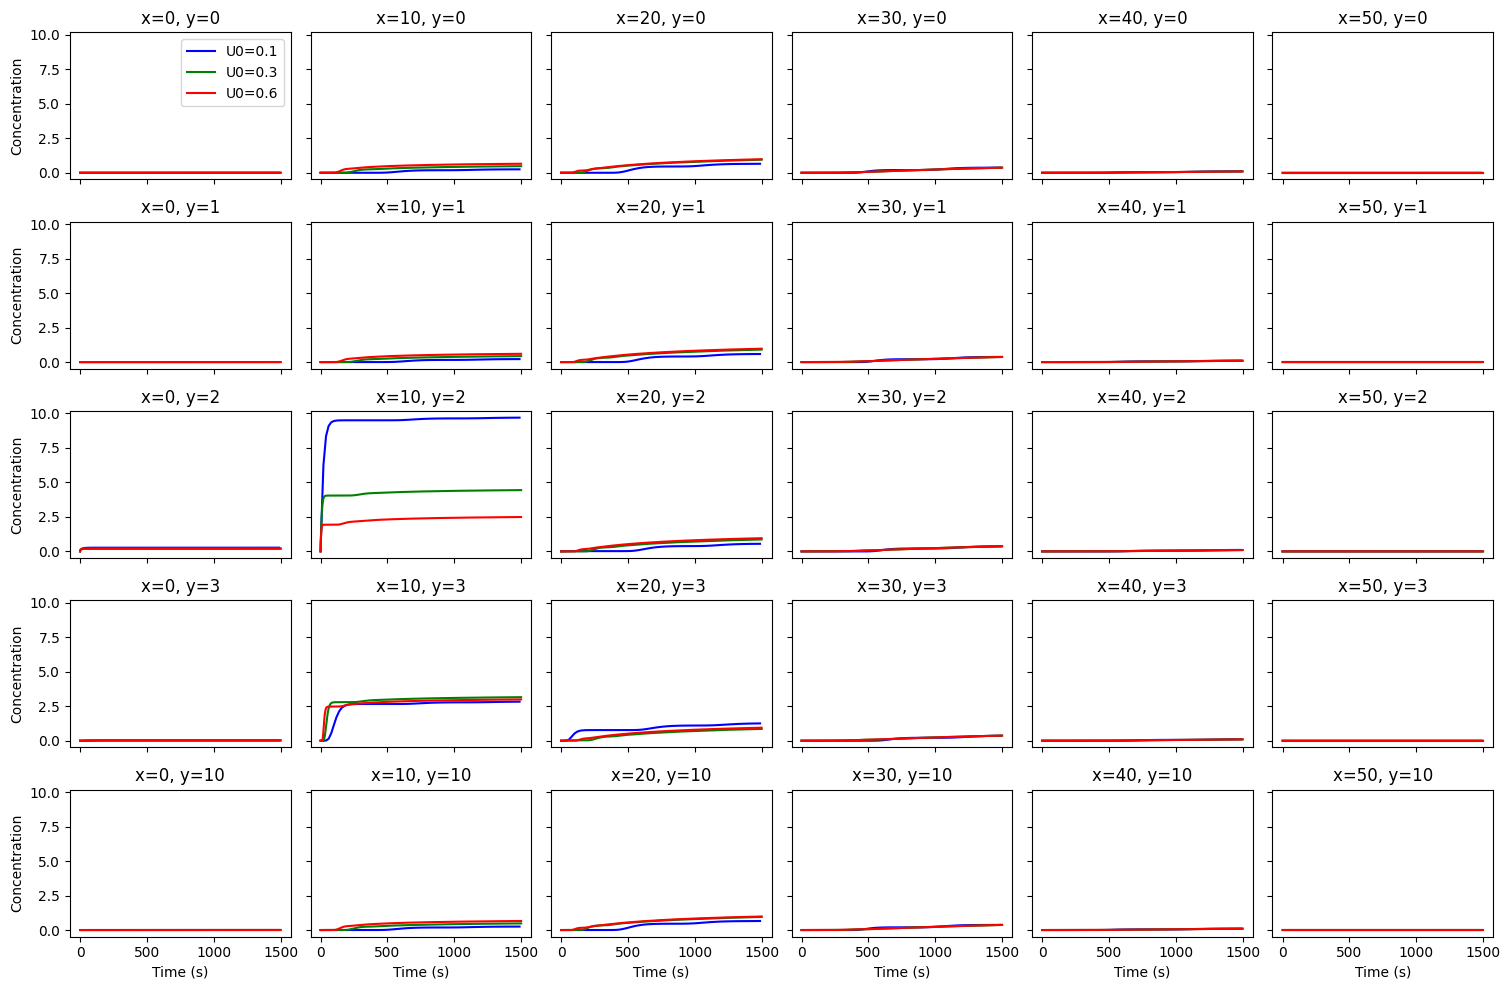

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging

logger = logging.getLogger(__name__)

def solve_advection_diffusion(U0):
    # Set parameters
    w = 10  # width of the river in m
    L = 50  # length of the river section to simulate
    kappa = 1e-2  # diffusivity in m^2/s
    S0 = 1  # amplitude of the pollution source term
    S_w = 1  # width of the source term in m
    S_x = 10  # center of the forcing in x
    S_y = 0  # center of the forcing in y
    S_t = 1  # forcing timescale

    # Numerical parameters
    Nx = 256  # number of grid points in x
    Ny = 32  # number of grid points in y
    stop_sim_time = 1500  # end time in seconds
    timestep = (L / Nx) / U0  # timestep in seconds, calculated from the CFL number

    # Bases and coordinates
    coords = dedalus.CartesianCoordinates('x', 'y')
    dist = dedalus.Distributor(coords, dtype=np.float64)
    xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3 / 2)
    ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3 / 2)
    x, y = dist.local_grids(xbasis, ybasis)
    ex, ey = coords.unit_vector_fields(dist)  # x and y unit vectors

    # Fields
    c = dist.Field(name='b', bases=(xbasis, ybasis))
    u = dist.Field(name='u', bases=(xbasis, ybasis))
    tau_1 = dist.Field(name='tau_1', bases=xbasis)
    tau_2 = dist.Field(name='tau_2', bases=xbasis)

    # Specify the velocity field
    u['g'] = U0 * (1 - (y - w / 2) ** 2.0 / (w / 2) ** 2.0)  # parabolic velocity profile

    # Substitutions
    lift_basis = ybasis.derivative_basis(1)
    lift = lambda A: dedalus.Lift(A, lift_basis, -1)
    grad_c = dedalus.grad(c) + ey * lift(tau_1)
    dx = lambda A: dedalus.Differentiate(A, coords['x'])

    S = dist.Field(name='u', bases=(xbasis, ybasis))
    S['g'] = S0 * np.exp(-(x - S_x) ** 2.0 / S_w ** 2.0 - (y - S_y) ** 2.0 / S_w ** 2.0)

    # Problem
    problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
    problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
    problem.add_equation("c(y=0) = 0")
    problem.add_equation("c(y=w) = 0")

    # Solver
    solver = problem.build_solver(dedalus.RK222)
    solver.stop_sim_time = stop_sim_time

    # Save concentration field over time
    c.change_scales(1)
    c_save = [np.copy(c['g'])]
    t_save = [solver.sim_time]  # Save the initial condition and the initial time

    try:
        logger.info('Starting main loop')
        while solver.proceed:
            solver.step(timestep)
            if (solver.iteration - 1) % 10 == 0:
                logger.info('Iteration=%i, Time=%e, dt=%e' % (solver.iteration, solver.sim_time, timestep))
                c.change_scales(1)
                c_save.append(np.copy(c['g']))
                t_save.append(solver.sim_time)
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()

    # Convert to numpy arrays
    c_save = np.array(c_save)
    t_save = np.array(t_save)
    return c_save, t_save

# Solve for U0 = 0.1, 0.2, 0.3
results = {}
for U0 in [0.1, 0.3, 0.6]:
    results[U0] = {}
    results[U0]['c_save'], results[U0]['t_save'] = solve_advection_diffusion(U0)

# The results dictionary now contains the concentration fields and time arrays for each U0 value
import numpy as np
import matplotlib.pyplot as plt

# Define the list of x and y coordinates to analyze
x_points = [0, 10, 20, 30, 40, 50]
y_points = [0, 1,2,3, 10]

# Define colors for each U0 value
U0_values = [0.1, 0.3, 0.6]
colors = {0.1: 'blue', 0.3: 'green', 0.6: 'red'}

# Create subplots
fig, axes = plt.subplots(len(y_points), len(x_points), figsize=(15, 10), sharex=True, sharey=True)

for U0 in U0_values:
    # Retrieve c_save and t_save for the current U0
    c_save = results[U0]['c_save']
    t_save = results[U0]['t_save']

    # Extract the x and y grid arrays
    x_coords = np.linspace(0, L, c_save.shape[2])
    y_coords = np.linspace(0, w, c_save.shape[1])

    # Loop through each pair of x and y points
    for i, y_point in enumerate(y_points):
        for j, x_point in enumerate(x_points):
            ax = axes[i, j]

            # Find the nearest indices for the specified x and y points
            x_idx = np.argmin(np.abs(x_coords - x_point))
            y_idx = np.argmin(np.abs(y_coords - y_point))

            # Extract the concentration time series at the specified point
            series = c_save[:, y_idx, x_idx]

            # Plot the data in the subplot
            ax.plot(t_save, series, label=f"U0={U0}", color=colors[U0])
            ax.set_title(f"x={x_point}, y={y_point}")

            # Label the axes
            if i == len(y_points) - 1:
                ax.set_xlabel('Time (s)')
            if j == 0:
                ax.set_ylabel('Concentration')


# Add a legend to the first subplot
axes[0, 0].legend(loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()



INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+00/s


2024-12-25 03:55:51,978 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+00/s


INFO:__main__:Starting main loop


2024-12-25 03:55:51,986 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2024-12-25 03:55:52,023 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2024-12-25 03:55:52,053 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2024-12-25 03:55:52,083 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2024-12-25 03:55:52,112 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2024-12-25 03:55:52,143 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2024-12-25 03:55:52,173 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2024-12-25 03:55:52,202 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2024-12-25 03:55:52,235 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2024-12-25 03:55:52,268 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2024-12-25 03:55:52,299 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2024-12-25 03:55:52,331 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2024-12-25 03:55:52,361 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2024-12-25 03:55:52,392 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2024-12-25 03:55:52,423 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2024-12-25 03:55:52,462 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2024-12-25 03:55:52,495 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2024-12-25 03:55:52,525 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2024-12-25 03:55:52,555 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2024-12-25 03:55:52,586 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2024-12-25 03:55:52,616 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2024-12-25 03:55:52,651 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2024-12-25 03:55:52,681 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2024-12-25 03:55:52,712 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2024-12-25 03:55:52,747 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2024-12-25 03:55:52,787 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2024-12-25 03:55:52,824 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2024-12-25 03:55:52,863 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2024-12-25 03:55:52,902 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2024-12-25 03:55:52,948 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2024-12-25 03:55:52,986 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2024-12-25 03:55:53,027 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2024-12-25 03:55:53,069 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2024-12-25 03:55:53,103 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2024-12-25 03:55:53,133 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2024-12-25 03:55:53,163 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2024-12-25 03:55:53,193 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2024-12-25 03:55:53,224 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2024-12-25 03:55:53,254 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2024-12-25 03:55:53,288 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2024-12-25 03:55:53,317 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2024-12-25 03:55:53,349 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2024-12-25 03:55:53,379 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2024-12-25 03:55:53,412 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2024-12-25 03:55:53,443 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2024-12-25 03:55:53,474 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2024-12-25 03:55:53,517 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2024-12-25 03:55:53,547 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2024-12-25 03:55:53,577 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2024-12-25 03:55:53,607 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2024-12-25 03:55:53,636 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2024-12-25 03:55:53,666 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2024-12-25 03:55:53,700 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2024-12-25 03:55:53,731 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2024-12-25 03:55:53,769 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2024-12-25 03:55:53,808 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2024-12-25 03:55:53,852 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2024-12-25 03:55:53,890 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2024-12-25 03:55:53,941 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2024-12-25 03:55:53,996 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2024-12-25 03:55:54,047 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2024-12-25 03:55:54,093 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2024-12-25 03:55:54,136 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2024-12-25 03:55:54,181 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2024-12-25 03:55:54,225 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2024-12-25 03:55:54,269 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2024-12-25 03:55:54,310 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2024-12-25 03:55:54,355 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2024-12-25 03:55:54,404 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2024-12-25 03:55:54,456 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2024-12-25 03:55:54,499 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2024-12-25 03:55:54,557 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2024-12-25 03:55:54,603 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2024-12-25 03:55:54,642 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2024-12-25 03:55:54,683 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2024-12-25 03:55:54,730 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2024-12-25 03:55:54,784 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2024-12-25 03:55:54,837 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2024-12-25 03:55:54,878 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-25 03:55:54,884 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-25 03:55:54,887 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.286 sec


2024-12-25 03:55:54,891 solvers 0/1 INFO :: Setup time (init - iter 0): 0.286 sec


INFO:solvers:Warmup time (iter 0-10): 0.0571 sec


2024-12-25 03:55:54,893 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0571 sec


INFO:solvers:Run time (iter 10-end): 2.833 sec


2024-12-25 03:55:54,895 solvers 0/1 INFO :: Run time (iter 10-end): 2.833 sec


INFO:solvers:CPU time (iter 10-end): 0.000787 cpu-hr


2024-12-25 03:55:54,898 solvers 0/1 INFO :: CPU time (iter 10-end): 0.000787 cpu-hr


INFO:solvers:Speed: 4.639e+06 mode-stages/cpu-sec


2024-12-25 03:55:54,900 solvers 0/1 INFO :: Speed: 4.639e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


2024-12-25 03:55:55,410 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


INFO:__main__:Starting main loop


2024-12-25 03:55:55,418 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2024-12-25 03:55:55,473 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2024-12-25 03:55:55,520 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2024-12-25 03:55:55,569 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2024-12-25 03:55:55,614 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2024-12-25 03:55:55,659 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2024-12-25 03:55:55,699 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2024-12-25 03:55:55,742 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2024-12-25 03:55:55,793 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2024-12-25 03:55:55,854 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2024-12-25 03:55:55,900 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2024-12-25 03:55:55,941 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2024-12-25 03:55:55,986 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2024-12-25 03:55:56,029 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2024-12-25 03:55:56,069 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2024-12-25 03:55:56,111 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2024-12-25 03:55:56,154 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2024-12-25 03:55:56,197 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2024-12-25 03:55:56,248 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2024-12-25 03:55:56,299 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2024-12-25 03:55:56,350 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2024-12-25 03:55:56,398 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2024-12-25 03:55:56,447 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2024-12-25 03:55:56,503 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2024-12-25 03:55:56,546 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2024-12-25 03:55:56,598 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2024-12-25 03:55:56,646 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2024-12-25 03:55:56,702 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2024-12-25 03:55:56,748 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2024-12-25 03:55:56,793 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2024-12-25 03:55:56,843 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2024-12-25 03:55:56,895 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2024-12-25 03:55:56,944 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2024-12-25 03:55:56,996 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2024-12-25 03:55:57,044 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2024-12-25 03:55:57,102 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2024-12-25 03:55:57,151 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2024-12-25 03:55:57,198 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2024-12-25 03:55:57,252 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2024-12-25 03:55:57,294 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2024-12-25 03:55:57,335 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2024-12-25 03:55:57,388 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2024-12-25 03:55:57,431 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2024-12-25 03:55:57,478 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2024-12-25 03:55:57,525 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2024-12-25 03:55:57,569 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2024-12-25 03:55:57,612 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2024-12-25 03:55:57,656 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2024-12-25 03:55:57,699 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2024-12-25 03:55:57,755 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2024-12-25 03:55:57,819 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2024-12-25 03:55:57,876 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2024-12-25 03:55:57,933 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2024-12-25 03:55:57,976 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2024-12-25 03:55:58,017 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2024-12-25 03:55:58,059 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2024-12-25 03:55:58,099 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2024-12-25 03:55:58,139 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2024-12-25 03:55:58,179 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2024-12-25 03:55:58,218 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2024-12-25 03:55:58,272 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2024-12-25 03:55:58,316 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2024-12-25 03:55:58,356 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2024-12-25 03:55:58,397 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2024-12-25 03:55:58,438 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2024-12-25 03:55:58,485 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2024-12-25 03:55:58,530 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2024-12-25 03:55:58,585 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2024-12-25 03:55:58,626 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2024-12-25 03:55:58,677 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2024-12-25 03:55:58,734 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2024-12-25 03:55:58,780 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2024-12-25 03:55:58,835 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2024-12-25 03:55:58,898 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2024-12-25 03:55:58,959 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2024-12-25 03:55:58,993 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2024-12-25 03:55:59,031 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2024-12-25 03:55:59,064 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2024-12-25 03:55:59,091 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-25 03:55:59,096 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-25 03:55:59,101 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.4731 sec


2024-12-25 03:55:59,105 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4731 sec


INFO:solvers:Warmup time (iter 0-10): 0.08898 sec


2024-12-25 03:55:59,108 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.08898 sec


INFO:solvers:Run time (iter 10-end): 3.579 sec


2024-12-25 03:55:59,110 solvers 0/1 INFO :: Run time (iter 10-end): 3.579 sec


INFO:solvers:CPU time (iter 10-end): 0.0009942 cpu-hr


2024-12-25 03:55:59,113 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0009942 cpu-hr


INFO:solvers:Speed: 3.672e+06 mode-stages/cpu-sec


2024-12-25 03:55:59,116 solvers 0/1 INFO :: Speed: 3.672e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.1e+00/s


2024-12-25 03:55:59,445 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.1e+00/s


INFO:__main__:Starting main loop


2024-12-25 03:55:59,454 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2024-12-25 03:55:59,494 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2024-12-25 03:55:59,528 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2024-12-25 03:55:59,562 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2024-12-25 03:55:59,593 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2024-12-25 03:55:59,625 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2024-12-25 03:55:59,662 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2024-12-25 03:55:59,692 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2024-12-25 03:55:59,723 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2024-12-25 03:55:59,764 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2024-12-25 03:55:59,802 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2024-12-25 03:55:59,847 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2024-12-25 03:55:59,890 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2024-12-25 03:55:59,936 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2024-12-25 03:55:59,978 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2024-12-25 03:56:00,023 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2024-12-25 03:56:00,063 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2024-12-25 03:56:00,099 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2024-12-25 03:56:00,132 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2024-12-25 03:56:00,167 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2024-12-25 03:56:00,198 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2024-12-25 03:56:00,232 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2024-12-25 03:56:00,271 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2024-12-25 03:56:00,300 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2024-12-25 03:56:00,336 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2024-12-25 03:56:00,366 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2024-12-25 03:56:00,402 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2024-12-25 03:56:00,437 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2024-12-25 03:56:00,469 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2024-12-25 03:56:00,509 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2024-12-25 03:56:00,540 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2024-12-25 03:56:00,573 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2024-12-25 03:56:00,607 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2024-12-25 03:56:00,641 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2024-12-25 03:56:00,673 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2024-12-25 03:56:00,708 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2024-12-25 03:56:00,742 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2024-12-25 03:56:00,781 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2024-12-25 03:56:00,823 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2024-12-25 03:56:00,866 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2024-12-25 03:56:00,904 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2024-12-25 03:56:00,946 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2024-12-25 03:56:00,988 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2024-12-25 03:56:01,038 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2024-12-25 03:56:01,078 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2024-12-25 03:56:01,110 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2024-12-25 03:56:01,142 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2024-12-25 03:56:01,174 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2024-12-25 03:56:01,205 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2024-12-25 03:56:01,242 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2024-12-25 03:56:01,274 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2024-12-25 03:56:01,307 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2024-12-25 03:56:01,341 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2024-12-25 03:56:01,372 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2024-12-25 03:56:01,405 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2024-12-25 03:56:01,438 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2024-12-25 03:56:01,469 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2024-12-25 03:56:01,504 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2024-12-25 03:56:01,542 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2024-12-25 03:56:01,577 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2024-12-25 03:56:01,613 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2024-12-25 03:56:01,647 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2024-12-25 03:56:01,679 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2024-12-25 03:56:01,712 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2024-12-25 03:56:01,754 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2024-12-25 03:56:01,796 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2024-12-25 03:56:01,839 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2024-12-25 03:56:01,883 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2024-12-25 03:56:01,923 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2024-12-25 03:56:01,964 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2024-12-25 03:56:02,009 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2024-12-25 03:56:02,050 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2024-12-25 03:56:02,098 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2024-12-25 03:56:02,132 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2024-12-25 03:56:02,164 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2024-12-25 03:56:02,198 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2024-12-25 03:56:02,230 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2024-12-25 03:56:02,265 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2024-12-25 03:56:02,297 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-25 03:56:02,302 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-25 03:56:02,307 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.2948 sec


2024-12-25 03:56:02,311 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2948 sec


INFO:solvers:Warmup time (iter 0-10): 0.06239 sec


2024-12-25 03:56:02,312 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06239 sec


INFO:solvers:Run time (iter 10-end): 2.776 sec


2024-12-25 03:56:02,315 solvers 0/1 INFO :: Run time (iter 10-end): 2.776 sec


INFO:solvers:CPU time (iter 10-end): 0.0007711 cpu-hr


2024-12-25 03:56:02,317 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0007711 cpu-hr


INFO:solvers:Speed: 4.735e+06 mode-stages/cpu-sec


2024-12-25 03:56:02,319 solvers 0/1 INFO :: Speed: 4.735e+06 mode-stages/cpu-sec


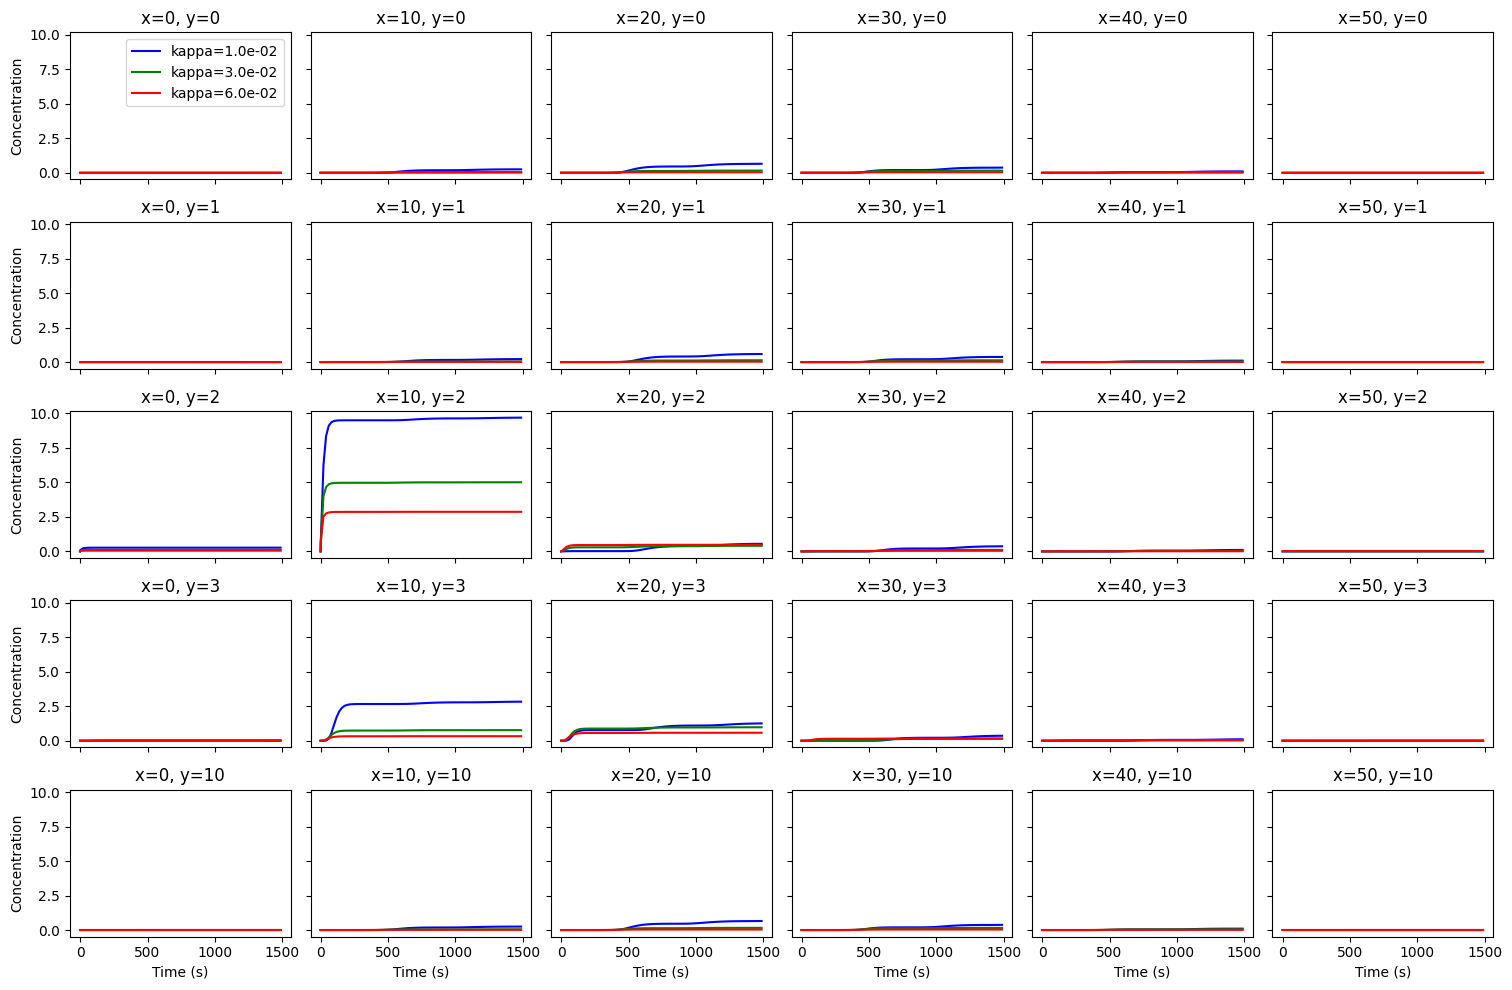

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging

logger = logging.getLogger(__name__)

def solve_advection_diffusion(kappa):
    # Set parameters
    U0 = 0.1  # maximum current speed in m/s
    w = 10  # width of the river in m
    L = 50  # length of the river section to simulate
    S0 = 1  # amplitude of the pollution source term
    S_w = 1  # width of the source term in m
    S_x = 10  # center of the forcing in x
    S_y = 0  # center of the forcing in y
    S_t = 1  # forcing timescale

    # Numerical parameters
    Nx = 256  # number of grid points in x
    Ny = 32  # number of grid points in y
    stop_sim_time = 1500  # end time in seconds
    timestep = (L / Nx) / U0  # timestep in seconds, calculated from the CFL number

    # Bases and coordinates
    coords = dedalus.CartesianCoordinates('x', 'y')
    dist = dedalus.Distributor(coords, dtype=np.float64)
    xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3 / 2)
    ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3 / 2)
    x, y = dist.local_grids(xbasis, ybasis)
    ex, ey = coords.unit_vector_fields(dist)  # x and y unit vectors

    # Fields
    c = dist.Field(name='b', bases=(xbasis, ybasis))
    u = dist.Field(name='u', bases=(xbasis, ybasis))
    tau_1 = dist.Field(name='tau_1', bases=xbasis)
    tau_2 = dist.Field(name='tau_2', bases=xbasis)

    # Specify the velocity field
    u['g'] = U0 * (1 - (y - w / 2) ** 2.0 / (w / 2) ** 2.0)  # parabolic velocity profile

    # Substitutions
    lift_basis = ybasis.derivative_basis(1)
    lift = lambda A: dedalus.Lift(A, lift_basis, -1)
    grad_c = dedalus.grad(c) + ey * lift(tau_1)
    dx = lambda A: dedalus.Differentiate(A, coords['x'])

    S = dist.Field(name='u', bases=(xbasis, ybasis))
    S['g'] = S0 * np.exp(-(x - S_x) ** 2.0 / S_w ** 2.0 - (y - S_y) ** 2.0 / S_w ** 2.0)

    # Problem
    problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
    problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
    problem.add_equation("c(y=0) = 0")
    problem.add_equation("c(y=w) = 0")

    # Solver
    solver = problem.build_solver(dedalus.RK222)
    solver.stop_sim_time = stop_sim_time

    # Save concentration field over time
    c.change_scales(1)
    c_save = [np.copy(c['g'])]
    t_save = [solver.sim_time]  # Save the initial condition and the initial time

    try:
        logger.info('Starting main loop')
        while solver.proceed:
            solver.step(timestep)
            if (solver.iteration - 1) % 10 == 0:
                logger.info('Iteration=%i, Time=%e, dt=%e' % (solver.iteration, solver.sim_time, timestep))
                c.change_scales(1)
                c_save.append(np.copy(c['g']))
                t_save.append(solver.sim_time)
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()

    # Convert to numpy arrays
    c_save = np.array(c_save)
    t_save = np.array(t_save)
    return c_save, t_save

# Solve for kappa = 1e-2, 1e-3, 1e-4
results = {}
for kappa in [1e-2, 3e-2, 6e-2]:
    results[kappa] = {}
    results[kappa]['c_save'], results[kappa]['t_save'] = solve_advection_diffusion(kappa)

# Plotting the results
x_points = [0, 10, 20, 30, 40, 50]
y_points = [0, 1,2,3, 10]
# Define colors for each kappa value
colors = {1e-2: 'blue', 3e-2: 'green', 6e-2: 'red'}

fig, axes = plt.subplots(len(y_points), len(x_points), figsize=(15, 10), sharex=True, sharey=True)

for kappa in results.keys():
    c_save = results[kappa]['c_save']
    t_save = results[kappa]['t_save']
    x_coords = np.linspace(0, L, c_save.shape[2])
    y_coords = np.linspace(0, w, c_save.shape[1])

    for i, y_point in enumerate(y_points):
        for j, x_point in enumerate(x_points):
            ax = axes[i, j]
            x_idx = np.argmin(np.abs(x_coords - x_point))
            y_idx = np.argmin(np.abs(y_coords - y_point))
            series = c_save[:, y_idx, x_idx]
            ax.plot(t_save, series, label=f"kappa={kappa:.1e}", color=colors[kappa])
            ax.set_title(f"x={x_point}, y={y_point}")
            if i == len(y_points) - 1:
                ax.set_xlabel('Time (s)')
            if j == 0:
                ax.set_ylabel('Concentration')

axes[0, 0].legend(loc='upper right')
plt.tight_layout()
plt.show()



INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.1e+00/s


2024-12-25 03:52:17,058 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.1e+00/s


INFO:__main__:Starting main loop


2024-12-25 03:52:17,066 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2024-12-25 03:52:17,104 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2024-12-25 03:52:17,137 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2024-12-25 03:52:17,166 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2024-12-25 03:52:17,199 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2024-12-25 03:52:17,228 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2024-12-25 03:52:17,257 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2024-12-25 03:52:17,285 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2024-12-25 03:52:17,316 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2024-12-25 03:52:17,350 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2024-12-25 03:52:17,380 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2024-12-25 03:52:17,411 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2024-12-25 03:52:17,440 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2024-12-25 03:52:17,484 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2024-12-25 03:52:17,514 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2024-12-25 03:52:17,544 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2024-12-25 03:52:17,573 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2024-12-25 03:52:17,605 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2024-12-25 03:52:17,635 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2024-12-25 03:52:17,672 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2024-12-25 03:52:17,704 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2024-12-25 03:52:17,736 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2024-12-25 03:52:17,774 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2024-12-25 03:52:17,816 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2024-12-25 03:52:17,856 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2024-12-25 03:52:17,897 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2024-12-25 03:52:17,938 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2024-12-25 03:52:17,977 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2024-12-25 03:52:18,018 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2024-12-25 03:52:18,056 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2024-12-25 03:52:18,093 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2024-12-25 03:52:18,124 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2024-12-25 03:52:18,154 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2024-12-25 03:52:18,187 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2024-12-25 03:52:18,220 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2024-12-25 03:52:18,250 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2024-12-25 03:52:18,280 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2024-12-25 03:52:18,309 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2024-12-25 03:52:18,339 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2024-12-25 03:52:18,370 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2024-12-25 03:52:18,410 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2024-12-25 03:52:18,441 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2024-12-25 03:52:18,474 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2024-12-25 03:52:18,520 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2024-12-25 03:52:18,549 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2024-12-25 03:52:18,579 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2024-12-25 03:52:18,607 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2024-12-25 03:52:18,636 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2024-12-25 03:52:18,666 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2024-12-25 03:52:18,696 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2024-12-25 03:52:18,728 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2024-12-25 03:52:18,769 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2024-12-25 03:52:18,806 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2024-12-25 03:52:18,847 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2024-12-25 03:52:18,888 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2024-12-25 03:52:18,925 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2024-12-25 03:52:18,967 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2024-12-25 03:52:19,004 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2024-12-25 03:52:19,034 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2024-12-25 03:52:19,065 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2024-12-25 03:52:19,106 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2024-12-25 03:52:19,138 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2024-12-25 03:52:19,167 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2024-12-25 03:52:19,197 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2024-12-25 03:52:19,228 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2024-12-25 03:52:19,260 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2024-12-25 03:52:19,291 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2024-12-25 03:52:19,325 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2024-12-25 03:52:19,357 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2024-12-25 03:52:19,387 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2024-12-25 03:52:19,417 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2024-12-25 03:52:19,454 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2024-12-25 03:52:19,486 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2024-12-25 03:52:19,524 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2024-12-25 03:52:19,561 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2024-12-25 03:52:19,591 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2024-12-25 03:52:19,622 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2024-12-25 03:52:19,653 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2024-12-25 03:52:19,677 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-25 03:52:19,681 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-25 03:52:19,684 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.2864 sec


2024-12-25 03:52:19,688 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2864 sec


INFO:solvers:Warmup time (iter 0-10): 0.06113 sec


2024-12-25 03:52:19,690 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06113 sec


INFO:solvers:Run time (iter 10-end): 2.546 sec


2024-12-25 03:52:19,692 solvers 0/1 INFO :: Run time (iter 10-end): 2.546 sec


INFO:solvers:CPU time (iter 10-end): 0.0007072 cpu-hr


2024-12-25 03:52:19,694 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0007072 cpu-hr


INFO:solvers:Speed: 5.162e+06 mode-stages/cpu-sec


2024-12-25 03:52:19,696 solvers 0/1 INFO :: Speed: 5.162e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-12-25 03:52:20,083 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:__main__:Starting main loop


2024-12-25 03:52:20,090 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2024-12-25 03:52:20,130 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2024-12-25 03:52:20,162 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2024-12-25 03:52:20,193 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2024-12-25 03:52:20,225 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2024-12-25 03:52:20,258 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2024-12-25 03:52:20,295 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2024-12-25 03:52:20,328 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2024-12-25 03:52:20,359 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2024-12-25 03:52:20,392 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2024-12-25 03:52:20,422 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2024-12-25 03:52:20,454 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2024-12-25 03:52:20,487 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2024-12-25 03:52:20,522 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2024-12-25 03:52:20,554 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2024-12-25 03:52:20,599 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2024-12-25 03:52:20,629 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2024-12-25 03:52:20,660 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2024-12-25 03:52:20,690 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2024-12-25 03:52:20,719 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2024-12-25 03:52:20,756 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2024-12-25 03:52:20,795 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2024-12-25 03:52:20,842 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2024-12-25 03:52:20,882 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2024-12-25 03:52:20,921 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2024-12-25 03:52:20,961 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2024-12-25 03:52:21,001 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2024-12-25 03:52:21,040 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2024-12-25 03:52:21,079 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2024-12-25 03:52:21,118 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2024-12-25 03:52:21,160 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2024-12-25 03:52:21,200 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2024-12-25 03:52:21,233 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2024-12-25 03:52:21,266 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2024-12-25 03:52:21,296 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2024-12-25 03:52:21,326 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2024-12-25 03:52:21,359 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2024-12-25 03:52:21,394 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2024-12-25 03:52:21,424 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2024-12-25 03:52:21,455 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2024-12-25 03:52:21,486 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2024-12-25 03:52:21,519 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2024-12-25 03:52:21,551 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2024-12-25 03:52:21,581 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2024-12-25 03:52:21,627 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2024-12-25 03:52:21,678 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2024-12-25 03:52:21,719 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2024-12-25 03:52:21,770 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2024-12-25 03:52:21,824 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2024-12-25 03:52:21,880 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2024-12-25 03:52:21,937 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2024-12-25 03:52:21,994 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2024-12-25 03:52:22,042 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2024-12-25 03:52:22,098 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2024-12-25 03:52:22,150 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2024-12-25 03:52:22,199 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2024-12-25 03:52:22,251 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2024-12-25 03:52:22,299 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2024-12-25 03:52:22,345 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2024-12-25 03:52:22,389 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2024-12-25 03:52:22,435 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2024-12-25 03:52:22,482 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2024-12-25 03:52:22,526 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2024-12-25 03:52:22,566 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2024-12-25 03:52:22,607 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2024-12-25 03:52:22,648 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2024-12-25 03:52:22,697 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2024-12-25 03:52:22,751 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2024-12-25 03:52:22,801 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2024-12-25 03:52:22,852 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2024-12-25 03:52:22,911 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2024-12-25 03:52:22,976 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2024-12-25 03:52:23,027 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2024-12-25 03:52:23,083 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2024-12-25 03:52:23,126 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2024-12-25 03:52:23,168 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2024-12-25 03:52:23,218 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2024-12-25 03:52:23,264 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2024-12-25 03:52:23,296 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-25 03:52:23,300 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-25 03:52:23,303 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.3556 sec


2024-12-25 03:52:23,306 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3556 sec


INFO:solvers:Warmup time (iter 0-10): 0.05989 sec


2024-12-25 03:52:23,309 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.05989 sec


INFO:solvers:Run time (iter 10-end): 3.14 sec


2024-12-25 03:52:23,311 solvers 0/1 INFO :: Run time (iter 10-end): 3.14 sec


INFO:solvers:CPU time (iter 10-end): 0.0008723 cpu-hr


2024-12-25 03:52:23,313 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0008723 cpu-hr


INFO:solvers:Speed: 4.185e+06 mode-stages/cpu-sec


2024-12-25 03:52:23,315 solvers 0/1 INFO :: Speed: 4.185e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


2024-12-25 03:52:23,800 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s


INFO:__main__:Starting main loop


2024-12-25 03:52:23,810 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2024-12-25 03:52:23,883 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2024-12-25 03:52:23,940 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2024-12-25 03:52:23,993 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2024-12-25 03:52:24,039 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2024-12-25 03:52:24,089 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2024-12-25 03:52:24,133 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2024-12-25 03:52:24,185 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2024-12-25 03:52:24,228 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2024-12-25 03:52:24,274 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2024-12-25 03:52:24,323 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2024-12-25 03:52:24,371 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2024-12-25 03:52:24,419 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2024-12-25 03:52:24,471 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2024-12-25 03:52:24,518 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2024-12-25 03:52:24,565 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2024-12-25 03:52:24,613 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2024-12-25 03:52:24,665 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2024-12-25 03:52:24,714 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2024-12-25 03:52:24,766 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2024-12-25 03:52:24,833 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2024-12-25 03:52:24,891 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2024-12-25 03:52:24,957 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2024-12-25 03:52:25,007 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2024-12-25 03:52:25,053 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2024-12-25 03:52:25,106 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2024-12-25 03:52:25,149 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2024-12-25 03:52:25,197 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2024-12-25 03:52:25,248 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2024-12-25 03:52:25,296 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2024-12-25 03:52:25,345 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2024-12-25 03:52:25,391 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2024-12-25 03:52:25,447 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2024-12-25 03:52:25,494 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2024-12-25 03:52:25,541 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2024-12-25 03:52:25,588 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2024-12-25 03:52:25,645 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2024-12-25 03:52:25,692 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2024-12-25 03:52:25,740 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2024-12-25 03:52:25,790 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2024-12-25 03:52:25,843 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2024-12-25 03:52:25,903 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2024-12-25 03:52:25,950 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2024-12-25 03:52:26,006 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2024-12-25 03:52:26,059 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2024-12-25 03:52:26,104 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2024-12-25 03:52:26,159 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2024-12-25 03:52:26,206 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2024-12-25 03:52:26,254 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2024-12-25 03:52:26,296 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2024-12-25 03:52:26,343 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2024-12-25 03:52:26,403 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2024-12-25 03:52:26,435 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2024-12-25 03:52:26,472 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2024-12-25 03:52:26,505 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2024-12-25 03:52:26,538 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2024-12-25 03:52:26,571 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2024-12-25 03:52:26,609 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2024-12-25 03:52:26,641 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2024-12-25 03:52:26,671 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2024-12-25 03:52:26,704 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2024-12-25 03:52:26,738 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2024-12-25 03:52:26,781 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2024-12-25 03:52:26,822 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2024-12-25 03:52:26,869 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2024-12-25 03:52:26,913 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2024-12-25 03:52:26,957 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2024-12-25 03:52:26,997 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2024-12-25 03:52:27,031 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2024-12-25 03:52:27,076 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2024-12-25 03:52:27,112 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2024-12-25 03:52:27,145 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2024-12-25 03:52:27,178 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2024-12-25 03:52:27,210 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2024-12-25 03:52:27,246 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2024-12-25 03:52:27,280 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2024-12-25 03:52:27,315 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2024-12-25 03:52:27,353 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2024-12-25 03:52:27,380 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-25 03:52:27,385 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-25 03:52:27,390 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.4437 sec


2024-12-25 03:52:27,393 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4437 sec


INFO:solvers:Warmup time (iter 0-10): 0.1171 sec


2024-12-25 03:52:27,395 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.1171 sec


INFO:solvers:Run time (iter 10-end): 3.449 sec


2024-12-25 03:52:27,398 solvers 0/1 INFO :: Run time (iter 10-end): 3.449 sec


INFO:solvers:CPU time (iter 10-end): 0.000958 cpu-hr


2024-12-25 03:52:27,400 solvers 0/1 INFO :: CPU time (iter 10-end): 0.000958 cpu-hr


INFO:solvers:Speed: 3.811e+06 mode-stages/cpu-sec


2024-12-25 03:52:27,403 solvers 0/1 INFO :: Speed: 3.811e+06 mode-stages/cpu-sec


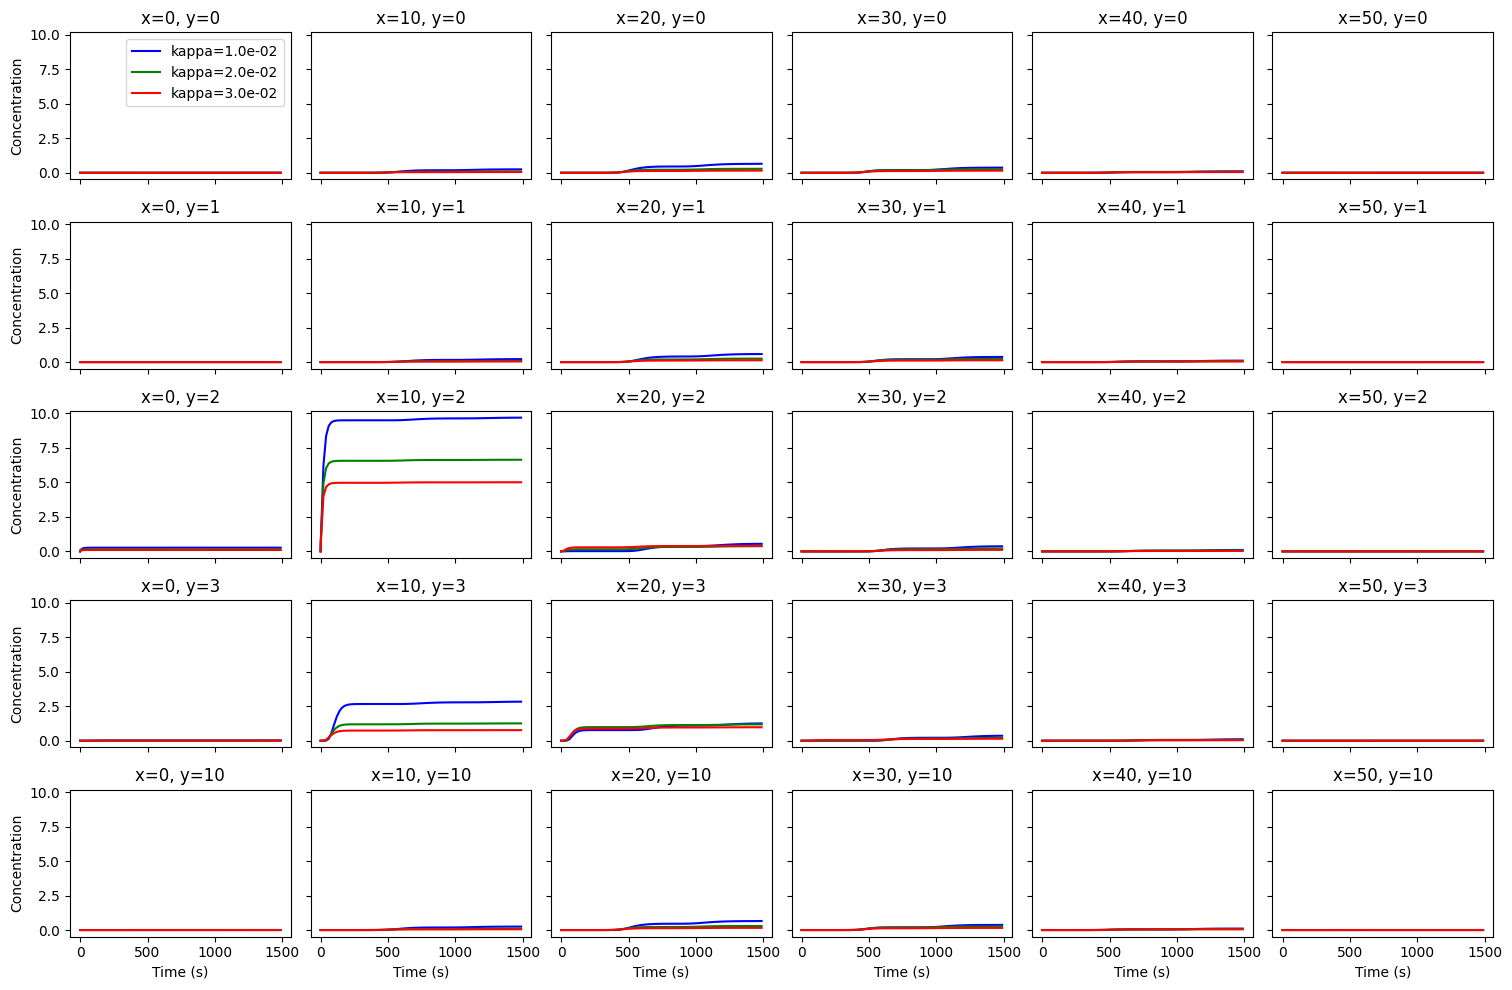

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging

logger = logging.getLogger(__name__)

def solve_advection_diffusion(kappa):
    # Set parameters
    U0 = 0.1  # maximum current speed in m/s
    w = 10  # width of the river in m
    L = 50  # length of the river section to simulate
    S0 = 1  # amplitude of the pollution source term
    S_w = 1  # width of the source term in m
    S_x = 10  # center of the forcing in x
    S_y = 0  # center of the forcing in y
    S_t = 1  # forcing timescale

    # Numerical parameters
    Nx = 256  # number of grid points in x
    Ny = 32  # number of grid points in y
    stop_sim_time = 1500  # end time in seconds
    timestep = (L / Nx) / U0  # timestep in seconds, calculated from the CFL number

    # Bases and coordinates
    coords = dedalus.CartesianCoordinates('x', 'y')
    dist = dedalus.Distributor(coords, dtype=np.float64)
    xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3 / 2)
    ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3 / 2)
    x, y = dist.local_grids(xbasis, ybasis)
    ex, ey = coords.unit_vector_fields(dist)  # x and y unit vectors

    # Fields
    c = dist.Field(name='b', bases=(xbasis, ybasis))
    u = dist.Field(name='u', bases=(xbasis, ybasis))
    tau_1 = dist.Field(name='tau_1', bases=xbasis)
    tau_2 = dist.Field(name='tau_2', bases=xbasis)

    # Specify the velocity field
    u['g'] = U0 * (1 - (y - w / 2) ** 2.0 / (w / 2) ** 2.0)  # parabolic velocity profile

    # Substitutions
    lift_basis = ybasis.derivative_basis(1)
    lift = lambda A: dedalus.Lift(A, lift_basis, -1)
    grad_c = dedalus.grad(c) + ey * lift(tau_1)
    dx = lambda A: dedalus.Differentiate(A, coords['x'])

    S = dist.Field(name='u', bases=(xbasis, ybasis))
    S['g'] = S0 * np.exp(-(x - S_x) ** 2.0 / S_w ** 2.0 - (y - S_y) ** 2.0 / S_w ** 2.0)

    # Problem
    problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
    problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
    problem.add_equation("c(y=0) = 0")
    problem.add_equation("c(y=w) = 0")

    # Solver
    solver = problem.build_solver(dedalus.RK222)
    solver.stop_sim_time = stop_sim_time

    # Save concentration field over time
    c.change_scales(1)
    c_save = [np.copy(c['g'])]
    t_save = [solver.sim_time]  # Save the initial condition and the initial time

    try:
        logger.info('Starting main loop')
        while solver.proceed:
            solver.step(timestep)
            if (solver.iteration - 1) % 10 == 0:
                logger.info('Iteration=%i, Time=%e, dt=%e' % (solver.iteration, solver.sim_time, timestep))
                c.change_scales(1)
                c_save.append(np.copy(c['g']))
                t_save.append(solver.sim_time)
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()

    # Convert to numpy arrays
    c_save = np.array(c_save)
    t_save = np.array(t_save)
    return c_save, t_save

# Solve for kappa = 1e-2, 1e-3, 1e-4
results = {}
for kappa in [1e-2, 2e-2, 3e-2]:
    results[kappa] = {}
    results[kappa]['c_save'], results[kappa]['t_save'] = solve_advection_diffusion(kappa)

# Plotting the results
x_points = [0, 10, 20, 30, 40, 50]
y_points = [0, 1,2,3, 10]
# Define colors for each kappa value
colors = {1e-2: 'blue', 2e-2: 'green', 3e-2: 'red'}

fig, axes = plt.subplots(len(y_points), len(x_points), figsize=(15, 10), sharex=True, sharey=True)

for kappa in results.keys():
    c_save = results[kappa]['c_save']
    t_save = results[kappa]['t_save']
    x_coords = np.linspace(0, L, c_save.shape[2])
    y_coords = np.linspace(0, w, c_save.shape[1])

    for i, y_point in enumerate(y_points):
        for j, x_point in enumerate(x_points):
            ax = axes[i, j]
            x_idx = np.argmin(np.abs(x_coords - x_point))
            y_idx = np.argmin(np.abs(y_coords - y_point))
            series = c_save[:, y_idx, x_idx]
            ax.plot(t_save, series, label=f"kappa={kappa:.1e}", color=colors[kappa])
            ax.set_title(f"x={x_point}, y={y_point}")
            if i == len(y_points) - 1:
                ax.set_xlabel('Time (s)')
            if j == 0:
                ax.set_ylabel('Concentration')

axes[0, 0].legend(loc='upper right')
plt.tight_layout()
plt.show()



INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-25 03:49:44,050 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1500x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpbp58bjk7/temp.m4v


2024-12-25 03:49:44,058 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1500x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpbp58bjk7/temp.m4v


TypeError: Dimensions of C (32, 256) should be one smaller than X(32) and Y(256) while using shading='flat' see help(pcolor)

Error in callback <function _draw_all_if_interactive at 0x7bd7e2a0e4d0> (for post_execute):


TypeError: Dimensions of C (32, 256) should be one smaller than X(32) and Y(256) while using shading='flat' see help(pcolor)

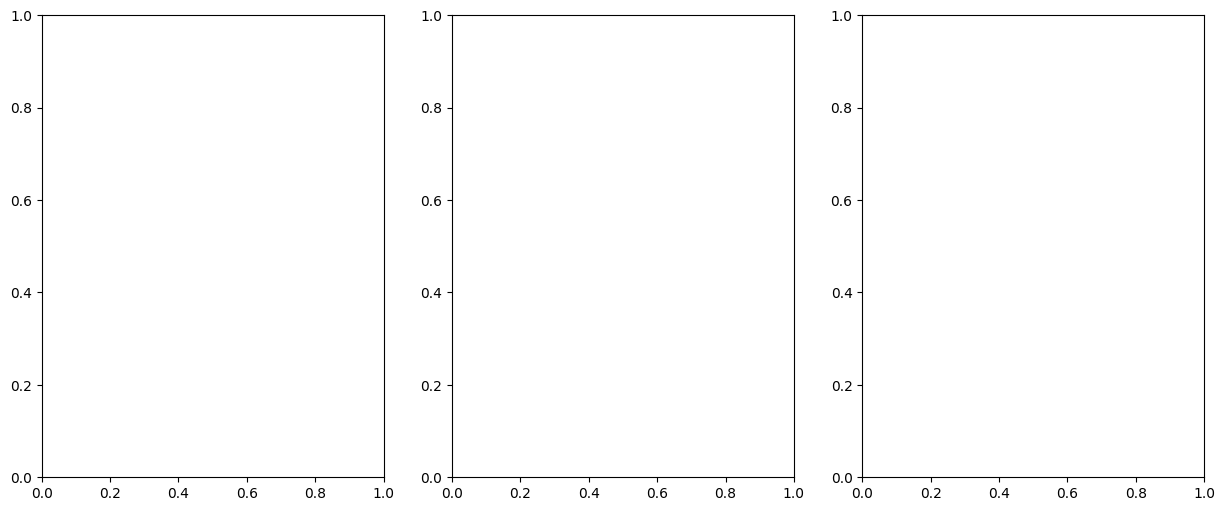

INSERT PLOTS AND COMMENTS HERE

## 3. Optional further investigations

* In the river pollution example, you might notice that the concentration field is mixed more effectively in the x-direction than in the y-direction. The combination of differential advection by the currents and cross-stream diffusion is very effective at mixing the plume in the x-direction. This is an example of Taylor dispersion (Taylor, 1953). Construct numerical experiments to quantify Taylor dispersion and its dependence on the current shear and the diffusivity. You could also separate the diffusivity into parts in the x and y directions with different coefficients.  If you set the x-component of the diffusivity to zero, then any spreading of the concentration in the x-direction should be due to Taylor dispersion.

* Try making the river speed a function of time. The easiest way to do this is to add a new equation so that Dedalus solves for the velocity in addition to the concentration field. For example, you could make the river speed decrease exponentially in time, or it could be sinusoidal in time.

* In the ocean mixing example, if $\kappa$ is a function of $x$ and $z$, what would this imply about the velocity field? You could even try writing a Dedalus script to solve the 2D advection/diffusion equation with a prescribed spatially-dependent $\kappa(x,z)$.


### References

Munk, W.H., 1966. Abyssal recipes. In Deep sea research and oceanographic abstracts (Vol. 13, No. 4, pp. 707-730). Elsevier.

Ferrari, R., Mashayek, A., McDougall, T.J., Nikurashin, M. and Campin, J.M., 2016. Turning ocean mixing upside down. Journal of Physical Oceanography, 46(7), pp.2239-2261.

Taylor, G.I., 1953. Dispersion of soluble matter in solvent flowing slowly through a tube. Proceedings of the Royal Society of London. Series A. Mathematical and Physical Sciences, 219(1137), pp.186-203.